In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 5
DATASET_VERSION = "08"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-xtree-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-xtree-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-xtree-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
!ls ../data/processed/dsv02

test.parquet  train.parquet


In [6]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [7]:
input_feats = train.columns.tolist()
len(input_feats)

1149

In [8]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [9]:
model_params = {
    'boosting':'dart',
    'extra_trees':True,
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.2,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [10]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        seed = repetition*5 + fold
        _model_params = dict(model_params)
        _model_params["seed"] = seed
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        print("seed:", seed)
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        model = lgb.train(
            params=_model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=5000,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [11]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/5 ################################


######################################## training model 1/5 ########################################
seed: 0


[50]	valid_0's amex_metric: 0.747995	valid_0's recall_at4: 0.597618	valid_0's norm_gini: 0.898372


[100]	valid_0's amex_metric: 0.75576	valid_0's recall_at4: 0.607759	valid_0's norm_gini: 0.903761


[150]	valid_0's amex_metric: 0.759852	valid_0's recall_at4: 0.613481	valid_0's norm_gini: 0.906223


[200]	valid_0's amex_metric: 0.764882	valid_0's recall_at4: 0.621266	valid_0's norm_gini: 0.908498


[250]	valid_0's amex_metric: 0.768299	valid_0's recall_at4: 0.626189	valid_0's norm_gini: 0.910409


[300]	valid_0's amex_metric: 0.769973	valid_0's recall_at4: 0.628166	valid_0's norm_gini: 0.91178


[350]	valid_0's amex_metric: 0.772083	valid_0's recall_at4: 0.631406	valid_0's norm_gini: 0.912759


[400]	valid_0's amex_metric: 0.774402	valid_0's recall_at4: 0.635025	valid_0's norm_gini: 0.91378


[450]	valid_0's amex_metric: 0.777008	valid_0's recall_at4: 0.639317	valid_0's norm_gini: 0.914699


[500]	valid_0's amex_metric: 0.778043	valid_0's recall_at4: 0.640579	valid_0's norm_gini: 0.915507


[550]	valid_0's amex_metric: 0.779487	valid_0's recall_at4: 0.642641	valid_0's norm_gini: 0.916333


[600]	valid_0's amex_metric: 0.779827	valid_0's recall_at4: 0.642725	valid_0's norm_gini: 0.916929


[650]	valid_0's amex_metric: 0.781527	valid_0's recall_at4: 0.645334	valid_0's norm_gini: 0.91772


[700]	valid_0's amex_metric: 0.782199	valid_0's recall_at4: 0.646007	valid_0's norm_gini: 0.918391


[750]	valid_0's amex_metric: 0.783341	valid_0's recall_at4: 0.647732	valid_0's norm_gini: 0.918951


[800]	valid_0's amex_metric: 0.784116	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.919237


[850]	valid_0's amex_metric: 0.78426	valid_0's recall_at4: 0.649078	valid_0's norm_gini: 0.919442


[900]	valid_0's amex_metric: 0.786098	valid_0's recall_at4: 0.651982	valid_0's norm_gini: 0.920215


[950]	valid_0's amex_metric: 0.787377	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.920711


[1000]	valid_0's amex_metric: 0.788154	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.921128


[1050]	valid_0's amex_metric: 0.788808	valid_0's recall_at4: 0.656232	valid_0's norm_gini: 0.921384


[1100]	valid_0's amex_metric: 0.790035	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.921609


[1150]	valid_0's amex_metric: 0.79022	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.921895


[1200]	valid_0's amex_metric: 0.791413	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.922093


[1250]	valid_0's amex_metric: 0.791877	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.922305


[1300]	valid_0's amex_metric: 0.791898	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.922473


[1350]	valid_0's amex_metric: 0.792316	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.922721


[1400]	valid_0's amex_metric: 0.79259	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.922889


[1450]	valid_0's amex_metric: 0.793191	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.922955


[1500]	valid_0's amex_metric: 0.79358	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923018


[1550]	valid_0's amex_metric: 0.793632	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.923079


[1600]	valid_0's amex_metric: 0.793656	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.923127


[1650]	valid_0's amex_metric: 0.793389	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.923226


[1700]	valid_0's amex_metric: 0.793804	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.92334


[1750]	valid_0's amex_metric: 0.794227	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.92347


[1800]	valid_0's amex_metric: 0.794429	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.923537


[1850]	valid_0's amex_metric: 0.794697	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.92361


[1900]	valid_0's amex_metric: 0.794905	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.923732


[1950]	valid_0's amex_metric: 0.794163	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.923763


[2000]	valid_0's amex_metric: 0.795154	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.923851


[2050]	valid_0's amex_metric: 0.79504	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.92396


[2100]	valid_0's amex_metric: 0.795765	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924021


[2150]	valid_0's amex_metric: 0.795441	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.924089


[2200]	valid_0's amex_metric: 0.795753	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.924166


[2250]	valid_0's amex_metric: 0.795362	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.924225


[2300]	valid_0's amex_metric: 0.794994	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924247


[2350]	valid_0's amex_metric: 0.795248	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924292


[2400]	valid_0's amex_metric: 0.795171	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.924348


[2450]	valid_0's amex_metric: 0.795386	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.924399


[2500]	valid_0's amex_metric: 0.795558	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924449


[2550]	valid_0's amex_metric: 0.796014	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.924478


[2600]	valid_0's amex_metric: 0.795801	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.924514


[2650]	valid_0's amex_metric: 0.796234	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924539


[2700]	valid_0's amex_metric: 0.796464	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924578


[2750]	valid_0's amex_metric: 0.796589	valid_0's recall_at4: 0.66856	valid_0's norm_gini: 0.924618


[2800]	valid_0's amex_metric: 0.796699	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.924627


[2850]	valid_0's amex_metric: 0.796713	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.924655


[2900]	valid_0's amex_metric: 0.796746	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.924722


[2950]	valid_0's amex_metric: 0.796608	valid_0's recall_at4: 0.668434	valid_0's norm_gini: 0.924782


[3000]	valid_0's amex_metric: 0.796409	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924805


[3050]	valid_0's amex_metric: 0.796252	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.924828


[3100]	valid_0's amex_metric: 0.795845	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.924854


[3150]	valid_0's amex_metric: 0.795976	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.924864


[3200]	valid_0's amex_metric: 0.796403	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924877


[3250]	valid_0's amex_metric: 0.796427	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.924882


[3300]	valid_0's amex_metric: 0.796248	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924903


[3350]	valid_0's amex_metric: 0.796149	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.924916


[3400]	valid_0's amex_metric: 0.796306	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.924935


[3450]	valid_0's amex_metric: 0.796529	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.92496


[3500]	valid_0's amex_metric: 0.796226	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.924985


[3550]	valid_0's amex_metric: 0.796067	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.925004


[3600]	valid_0's amex_metric: 0.796232	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.92504


[3650]	valid_0's amex_metric: 0.796051	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.925056


[3700]	valid_0's amex_metric: 0.795833	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.925083


[3750]	valid_0's amex_metric: 0.795708	valid_0's recall_at4: 0.66633	valid_0's norm_gini: 0.925085


[3800]	valid_0's amex_metric: 0.795926	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.925101


[3850]	valid_0's amex_metric: 0.796182	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.925109


[3900]	valid_0's amex_metric: 0.795973	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.925153


[3950]	valid_0's amex_metric: 0.796305	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.925187


[4000]	valid_0's amex_metric: 0.795613	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.92519


[4050]	valid_0's amex_metric: 0.795839	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.92518


[4100]	valid_0's amex_metric: 0.796232	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.925208


[4150]	valid_0's amex_metric: 0.796594	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.925217


[4200]	valid_0's amex_metric: 0.79603	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.925224


[4250]	valid_0's amex_metric: 0.796019	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.925246


[4300]	valid_0's amex_metric: 0.796177	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925267


[4350]	valid_0's amex_metric: 0.796246	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925278


[4400]	valid_0's amex_metric: 0.79598	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925293


[4450]	valid_0's amex_metric: 0.796041	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.925288


[4500]	valid_0's amex_metric: 0.795978	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925289


[4550]	valid_0's amex_metric: 0.796487	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.925298


[4600]	valid_0's amex_metric: 0.796507	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.925295


[4650]	valid_0's amex_metric: 0.7969	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925282


[4700]	valid_0's amex_metric: 0.796436	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.925279


[4750]	valid_0's amex_metric: 0.796644	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925274


[4800]	valid_0's amex_metric: 0.7965	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.925281


[4850]	valid_0's amex_metric: 0.796297	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925297


[4900]	valid_0's amex_metric: 0.796236	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.925301


[4950]	valid_0's amex_metric: 0.796176	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.925307


[5000]	valid_0's amex_metric: 0.796287	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.925319


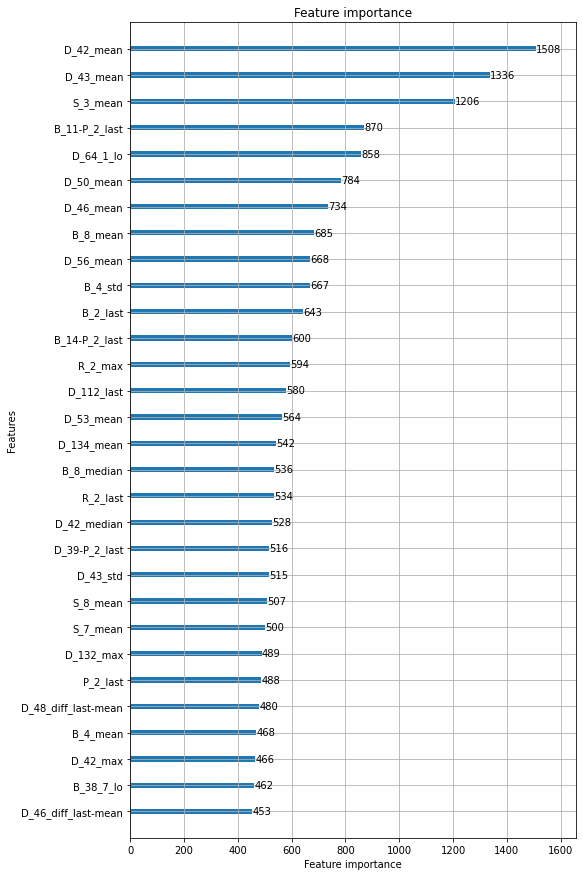

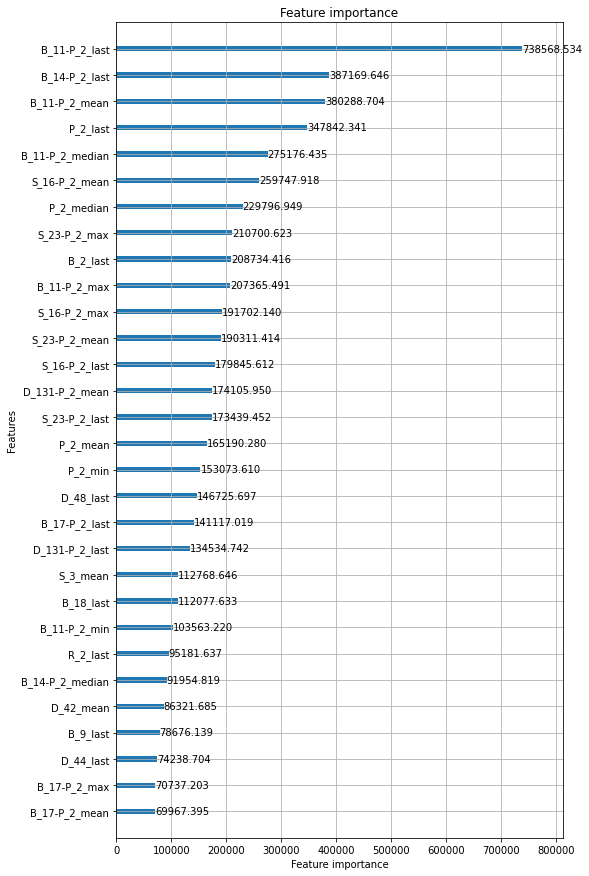

######################################## training model 2/5 ########################################
seed: 1


[50]	valid_0's amex_metric: 0.748037	valid_0's recall_at4: 0.596314	valid_0's norm_gini: 0.899761


[100]	valid_0's amex_metric: 0.757676	valid_0's recall_at4: 0.610999	valid_0's norm_gini: 0.904354


[150]	valid_0's amex_metric: 0.761522	valid_0's recall_at4: 0.616427	valid_0's norm_gini: 0.906617


[200]	valid_0's amex_metric: 0.764591	valid_0's recall_at4: 0.620466	valid_0's norm_gini: 0.908716


[250]	valid_0's amex_metric: 0.768155	valid_0's recall_at4: 0.62602	valid_0's norm_gini: 0.910289


[300]	valid_0's amex_metric: 0.771262	valid_0's recall_at4: 0.630481	valid_0's norm_gini: 0.912044


[350]	valid_0's amex_metric: 0.772297	valid_0's recall_at4: 0.631701	valid_0's norm_gini: 0.912894


[400]	valid_0's amex_metric: 0.774829	valid_0's recall_at4: 0.635488	valid_0's norm_gini: 0.914171


[450]	valid_0's amex_metric: 0.776766	valid_0's recall_at4: 0.638054	valid_0's norm_gini: 0.915477


[500]	valid_0's amex_metric: 0.780017	valid_0's recall_at4: 0.643524	valid_0's norm_gini: 0.916509


[550]	valid_0's amex_metric: 0.782849	valid_0's recall_at4: 0.6479	valid_0's norm_gini: 0.917798


[600]	valid_0's amex_metric: 0.784056	valid_0's recall_at4: 0.649878	valid_0's norm_gini: 0.918234


[650]	valid_0's amex_metric: 0.78486	valid_0's recall_at4: 0.651014	valid_0's norm_gini: 0.918705


[700]	valid_0's amex_metric: 0.785018	valid_0's recall_at4: 0.65093	valid_0's norm_gini: 0.919106


[750]	valid_0's amex_metric: 0.785677	valid_0's recall_at4: 0.652108	valid_0's norm_gini: 0.919247


[800]	valid_0's amex_metric: 0.785368	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.919386


[850]	valid_0's amex_metric: 0.785736	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.919617


[900]	valid_0's amex_metric: 0.785936	valid_0's recall_at4: 0.652024	valid_0's norm_gini: 0.919849


[950]	valid_0's amex_metric: 0.786139	valid_0's recall_at4: 0.65215	valid_0's norm_gini: 0.920128


[1000]	valid_0's amex_metric: 0.787434	valid_0's recall_at4: 0.654464	valid_0's norm_gini: 0.920404


[1050]	valid_0's amex_metric: 0.787777	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.92067


[1100]	valid_0's amex_metric: 0.788299	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.920955


[1150]	valid_0's amex_metric: 0.789128	valid_0's recall_at4: 0.657031	valid_0's norm_gini: 0.921225


[1200]	valid_0's amex_metric: 0.788842	valid_0's recall_at4: 0.656274	valid_0's norm_gini: 0.921411


[1250]	valid_0's amex_metric: 0.789054	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.921541


[1300]	valid_0's amex_metric: 0.789806	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.921781


[1350]	valid_0's amex_metric: 0.789676	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.922027


[1400]	valid_0's amex_metric: 0.789791	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922173


[1450]	valid_0's amex_metric: 0.790496	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.922279


[1500]	valid_0's amex_metric: 0.791038	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.922435


[1550]	valid_0's amex_metric: 0.790929	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.922596


[1600]	valid_0's amex_metric: 0.790697	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.92268


[1650]	valid_0's amex_metric: 0.790694	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.9228


[1700]	valid_0's amex_metric: 0.791307	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.922889


[1750]	valid_0's amex_metric: 0.79141	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.922971


[1800]	valid_0's amex_metric: 0.791305	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.923054


[1850]	valid_0's amex_metric: 0.791903	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923157


[1900]	valid_0's amex_metric: 0.791941	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923233


[1950]	valid_0's amex_metric: 0.791612	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.92329


[2000]	valid_0's amex_metric: 0.792462	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.923349


[2050]	valid_0's amex_metric: 0.792415	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.923464


[2100]	valid_0's amex_metric: 0.793027	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.923553


[2150]	valid_0's amex_metric: 0.793129	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.923631


[2200]	valid_0's amex_metric: 0.79344	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.923705


[2250]	valid_0's amex_metric: 0.793521	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923741


[2300]	valid_0's amex_metric: 0.793251	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.923833


[2350]	valid_0's amex_metric: 0.794071	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.923916


[2400]	valid_0's amex_metric: 0.794063	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923985


[2450]	valid_0's amex_metric: 0.7944	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.924068


[2500]	valid_0's amex_metric: 0.794696	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.924113


[2550]	valid_0's amex_metric: 0.79497	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924157


[2600]	valid_0's amex_metric: 0.79501	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924194


[2650]	valid_0's amex_metric: 0.794675	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.924241


[2700]	valid_0's amex_metric: 0.794679	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.92429


[2750]	valid_0's amex_metric: 0.794655	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924326


[2800]	valid_0's amex_metric: 0.794721	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.924374


[2850]	valid_0's amex_metric: 0.795137	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924449


[2900]	valid_0's amex_metric: 0.795173	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924479


[2950]	valid_0's amex_metric: 0.795297	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.924517


[3000]	valid_0's amex_metric: 0.795129	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.92456


[3050]	valid_0's amex_metric: 0.794826	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.924585


[3100]	valid_0's amex_metric: 0.795126	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924596


[3150]	valid_0's amex_metric: 0.794951	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.924624


[3200]	valid_0's amex_metric: 0.795659	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924652


[3250]	valid_0's amex_metric: 0.795548	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924683


[3300]	valid_0's amex_metric: 0.795833	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.924704


[3350]	valid_0's amex_metric: 0.795903	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.924718


[3400]	valid_0's amex_metric: 0.796135	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924761


[3450]	valid_0's amex_metric: 0.795727	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924787


[3500]	valid_0's amex_metric: 0.796166	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924824


[3550]	valid_0's amex_metric: 0.796193	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.924835


[3600]	valid_0's amex_metric: 0.796454	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.924852


[3650]	valid_0's amex_metric: 0.796426	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.924881


[3700]	valid_0's amex_metric: 0.796744	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.924886


[3750]	valid_0's amex_metric: 0.796956	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.924932


[3800]	valid_0's amex_metric: 0.796794	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.924943


[3850]	valid_0's amex_metric: 0.796743	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.924968


[3900]	valid_0's amex_metric: 0.796726	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.924977


[3950]	valid_0's amex_metric: 0.796481	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.92499


[4000]	valid_0's amex_metric: 0.796298	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.925004


[4050]	valid_0's amex_metric: 0.796501	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.92503


[4100]	valid_0's amex_metric: 0.796967	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925038


[4150]	valid_0's amex_metric: 0.797083	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.925059


[4200]	valid_0's amex_metric: 0.797132	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925073


[4250]	valid_0's amex_metric: 0.796722	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925094


[4300]	valid_0's amex_metric: 0.796564	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925114


[4350]	valid_0's amex_metric: 0.796655	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.925128


[4400]	valid_0's amex_metric: 0.796979	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.925146


[4450]	valid_0's amex_metric: 0.797215	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925155


[4500]	valid_0's amex_metric: 0.796947	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.925166


[4550]	valid_0's amex_metric: 0.796596	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925179


[4600]	valid_0's amex_metric: 0.796773	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925197


[4650]	valid_0's amex_metric: 0.796907	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.925211


[4700]	valid_0's amex_metric: 0.797047	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.925238


[4750]	valid_0's amex_metric: 0.79674	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.925256


[4800]	valid_0's amex_metric: 0.796757	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.925291


[4850]	valid_0's amex_metric: 0.796513	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.925308


[4900]	valid_0's amex_metric: 0.796917	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925316


[4950]	valid_0's amex_metric: 0.796926	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925335


[5000]	valid_0's amex_metric: 0.797159	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925336


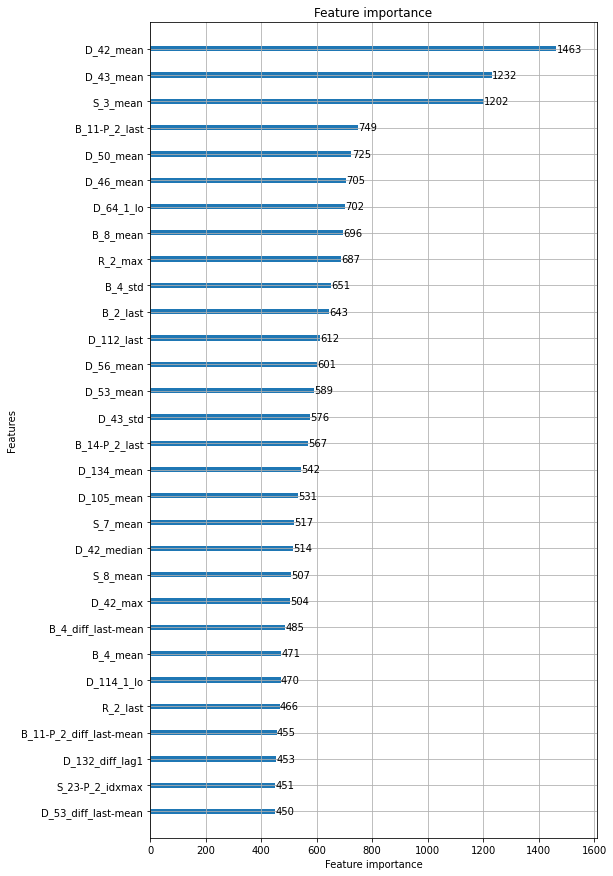

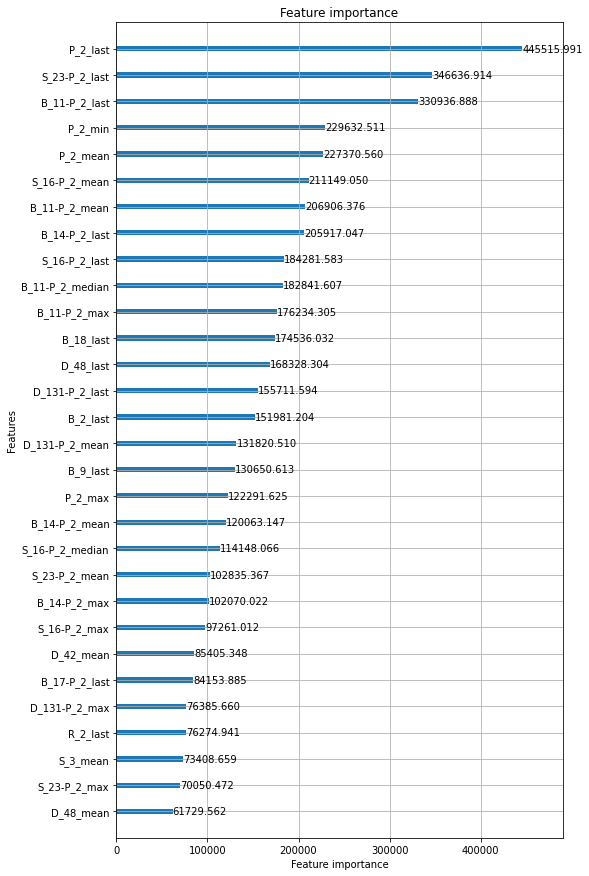

######################################## training model 3/5 ########################################
seed: 2


[50]	valid_0's amex_metric: 0.74481	valid_0's recall_at4: 0.590507	valid_0's norm_gini: 0.899113


[100]	valid_0's amex_metric: 0.748252	valid_0's recall_at4: 0.59543	valid_0's norm_gini: 0.901073


[150]	valid_0's amex_metric: 0.753975	valid_0's recall_at4: 0.603972	valid_0's norm_gini: 0.903979


[200]	valid_0's amex_metric: 0.758217	valid_0's recall_at4: 0.610452	valid_0's norm_gini: 0.905983


[250]	valid_0's amex_metric: 0.758924	valid_0's recall_at4: 0.611336	valid_0's norm_gini: 0.906512


[300]	valid_0's amex_metric: 0.762949	valid_0's recall_at4: 0.617395	valid_0's norm_gini: 0.908503


[350]	valid_0's amex_metric: 0.765026	valid_0's recall_at4: 0.62013	valid_0's norm_gini: 0.909923


[400]	valid_0's amex_metric: 0.767993	valid_0's recall_at4: 0.62459	valid_0's norm_gini: 0.911396


[450]	valid_0's amex_metric: 0.769301	valid_0's recall_at4: 0.626105	valid_0's norm_gini: 0.912498


[500]	valid_0's amex_metric: 0.771141	valid_0's recall_at4: 0.628713	valid_0's norm_gini: 0.913569


[550]	valid_0's amex_metric: 0.770849	valid_0's recall_at4: 0.627956	valid_0's norm_gini: 0.913741


[600]	valid_0's amex_metric: 0.771425	valid_0's recall_at4: 0.628503	valid_0's norm_gini: 0.914347


[650]	valid_0's amex_metric: 0.773457	valid_0's recall_at4: 0.631785	valid_0's norm_gini: 0.915128


[700]	valid_0's amex_metric: 0.774975	valid_0's recall_at4: 0.634015	valid_0's norm_gini: 0.915935


[750]	valid_0's amex_metric: 0.776416	valid_0's recall_at4: 0.636329	valid_0's norm_gini: 0.916503


[800]	valid_0's amex_metric: 0.777957	valid_0's recall_at4: 0.638854	valid_0's norm_gini: 0.91706


[850]	valid_0's amex_metric: 0.779278	valid_0's recall_at4: 0.641126	valid_0's norm_gini: 0.91743


[900]	valid_0's amex_metric: 0.779079	valid_0's recall_at4: 0.640411	valid_0's norm_gini: 0.917748


[950]	valid_0's amex_metric: 0.780105	valid_0's recall_at4: 0.64201	valid_0's norm_gini: 0.918201


[1000]	valid_0's amex_metric: 0.781465	valid_0's recall_at4: 0.644324	valid_0's norm_gini: 0.918607


[1050]	valid_0's amex_metric: 0.782305	valid_0's recall_at4: 0.645628	valid_0's norm_gini: 0.918982


[1100]	valid_0's amex_metric: 0.782903	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.919337


[1150]	valid_0's amex_metric: 0.78306	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.919651


[1200]	valid_0's amex_metric: 0.783506	valid_0's recall_at4: 0.647185	valid_0's norm_gini: 0.919827


[1250]	valid_0's amex_metric: 0.783631	valid_0's recall_at4: 0.647269	valid_0's norm_gini: 0.919992


[1300]	valid_0's amex_metric: 0.784368	valid_0's recall_at4: 0.648574	valid_0's norm_gini: 0.920162


[1350]	valid_0's amex_metric: 0.784348	valid_0's recall_at4: 0.648363	valid_0's norm_gini: 0.920332


[1400]	valid_0's amex_metric: 0.784929	valid_0's recall_at4: 0.649373	valid_0's norm_gini: 0.920486


[1450]	valid_0's amex_metric: 0.785263	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.92069


[1500]	valid_0's amex_metric: 0.786435	valid_0's recall_at4: 0.65194	valid_0's norm_gini: 0.92093


[1550]	valid_0's amex_metric: 0.786109	valid_0's recall_at4: 0.65114	valid_0's norm_gini: 0.921078


[1600]	valid_0's amex_metric: 0.786596	valid_0's recall_at4: 0.652024	valid_0's norm_gini: 0.921167


[1650]	valid_0's amex_metric: 0.786856	valid_0's recall_at4: 0.652403	valid_0's norm_gini: 0.921309


[1700]	valid_0's amex_metric: 0.786727	valid_0's recall_at4: 0.652024	valid_0's norm_gini: 0.92143


[1750]	valid_0's amex_metric: 0.787332	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.921546


[1800]	valid_0's amex_metric: 0.787626	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.921671


[1850]	valid_0's amex_metric: 0.787874	valid_0's recall_at4: 0.654002	valid_0's norm_gini: 0.921746


[1900]	valid_0's amex_metric: 0.787708	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.921836


[1950]	valid_0's amex_metric: 0.788598	valid_0's recall_at4: 0.655306	valid_0's norm_gini: 0.921891


[2000]	valid_0's amex_metric: 0.788429	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.921974


[2050]	valid_0's amex_metric: 0.788726	valid_0's recall_at4: 0.655432	valid_0's norm_gini: 0.922019


[2100]	valid_0's amex_metric: 0.789129	valid_0's recall_at4: 0.65619	valid_0's norm_gini: 0.922069


[2150]	valid_0's amex_metric: 0.788747	valid_0's recall_at4: 0.655348	valid_0's norm_gini: 0.922147


[2200]	valid_0's amex_metric: 0.788401	valid_0's recall_at4: 0.654633	valid_0's norm_gini: 0.922168


[2250]	valid_0's amex_metric: 0.788764	valid_0's recall_at4: 0.655306	valid_0's norm_gini: 0.922222


[2300]	valid_0's amex_metric: 0.788636	valid_0's recall_at4: 0.655011	valid_0's norm_gini: 0.92226


[2350]	valid_0's amex_metric: 0.789389	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.922336


[2400]	valid_0's amex_metric: 0.789477	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922385


[2450]	valid_0's amex_metric: 0.78908	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.922433


[2500]	valid_0's amex_metric: 0.789117	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.922507


[2550]	valid_0's amex_metric: 0.789332	valid_0's recall_at4: 0.656105	valid_0's norm_gini: 0.92256


[2600]	valid_0's amex_metric: 0.78978	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.922613


[2650]	valid_0's amex_metric: 0.789711	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.922642


[2700]	valid_0's amex_metric: 0.790198	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.922691


[2750]	valid_0's amex_metric: 0.790074	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922738


[2800]	valid_0's amex_metric: 0.790237	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.922771


[2850]	valid_0's amex_metric: 0.790443	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.922802


[2900]	valid_0's amex_metric: 0.790167	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.92284


[2950]	valid_0's amex_metric: 0.790657	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.922894


[3000]	valid_0's amex_metric: 0.790653	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.922928


[3050]	valid_0's amex_metric: 0.790613	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.922975


[3100]	valid_0's amex_metric: 0.790255	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.923016


[3150]	valid_0's amex_metric: 0.790445	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.923018


[3200]	valid_0's amex_metric: 0.790645	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923039


[3250]	valid_0's amex_metric: 0.790361	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.923061


[3300]	valid_0's amex_metric: 0.790585	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.923087


[3350]	valid_0's amex_metric: 0.790802	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.9231


[3400]	valid_0's amex_metric: 0.791201	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.923099


[3450]	valid_0's amex_metric: 0.791105	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923118


[3500]	valid_0's amex_metric: 0.791091	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.923131


[3550]	valid_0's amex_metric: 0.791249	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.923153


[3600]	valid_0's amex_metric: 0.79146	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.923196


[3650]	valid_0's amex_metric: 0.791776	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.923239


[3700]	valid_0's amex_metric: 0.79151	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.923255


[3750]	valid_0's amex_metric: 0.791606	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923278


[3800]	valid_0's amex_metric: 0.791367	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.923305


[3850]	valid_0's amex_metric: 0.791009	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.923346


[3900]	valid_0's amex_metric: 0.791565	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.923363


[3950]	valid_0's amex_metric: 0.791449	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923385


[4000]	valid_0's amex_metric: 0.79139	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.923394


[4050]	valid_0's amex_metric: 0.791663	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923391


[4100]	valid_0's amex_metric: 0.791751	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923399


[4150]	valid_0's amex_metric: 0.791467	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.92342


[4200]	valid_0's amex_metric: 0.791915	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923433


[4250]	valid_0's amex_metric: 0.792111	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923446


[4300]	valid_0's amex_metric: 0.791973	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.923465


[4350]	valid_0's amex_metric: 0.791995	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923467


[4400]	valid_0's amex_metric: 0.792226	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923466


[4450]	valid_0's amex_metric: 0.792276	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.923481


[4500]	valid_0's amex_metric: 0.792101	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.923511


[4550]	valid_0's amex_metric: 0.792003	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.923525


[4600]	valid_0's amex_metric: 0.792394	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923549


[4650]	valid_0's amex_metric: 0.792189	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.923559


[4700]	valid_0's amex_metric: 0.792175	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923574


[4750]	valid_0's amex_metric: 0.792185	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923594


[4800]	valid_0's amex_metric: 0.7921	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.923593


[4850]	valid_0's amex_metric: 0.791763	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923591


[4900]	valid_0's amex_metric: 0.792002	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923606


[4950]	valid_0's amex_metric: 0.792198	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923621


[5000]	valid_0's amex_metric: 0.792636	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.923612


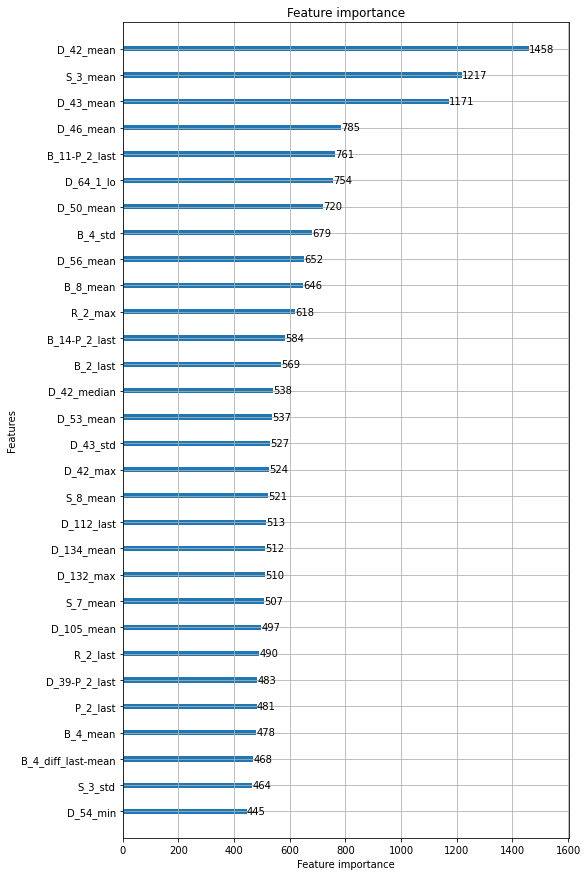

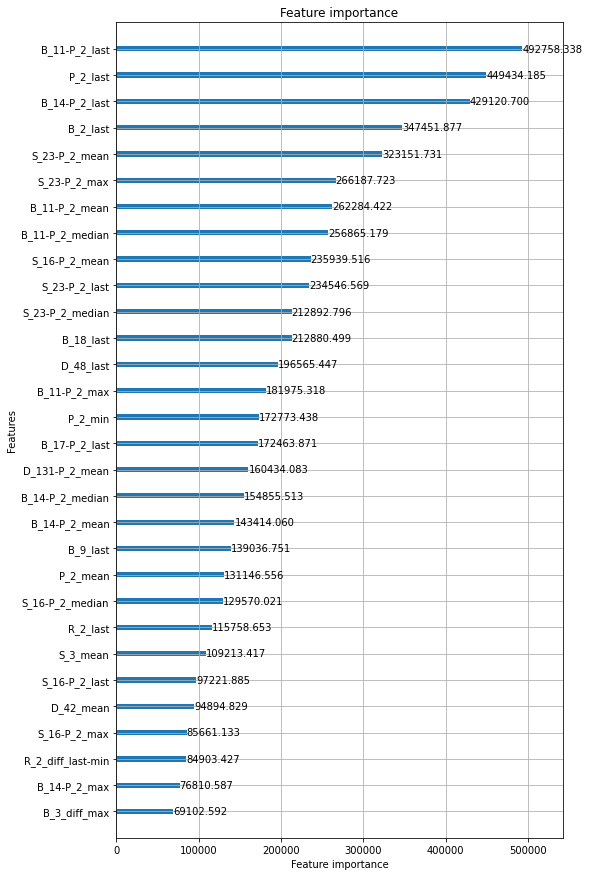

######################################## training model 4/5 ########################################
seed: 3


[50]	valid_0's amex_metric: 0.741133	valid_0's recall_at4: 0.584136	valid_0's norm_gini: 0.89813


[100]	valid_0's amex_metric: 0.750215	valid_0's recall_at4: 0.598696	valid_0's norm_gini: 0.901735


[150]	valid_0's amex_metric: 0.754433	valid_0's recall_at4: 0.604797	valid_0's norm_gini: 0.904068


[200]	valid_0's amex_metric: 0.757858	valid_0's recall_at4: 0.609678	valid_0's norm_gini: 0.906039


[250]	valid_0's amex_metric: 0.763354	valid_0's recall_at4: 0.618052	valid_0's norm_gini: 0.908657


[300]	valid_0's amex_metric: 0.765745	valid_0's recall_at4: 0.621123	valid_0's norm_gini: 0.910366


[350]	valid_0's amex_metric: 0.768944	valid_0's recall_at4: 0.625794	valid_0's norm_gini: 0.912093


[400]	valid_0's amex_metric: 0.772451	valid_0's recall_at4: 0.631096	valid_0's norm_gini: 0.913806


[450]	valid_0's amex_metric: 0.773999	valid_0's recall_at4: 0.633284	valid_0's norm_gini: 0.914714


[500]	valid_0's amex_metric: 0.775526	valid_0's recall_at4: 0.635557	valid_0's norm_gini: 0.915496


[550]	valid_0's amex_metric: 0.776564	valid_0's recall_at4: 0.636903	valid_0's norm_gini: 0.916225


[600]	valid_0's amex_metric: 0.777826	valid_0's recall_at4: 0.638502	valid_0's norm_gini: 0.91715


[650]	valid_0's amex_metric: 0.778382	valid_0's recall_at4: 0.639386	valid_0's norm_gini: 0.917378


[700]	valid_0's amex_metric: 0.779561	valid_0's recall_at4: 0.64149	valid_0's norm_gini: 0.917633


[750]	valid_0's amex_metric: 0.780602	valid_0's recall_at4: 0.643131	valid_0's norm_gini: 0.918074


[800]	valid_0's amex_metric: 0.781362	valid_0's recall_at4: 0.644477	valid_0's norm_gini: 0.918247


[850]	valid_0's amex_metric: 0.781723	valid_0's recall_at4: 0.644982	valid_0's norm_gini: 0.918465


[900]	valid_0's amex_metric: 0.782962	valid_0's recall_at4: 0.647128	valid_0's norm_gini: 0.918796


[950]	valid_0's amex_metric: 0.783316	valid_0's recall_at4: 0.647633	valid_0's norm_gini: 0.918999


[1000]	valid_0's amex_metric: 0.783548	valid_0's recall_at4: 0.647886	valid_0's norm_gini: 0.919211


[1050]	valid_0's amex_metric: 0.784133	valid_0's recall_at4: 0.648727	valid_0's norm_gini: 0.919538


[1100]	valid_0's amex_metric: 0.784376	valid_0's recall_at4: 0.649022	valid_0's norm_gini: 0.91973


[1150]	valid_0's amex_metric: 0.783923	valid_0's recall_at4: 0.647928	valid_0's norm_gini: 0.919919


[1200]	valid_0's amex_metric: 0.784094	valid_0's recall_at4: 0.648138	valid_0's norm_gini: 0.92005


[1250]	valid_0's amex_metric: 0.784858	valid_0's recall_at4: 0.649485	valid_0's norm_gini: 0.920232


[1300]	valid_0's amex_metric: 0.785065	valid_0's recall_at4: 0.649737	valid_0's norm_gini: 0.920393


[1350]	valid_0's amex_metric: 0.785764	valid_0's recall_at4: 0.650915	valid_0's norm_gini: 0.920613


[1400]	valid_0's amex_metric: 0.785761	valid_0's recall_at4: 0.650663	valid_0's norm_gini: 0.920859


[1450]	valid_0's amex_metric: 0.786027	valid_0's recall_at4: 0.650999	valid_0's norm_gini: 0.921055


[1500]	valid_0's amex_metric: 0.785999	valid_0's recall_at4: 0.650831	valid_0's norm_gini: 0.921167


[1550]	valid_0's amex_metric: 0.786245	valid_0's recall_at4: 0.651168	valid_0's norm_gini: 0.921322


[1600]	valid_0's amex_metric: 0.786153	valid_0's recall_at4: 0.650831	valid_0's norm_gini: 0.921474


[1650]	valid_0's amex_metric: 0.786574	valid_0's recall_at4: 0.651546	valid_0's norm_gini: 0.921601


[1700]	valid_0's amex_metric: 0.787009	valid_0's recall_at4: 0.652304	valid_0's norm_gini: 0.921714


[1750]	valid_0's amex_metric: 0.786723	valid_0's recall_at4: 0.651673	valid_0's norm_gini: 0.921772


[1800]	valid_0's amex_metric: 0.787112	valid_0's recall_at4: 0.652262	valid_0's norm_gini: 0.921962


[1850]	valid_0's amex_metric: 0.787503	valid_0's recall_at4: 0.652893	valid_0's norm_gini: 0.922112


[1900]	valid_0's amex_metric: 0.787223	valid_0's recall_at4: 0.652262	valid_0's norm_gini: 0.922185


[1950]	valid_0's amex_metric: 0.787345	valid_0's recall_at4: 0.65243	valid_0's norm_gini: 0.92226


[2000]	valid_0's amex_metric: 0.78777	valid_0's recall_at4: 0.653187	valid_0's norm_gini: 0.922353


[2050]	valid_0's amex_metric: 0.787355	valid_0's recall_at4: 0.652304	valid_0's norm_gini: 0.922407


[2100]	valid_0's amex_metric: 0.787034	valid_0's recall_at4: 0.651631	valid_0's norm_gini: 0.922437


[2150]	valid_0's amex_metric: 0.787337	valid_0's recall_at4: 0.652178	valid_0's norm_gini: 0.922497


[2200]	valid_0's amex_metric: 0.787353	valid_0's recall_at4: 0.652135	valid_0's norm_gini: 0.922571


[2250]	valid_0's amex_metric: 0.787865	valid_0's recall_at4: 0.653061	valid_0's norm_gini: 0.922668


[2300]	valid_0's amex_metric: 0.787859	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.922742


[2350]	valid_0's amex_metric: 0.787916	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.922813


[2400]	valid_0's amex_metric: 0.787734	valid_0's recall_at4: 0.652556	valid_0's norm_gini: 0.922912


[2450]	valid_0's amex_metric: 0.787753	valid_0's recall_at4: 0.652514	valid_0's norm_gini: 0.922992


[2500]	valid_0's amex_metric: 0.788285	valid_0's recall_at4: 0.653482	valid_0's norm_gini: 0.923087


[2550]	valid_0's amex_metric: 0.788625	valid_0's recall_at4: 0.654113	valid_0's norm_gini: 0.923136


[2600]	valid_0's amex_metric: 0.788634	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.923196


[2650]	valid_0's amex_metric: 0.788669	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.923267


[2700]	valid_0's amex_metric: 0.789098	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.923284


[2750]	valid_0's amex_metric: 0.788646	valid_0's recall_at4: 0.653987	valid_0's norm_gini: 0.923306


[2800]	valid_0's amex_metric: 0.788713	valid_0's recall_at4: 0.654113	valid_0's norm_gini: 0.923314


[2850]	valid_0's amex_metric: 0.788938	valid_0's recall_at4: 0.654534	valid_0's norm_gini: 0.923342


[2900]	valid_0's amex_metric: 0.789427	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.923395


[2950]	valid_0's amex_metric: 0.789602	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.923449


[3000]	valid_0's amex_metric: 0.789333	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.923459


[3050]	valid_0's amex_metric: 0.789576	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.923523


[3100]	valid_0's amex_metric: 0.789228	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.923544


[3150]	valid_0's amex_metric: 0.789634	valid_0's recall_at4: 0.65567	valid_0's norm_gini: 0.923598


[3200]	valid_0's amex_metric: 0.789824	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.923642


[3250]	valid_0's amex_metric: 0.78969	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.923667


[3300]	valid_0's amex_metric: 0.790132	valid_0's recall_at4: 0.656554	valid_0's norm_gini: 0.92371


[3350]	valid_0's amex_metric: 0.790286	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.923724


[3400]	valid_0's amex_metric: 0.789832	valid_0's recall_at4: 0.655923	valid_0's norm_gini: 0.923741


[3450]	valid_0's amex_metric: 0.790178	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.923761


[3500]	valid_0's amex_metric: 0.789567	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.9238


[3550]	valid_0's amex_metric: 0.789385	valid_0's recall_at4: 0.654955	valid_0's norm_gini: 0.923815


[3600]	valid_0's amex_metric: 0.789609	valid_0's recall_at4: 0.655376	valid_0's norm_gini: 0.923843


[3650]	valid_0's amex_metric: 0.789704	valid_0's recall_at4: 0.655544	valid_0's norm_gini: 0.923863


[3700]	valid_0's amex_metric: 0.789831	valid_0's recall_at4: 0.655796	valid_0's norm_gini: 0.923865


[3750]	valid_0's amex_metric: 0.790124	valid_0's recall_at4: 0.656343	valid_0's norm_gini: 0.923906


[3800]	valid_0's amex_metric: 0.790404	valid_0's recall_at4: 0.65689	valid_0's norm_gini: 0.923917


[3850]	valid_0's amex_metric: 0.790179	valid_0's recall_at4: 0.656428	valid_0's norm_gini: 0.92393


[3900]	valid_0's amex_metric: 0.790101	valid_0's recall_at4: 0.656259	valid_0's norm_gini: 0.923942


[3950]	valid_0's amex_metric: 0.789646	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.923959


[4000]	valid_0's amex_metric: 0.789754	valid_0's recall_at4: 0.655544	valid_0's norm_gini: 0.923965


[4050]	valid_0's amex_metric: 0.790108	valid_0's recall_at4: 0.656259	valid_0's norm_gini: 0.923956


[4100]	valid_0's amex_metric: 0.790384	valid_0's recall_at4: 0.656806	valid_0's norm_gini: 0.923961


[4150]	valid_0's amex_metric: 0.79015	valid_0's recall_at4: 0.656301	valid_0's norm_gini: 0.923999


[4200]	valid_0's amex_metric: 0.790684	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.924014


[4250]	valid_0's amex_metric: 0.791152	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.924026


[4300]	valid_0's amex_metric: 0.791371	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.924043


[4350]	valid_0's amex_metric: 0.790835	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.924064


[4400]	valid_0's amex_metric: 0.791297	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.924104


[4450]	valid_0's amex_metric: 0.791231	valid_0's recall_at4: 0.658363	valid_0's norm_gini: 0.924099


[4500]	valid_0's amex_metric: 0.791618	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924116


[4550]	valid_0's amex_metric: 0.791648	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.924133


[4600]	valid_0's amex_metric: 0.792039	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.924157


[4650]	valid_0's amex_metric: 0.791423	valid_0's recall_at4: 0.658658	valid_0's norm_gini: 0.924188


[4700]	valid_0's amex_metric: 0.791828	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.9242


[4750]	valid_0's amex_metric: 0.792086	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924209


[4800]	valid_0's amex_metric: 0.792322	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.924219


[4850]	valid_0's amex_metric: 0.792154	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.92422


[4900]	valid_0's amex_metric: 0.791885	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.924228


[4950]	valid_0's amex_metric: 0.792109	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924256


[5000]	valid_0's amex_metric: 0.792184	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.924279


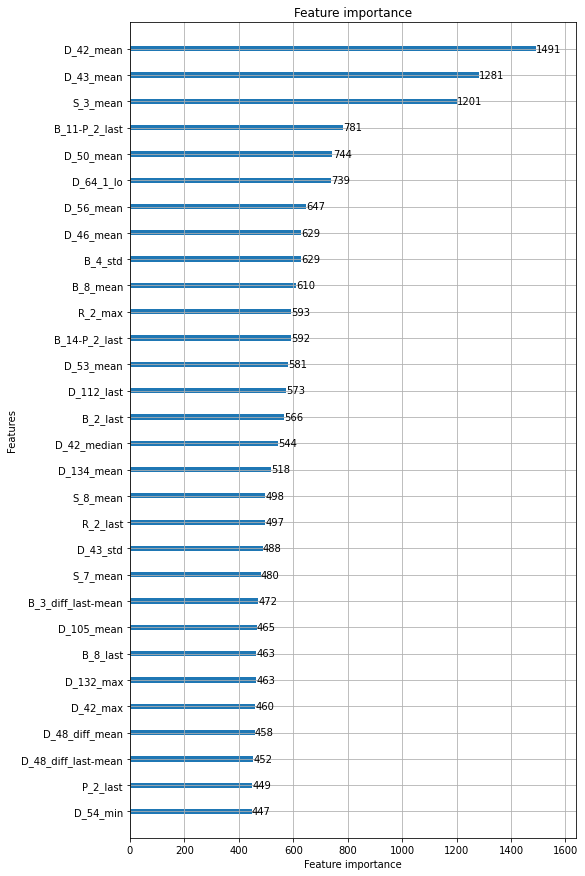

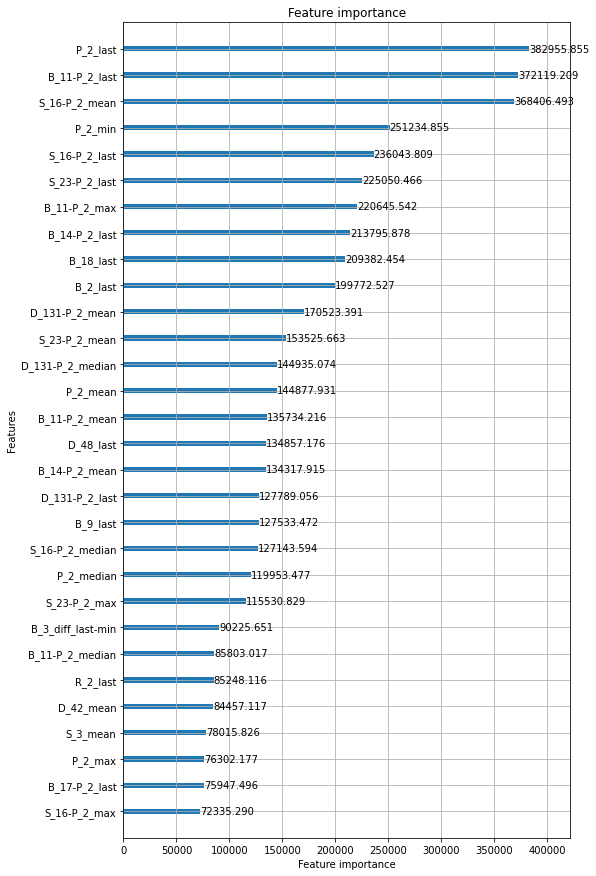

######################################## training model 5/5 ########################################
seed: 4


[50]	valid_0's amex_metric: 0.752347	valid_0's recall_at4: 0.603366	valid_0's norm_gini: 0.901328


[100]	valid_0's amex_metric: 0.756786	valid_0's recall_at4: 0.609131	valid_0's norm_gini: 0.90444


[150]	valid_0's amex_metric: 0.76349	valid_0's recall_at4: 0.619482	valid_0's norm_gini: 0.907497


[200]	valid_0's amex_metric: 0.767412	valid_0's recall_at4: 0.625458	valid_0's norm_gini: 0.909366


[250]	valid_0's amex_metric: 0.771298	valid_0's recall_at4: 0.630802	valid_0's norm_gini: 0.911795


[300]	valid_0's amex_metric: 0.776534	valid_0's recall_at4: 0.638544	valid_0's norm_gini: 0.914523


[350]	valid_0's amex_metric: 0.779673	valid_0's recall_at4: 0.642962	valid_0's norm_gini: 0.916383


[400]	valid_0's amex_metric: 0.781068	valid_0's recall_at4: 0.645319	valid_0's norm_gini: 0.916818


[450]	valid_0's amex_metric: 0.782471	valid_0's recall_at4: 0.647086	valid_0's norm_gini: 0.917856


[500]	valid_0's amex_metric: 0.783632	valid_0's recall_at4: 0.648938	valid_0's norm_gini: 0.918326


[550]	valid_0's amex_metric: 0.784128	valid_0's recall_at4: 0.649611	valid_0's norm_gini: 0.918644


[600]	valid_0's amex_metric: 0.78565	valid_0's recall_at4: 0.652093	valid_0's norm_gini: 0.919207


[650]	valid_0's amex_metric: 0.787866	valid_0's recall_at4: 0.655586	valid_0's norm_gini: 0.920145


[700]	valid_0's amex_metric: 0.788138	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.920564


[750]	valid_0's amex_metric: 0.788412	valid_0's recall_at4: 0.655923	valid_0's norm_gini: 0.920901


[800]	valid_0's amex_metric: 0.790162	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.921414


[850]	valid_0's amex_metric: 0.790608	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.921927


[900]	valid_0's amex_metric: 0.790885	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.922355


[950]	valid_0's amex_metric: 0.791682	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.922561


[1000]	valid_0's amex_metric: 0.79235	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.922845


[1050]	valid_0's amex_metric: 0.792513	valid_0's recall_at4: 0.66194	valid_0's norm_gini: 0.923086


[1100]	valid_0's amex_metric: 0.792561	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.923224


[1150]	valid_0's amex_metric: 0.793416	valid_0's recall_at4: 0.663497	valid_0's norm_gini: 0.923335


[1200]	valid_0's amex_metric: 0.793027	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923567


[1250]	valid_0's amex_metric: 0.794283	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.923764


[1300]	valid_0's amex_metric: 0.794977	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.923848


[1350]	valid_0's amex_metric: 0.794838	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924034


[1400]	valid_0's amex_metric: 0.795067	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.924197


[1450]	valid_0's amex_metric: 0.795352	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.924304


[1500]	valid_0's amex_metric: 0.795482	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.924437


[1550]	valid_0's amex_metric: 0.79606	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924583


[1600]	valid_0's amex_metric: 0.796231	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.924758


[1650]	valid_0's amex_metric: 0.796516	valid_0's recall_at4: 0.668041	valid_0's norm_gini: 0.92499


[1700]	valid_0's amex_metric: 0.796768	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925158


[1750]	valid_0's amex_metric: 0.796875	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.925246


[1800]	valid_0's amex_metric: 0.797292	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925364


[1850]	valid_0's amex_metric: 0.797161	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925482


[1900]	valid_0's amex_metric: 0.797698	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.925588


[1950]	valid_0's amex_metric: 0.797941	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.925694


[2000]	valid_0's amex_metric: 0.798172	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.925777


[2050]	valid_0's amex_metric: 0.798791	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.925839


[2100]	valid_0's amex_metric: 0.799165	valid_0's recall_at4: 0.672375	valid_0's norm_gini: 0.925955


[2150]	valid_0's amex_metric: 0.799218	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.926018


[2200]	valid_0's amex_metric: 0.799425	valid_0's recall_at4: 0.672754	valid_0's norm_gini: 0.926096


[2250]	valid_0's amex_metric: 0.799796	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.926123


[2300]	valid_0's amex_metric: 0.799803	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926178


[2350]	valid_0's amex_metric: 0.799684	valid_0's recall_at4: 0.673133	valid_0's norm_gini: 0.926235


[2400]	valid_0's amex_metric: 0.80017	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.926282


[2450]	valid_0's amex_metric: 0.800467	valid_0's recall_at4: 0.674605	valid_0's norm_gini: 0.926329


[2500]	valid_0's amex_metric: 0.800318	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.926367


[2550]	valid_0's amex_metric: 0.800306	valid_0's recall_at4: 0.674185	valid_0's norm_gini: 0.926428


[2600]	valid_0's amex_metric: 0.800366	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.926464


[2650]	valid_0's amex_metric: 0.799918	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.926493


[2700]	valid_0's amex_metric: 0.800342	valid_0's recall_at4: 0.674143	valid_0's norm_gini: 0.926542


[2750]	valid_0's amex_metric: 0.800217	valid_0's recall_at4: 0.673848	valid_0's norm_gini: 0.926586


[2800]	valid_0's amex_metric: 0.800023	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926619


[2850]	valid_0's amex_metric: 0.800089	valid_0's recall_at4: 0.673511	valid_0's norm_gini: 0.926667


[2900]	valid_0's amex_metric: 0.800673	valid_0's recall_at4: 0.674648	valid_0's norm_gini: 0.926699


[2950]	valid_0's amex_metric: 0.800837	valid_0's recall_at4: 0.674942	valid_0's norm_gini: 0.926732


[3000]	valid_0's amex_metric: 0.800701	valid_0's recall_at4: 0.674648	valid_0's norm_gini: 0.926755


[3050]	valid_0's amex_metric: 0.800632	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.926785


[3100]	valid_0's amex_metric: 0.800658	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.926794


[3150]	valid_0's amex_metric: 0.800684	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.926847


[3200]	valid_0's amex_metric: 0.800448	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.926879


[3250]	valid_0's amex_metric: 0.800716	valid_0's recall_at4: 0.674563	valid_0's norm_gini: 0.926869


[3300]	valid_0's amex_metric: 0.800667	valid_0's recall_at4: 0.674437	valid_0's norm_gini: 0.926897


[3350]	valid_0's amex_metric: 0.800879	valid_0's recall_at4: 0.674816	valid_0's norm_gini: 0.926942


[3400]	valid_0's amex_metric: 0.800989	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.926952


[3450]	valid_0's amex_metric: 0.800959	valid_0's recall_at4: 0.674942	valid_0's norm_gini: 0.926975


[3500]	valid_0's amex_metric: 0.80089	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.927007


[3550]	valid_0's amex_metric: 0.800956	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927013


[3600]	valid_0's amex_metric: 0.800934	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.92701


[3650]	valid_0's amex_metric: 0.801255	valid_0's recall_at4: 0.675489	valid_0's norm_gini: 0.92702


[3700]	valid_0's amex_metric: 0.801379	valid_0's recall_at4: 0.6757	valid_0's norm_gini: 0.927059


[3750]	valid_0's amex_metric: 0.801383	valid_0's recall_at4: 0.6757	valid_0's norm_gini: 0.927067


[3800]	valid_0's amex_metric: 0.801515	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927079


[3850]	valid_0's amex_metric: 0.80183	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.927077


[3900]	valid_0's amex_metric: 0.801584	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.927089


[3950]	valid_0's amex_metric: 0.801402	valid_0's recall_at4: 0.6757	valid_0's norm_gini: 0.927105


[4000]	valid_0's amex_metric: 0.801219	valid_0's recall_at4: 0.675321	valid_0's norm_gini: 0.927117


[4050]	valid_0's amex_metric: 0.800983	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.927109


[4100]	valid_0's amex_metric: 0.801047	valid_0's recall_at4: 0.674984	valid_0's norm_gini: 0.927109


[4150]	valid_0's amex_metric: 0.801322	valid_0's recall_at4: 0.675531	valid_0's norm_gini: 0.927113


[4200]	valid_0's amex_metric: 0.800999	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.927139


[4250]	valid_0's amex_metric: 0.801008	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.927159


[4300]	valid_0's amex_metric: 0.800896	valid_0's recall_at4: 0.674605	valid_0's norm_gini: 0.927187


[4350]	valid_0's amex_metric: 0.801194	valid_0's recall_at4: 0.675195	valid_0's norm_gini: 0.927194


[4400]	valid_0's amex_metric: 0.801403	valid_0's recall_at4: 0.675573	valid_0's norm_gini: 0.927232


[4450]	valid_0's amex_metric: 0.80172	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.927278


[4500]	valid_0's amex_metric: 0.801988	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.927309


[4550]	valid_0's amex_metric: 0.801527	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.927312


[4600]	valid_0's amex_metric: 0.801532	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.927323


[4650]	valid_0's amex_metric: 0.801852	valid_0's recall_at4: 0.676373	valid_0's norm_gini: 0.927331


[4700]	valid_0's amex_metric: 0.801636	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927321


[4750]	valid_0's amex_metric: 0.802061	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927328


[4800]	valid_0's amex_metric: 0.802239	valid_0's recall_at4: 0.67713	valid_0's norm_gini: 0.927348


[4850]	valid_0's amex_metric: 0.802384	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927343


[4900]	valid_0's amex_metric: 0.802497	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927358


[4950]	valid_0's amex_metric: 0.803078	valid_0's recall_at4: 0.678771	valid_0's norm_gini: 0.927384


[5000]	valid_0's amex_metric: 0.802956	valid_0's recall_at4: 0.678519	valid_0's norm_gini: 0.927392


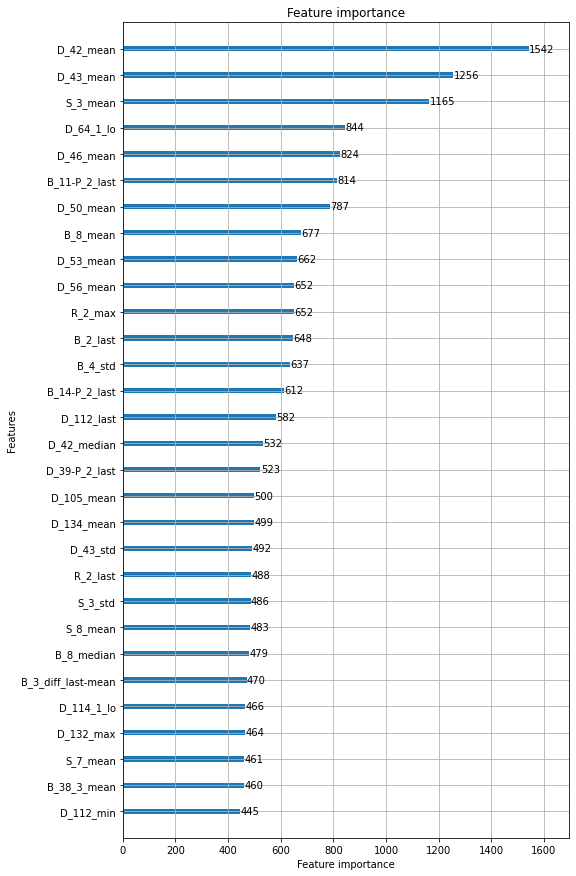

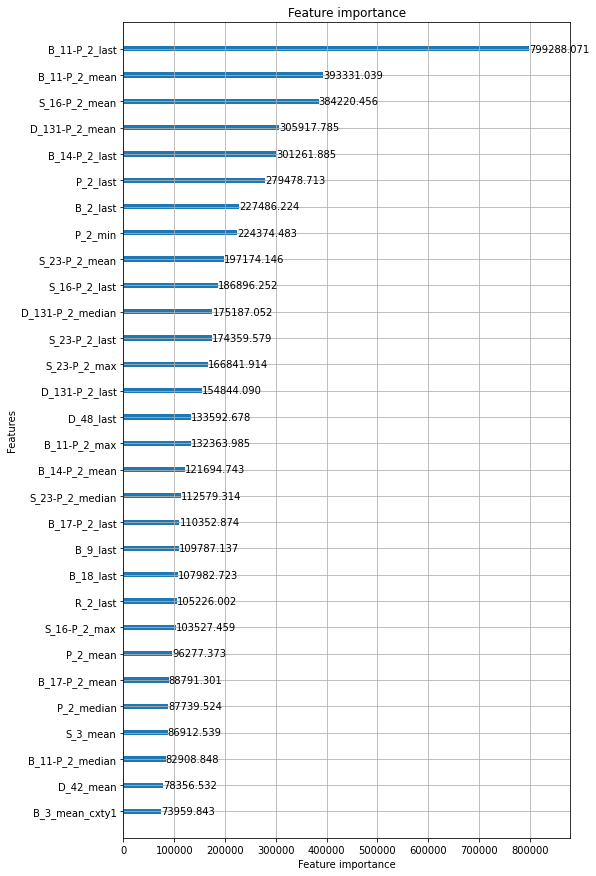

Training time: 72.98644540309905 min.


OOF recall_at4: 0.6663496818931565


OOF normalized_gini: 0.9250565613988367


OOF competition metric: 0.7957031216459967


############################### repeated cross-validation step: 2/5 ################################


######################################## training model 1/5 ########################################
seed: 5


[50]	valid_0's amex_metric: 0.750783	valid_0's recall_at4: 0.600143	valid_0's norm_gini: 0.901422


[100]	valid_0's amex_metric: 0.760262	valid_0's recall_at4: 0.614491	valid_0's norm_gini: 0.906032


[150]	valid_0's amex_metric: 0.763769	valid_0's recall_at4: 0.619877	valid_0's norm_gini: 0.90766


[200]	valid_0's amex_metric: 0.767664	valid_0's recall_at4: 0.625642	valid_0's norm_gini: 0.909687


[250]	valid_0's amex_metric: 0.771388	valid_0's recall_at4: 0.631364	valid_0's norm_gini: 0.911413


[300]	valid_0's amex_metric: 0.774707	valid_0's recall_at4: 0.636161	valid_0's norm_gini: 0.913253


[350]	valid_0's amex_metric: 0.776969	valid_0's recall_at4: 0.639443	valid_0's norm_gini: 0.914495


[400]	valid_0's amex_metric: 0.778597	valid_0's recall_at4: 0.641252	valid_0's norm_gini: 0.915941


[450]	valid_0's amex_metric: 0.780808	valid_0's recall_at4: 0.644913	valid_0's norm_gini: 0.916703


[500]	valid_0's amex_metric: 0.781949	valid_0's recall_at4: 0.646428	valid_0's norm_gini: 0.91747


[550]	valid_0's amex_metric: 0.783591	valid_0's recall_at4: 0.64891	valid_0's norm_gini: 0.918271


[600]	valid_0's amex_metric: 0.784297	valid_0's recall_at4: 0.649668	valid_0's norm_gini: 0.918927


[650]	valid_0's amex_metric: 0.784549	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.919262


[700]	valid_0's amex_metric: 0.787052	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.920059


[750]	valid_0's amex_metric: 0.788643	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.920761


[800]	valid_0's amex_metric: 0.789937	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.921117


[850]	valid_0's amex_metric: 0.790731	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.921485


[900]	valid_0's amex_metric: 0.790623	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.921649


[950]	valid_0's amex_metric: 0.790434	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.921818


[1000]	valid_0's amex_metric: 0.79192	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922222


[1050]	valid_0's amex_metric: 0.792339	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.92243


[1100]	valid_0's amex_metric: 0.792461	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.922673


[1150]	valid_0's amex_metric: 0.793057	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.922813


[1200]	valid_0's amex_metric: 0.792246	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923085


[1250]	valid_0's amex_metric: 0.792849	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923238


[1300]	valid_0's amex_metric: 0.793394	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.92336


[1350]	valid_0's amex_metric: 0.793511	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923511


[1400]	valid_0's amex_metric: 0.793701	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.923681


[1450]	valid_0's amex_metric: 0.793958	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923773


[1500]	valid_0's amex_metric: 0.794503	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.923938


[1550]	valid_0's amex_metric: 0.79548	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.92404


[1600]	valid_0's amex_metric: 0.794901	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924146


[1650]	valid_0's amex_metric: 0.795248	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924249


[1700]	valid_0's amex_metric: 0.795659	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.924356


[1750]	valid_0's amex_metric: 0.795726	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.924407


[1800]	valid_0's amex_metric: 0.795921	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.924501


[1850]	valid_0's amex_metric: 0.795876	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924623


[1900]	valid_0's amex_metric: 0.796475	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.924685


[1950]	valid_0's amex_metric: 0.796665	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.924728


[2000]	valid_0's amex_metric: 0.796565	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.92478


[2050]	valid_0's amex_metric: 0.796854	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.924854


[2100]	valid_0's amex_metric: 0.797127	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924936


[2150]	valid_0's amex_metric: 0.797138	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925001


[2200]	valid_0's amex_metric: 0.797383	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925027


[2250]	valid_0's amex_metric: 0.797332	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.925052


[2300]	valid_0's amex_metric: 0.797988	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925102


[2350]	valid_0's amex_metric: 0.798399	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925167


[2400]	valid_0's amex_metric: 0.798298	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925216


[2450]	valid_0's amex_metric: 0.79808	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925286


[2500]	valid_0's amex_metric: 0.798528	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.92534


[2550]	valid_0's amex_metric: 0.798545	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925374


[2600]	valid_0's amex_metric: 0.799177	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925419


[2650]	valid_0's amex_metric: 0.799147	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.925484


[2700]	valid_0's amex_metric: 0.799342	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925495


[2750]	valid_0's amex_metric: 0.7995	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.925559


[2800]	valid_0's amex_metric: 0.798833	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925614


[2850]	valid_0's amex_metric: 0.7991	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925643


[2900]	valid_0's amex_metric: 0.798841	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925671


[2950]	valid_0's amex_metric: 0.798682	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925691


[3000]	valid_0's amex_metric: 0.799159	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925761


[3050]	valid_0's amex_metric: 0.799093	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925797


[3100]	valid_0's amex_metric: 0.799114	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925839


[3150]	valid_0's amex_metric: 0.798783	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925851


[3200]	valid_0's amex_metric: 0.799354	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.925897


[3250]	valid_0's amex_metric: 0.799408	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925922


[3300]	valid_0's amex_metric: 0.799911	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.925959


[3350]	valid_0's amex_metric: 0.799839	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.925984


[3400]	valid_0's amex_metric: 0.799798	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926029


[3450]	valid_0's amex_metric: 0.799921	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926064


[3500]	valid_0's amex_metric: 0.799257	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926082


[3550]	valid_0's amex_metric: 0.79905	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.92609


[3600]	valid_0's amex_metric: 0.799151	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926124


[3650]	valid_0's amex_metric: 0.799209	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.926155


[3700]	valid_0's amex_metric: 0.799217	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.92617


[3750]	valid_0's amex_metric: 0.799235	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926165


[3800]	valid_0's amex_metric: 0.799136	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926177


[3850]	valid_0's amex_metric: 0.799587	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.926196


[3900]	valid_0's amex_metric: 0.799306	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926224


[3950]	valid_0's amex_metric: 0.799168	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926241


[4000]	valid_0's amex_metric: 0.79918	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926264


[4050]	valid_0's amex_metric: 0.79942	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926283


[4100]	valid_0's amex_metric: 0.799782	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926292


[4150]	valid_0's amex_metric: 0.799438	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926318


[4200]	valid_0's amex_metric: 0.800038	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.92634


[4250]	valid_0's amex_metric: 0.800306	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926372


[4300]	valid_0's amex_metric: 0.800296	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926393


[4350]	valid_0's amex_metric: 0.800115	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926409


[4400]	valid_0's amex_metric: 0.800517	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.926415


[4450]	valid_0's amex_metric: 0.800649	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.926426


[4500]	valid_0's amex_metric: 0.800569	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.926435


[4550]	valid_0's amex_metric: 0.800517	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926457


[4600]	valid_0's amex_metric: 0.800457	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.926464


[4650]	valid_0's amex_metric: 0.800145	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.92647


[4700]	valid_0's amex_metric: 0.800152	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926485


[4750]	valid_0's amex_metric: 0.800598	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.926492


[4800]	valid_0's amex_metric: 0.800516	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926498


[4850]	valid_0's amex_metric: 0.800653	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.926518


[4900]	valid_0's amex_metric: 0.800069	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926529


[4950]	valid_0's amex_metric: 0.800644	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926544


[5000]	valid_0's amex_metric: 0.800053	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926539


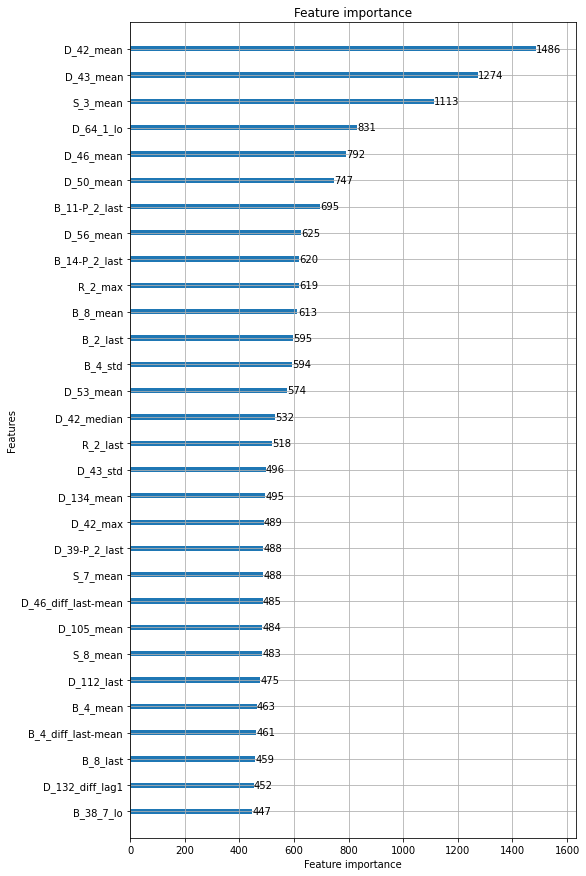

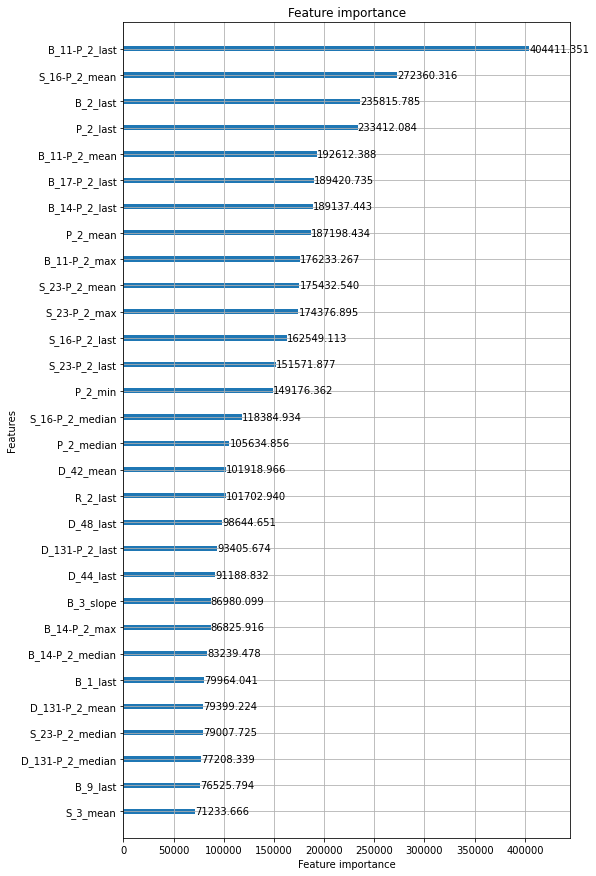

######################################## training model 2/5 ########################################
seed: 6


[50]	valid_0's amex_metric: 0.747679	valid_0's recall_at4: 0.596188	valid_0's norm_gini: 0.899171


[100]	valid_0's amex_metric: 0.756171	valid_0's recall_at4: 0.608558	valid_0's norm_gini: 0.903783


[150]	valid_0's amex_metric: 0.762418	valid_0's recall_at4: 0.617437	valid_0's norm_gini: 0.907399


[200]	valid_0's amex_metric: 0.764014	valid_0's recall_at4: 0.619162	valid_0's norm_gini: 0.908867


[250]	valid_0's amex_metric: 0.766802	valid_0's recall_at4: 0.623327	valid_0's norm_gini: 0.910277


[300]	valid_0's amex_metric: 0.769387	valid_0's recall_at4: 0.626778	valid_0's norm_gini: 0.911996


[350]	valid_0's amex_metric: 0.771344	valid_0's recall_at4: 0.629513	valid_0's norm_gini: 0.913175


[400]	valid_0's amex_metric: 0.772505	valid_0's recall_at4: 0.631322	valid_0's norm_gini: 0.913688


[450]	valid_0's amex_metric: 0.774447	valid_0's recall_at4: 0.634267	valid_0's norm_gini: 0.914627


[500]	valid_0's amex_metric: 0.77629	valid_0's recall_at4: 0.637465	valid_0's norm_gini: 0.915115


[550]	valid_0's amex_metric: 0.775872	valid_0's recall_at4: 0.636497	valid_0's norm_gini: 0.915247


[600]	valid_0's amex_metric: 0.777386	valid_0's recall_at4: 0.638896	valid_0's norm_gini: 0.915876


[650]	valid_0's amex_metric: 0.778237	valid_0's recall_at4: 0.640242	valid_0's norm_gini: 0.916232


[700]	valid_0's amex_metric: 0.779336	valid_0's recall_at4: 0.641925	valid_0's norm_gini: 0.916746


[750]	valid_0's amex_metric: 0.780239	valid_0's recall_at4: 0.643062	valid_0's norm_gini: 0.917417


[800]	valid_0's amex_metric: 0.781567	valid_0's recall_at4: 0.644955	valid_0's norm_gini: 0.918179


[850]	valid_0's amex_metric: 0.782727	valid_0's recall_at4: 0.646722	valid_0's norm_gini: 0.918732


[900]	valid_0's amex_metric: 0.783233	valid_0's recall_at4: 0.647227	valid_0's norm_gini: 0.919238


[950]	valid_0's amex_metric: 0.783598	valid_0's recall_at4: 0.64748	valid_0's norm_gini: 0.919716


[1000]	valid_0's amex_metric: 0.784002	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.919851


[1050]	valid_0's amex_metric: 0.784567	valid_0's recall_at4: 0.64891	valid_0's norm_gini: 0.920224


[1100]	valid_0's amex_metric: 0.784964	valid_0's recall_at4: 0.649457	valid_0's norm_gini: 0.920472


[1150]	valid_0's amex_metric: 0.786182	valid_0's recall_at4: 0.651645	valid_0's norm_gini: 0.920719


[1200]	valid_0's amex_metric: 0.786342	valid_0's recall_at4: 0.651687	valid_0's norm_gini: 0.920998


[1250]	valid_0's amex_metric: 0.786392	valid_0's recall_at4: 0.651645	valid_0's norm_gini: 0.921138


[1300]	valid_0's amex_metric: 0.787283	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921363


[1350]	valid_0's amex_metric: 0.787814	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.921585


[1400]	valid_0's amex_metric: 0.788162	valid_0's recall_at4: 0.654591	valid_0's norm_gini: 0.921734


[1450]	valid_0's amex_metric: 0.788642	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.921811


[1500]	valid_0's amex_metric: 0.788972	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.92188


[1550]	valid_0's amex_metric: 0.789286	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922004


[1600]	valid_0's amex_metric: 0.788947	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.922082


[1650]	valid_0's amex_metric: 0.78866	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.922183


[1700]	valid_0's amex_metric: 0.789421	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922273


[1750]	valid_0's amex_metric: 0.789471	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922373


[1800]	valid_0's amex_metric: 0.789898	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.922429


[1850]	valid_0's amex_metric: 0.789377	valid_0's recall_at4: 0.656274	valid_0's norm_gini: 0.92248


[1900]	valid_0's amex_metric: 0.78982	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.922566


[1950]	valid_0's amex_metric: 0.790146	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.922672


[2000]	valid_0's amex_metric: 0.790067	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922724


[2050]	valid_0's amex_metric: 0.790514	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.922819


[2100]	valid_0's amex_metric: 0.789993	valid_0's recall_at4: 0.657115	valid_0's norm_gini: 0.922872


[2150]	valid_0's amex_metric: 0.789903	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.922943


[2200]	valid_0's amex_metric: 0.790207	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.923005


[2250]	valid_0's amex_metric: 0.790043	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.923097


[2300]	valid_0's amex_metric: 0.790475	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923162


[2350]	valid_0's amex_metric: 0.790994	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.923231


[2400]	valid_0's amex_metric: 0.791164	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.923319


[2450]	valid_0's amex_metric: 0.79117	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.923373


[2500]	valid_0's amex_metric: 0.791609	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.923411


[2550]	valid_0's amex_metric: 0.791011	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.923435


[2600]	valid_0's amex_metric: 0.791567	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.923494


[2650]	valid_0's amex_metric: 0.791819	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923535


[2700]	valid_0's amex_metric: 0.791588	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.923578


[2750]	valid_0's amex_metric: 0.791949	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.923584


[2800]	valid_0's amex_metric: 0.791871	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923639


[2850]	valid_0's amex_metric: 0.791743	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.923678


[2900]	valid_0's amex_metric: 0.791839	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923702


[2950]	valid_0's amex_metric: 0.792161	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923756


[3000]	valid_0's amex_metric: 0.792339	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923777


[3050]	valid_0's amex_metric: 0.791797	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.923785


[3100]	valid_0's amex_metric: 0.792123	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.923807


[3150]	valid_0's amex_metric: 0.792102	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.92385


[3200]	valid_0's amex_metric: 0.791991	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923879


[3250]	valid_0's amex_metric: 0.792236	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923907


[3300]	valid_0's amex_metric: 0.792244	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923923


[3350]	valid_0's amex_metric: 0.792161	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923966


[3400]	valid_0's amex_metric: 0.792027	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.923994


[3450]	valid_0's amex_metric: 0.792072	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.924


[3500]	valid_0's amex_metric: 0.792163	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.924014


[3550]	valid_0's amex_metric: 0.792876	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.924092


[3600]	valid_0's amex_metric: 0.792698	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.924116


[3650]	valid_0's amex_metric: 0.792443	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924151


[3700]	valid_0's amex_metric: 0.792447	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924159


[3750]	valid_0's amex_metric: 0.792518	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.924176


[3800]	valid_0's amex_metric: 0.792335	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.924188


[3850]	valid_0's amex_metric: 0.792352	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.924181


[3900]	valid_0's amex_metric: 0.792642	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.924214


[3950]	valid_0's amex_metric: 0.793011	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924237


[4000]	valid_0's amex_metric: 0.793651	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924254


[4050]	valid_0's amex_metric: 0.793533	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.92427


[4100]	valid_0's amex_metric: 0.793716	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.9243


[4150]	valid_0's amex_metric: 0.793475	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924323


[4200]	valid_0's amex_metric: 0.793712	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924333


[4250]	valid_0's amex_metric: 0.793678	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.924351


[4300]	valid_0's amex_metric: 0.793629	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924378


[4350]	valid_0's amex_metric: 0.793421	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924383


[4400]	valid_0's amex_metric: 0.793608	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.924378


[4450]	valid_0's amex_metric: 0.793728	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924408


[4500]	valid_0's amex_metric: 0.793708	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.92441


[4550]	valid_0's amex_metric: 0.793435	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924411


[4600]	valid_0's amex_metric: 0.793655	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924431


[4650]	valid_0's amex_metric: 0.79349	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.924437


[4700]	valid_0's amex_metric: 0.793793	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924454


[4750]	valid_0's amex_metric: 0.793711	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924459


[4800]	valid_0's amex_metric: 0.793572	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924474


[4850]	valid_0's amex_metric: 0.793453	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.92449


[4900]	valid_0's amex_metric: 0.793369	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924489


[4950]	valid_0's amex_metric: 0.79373	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924496


[5000]	valid_0's amex_metric: 0.793897	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924494


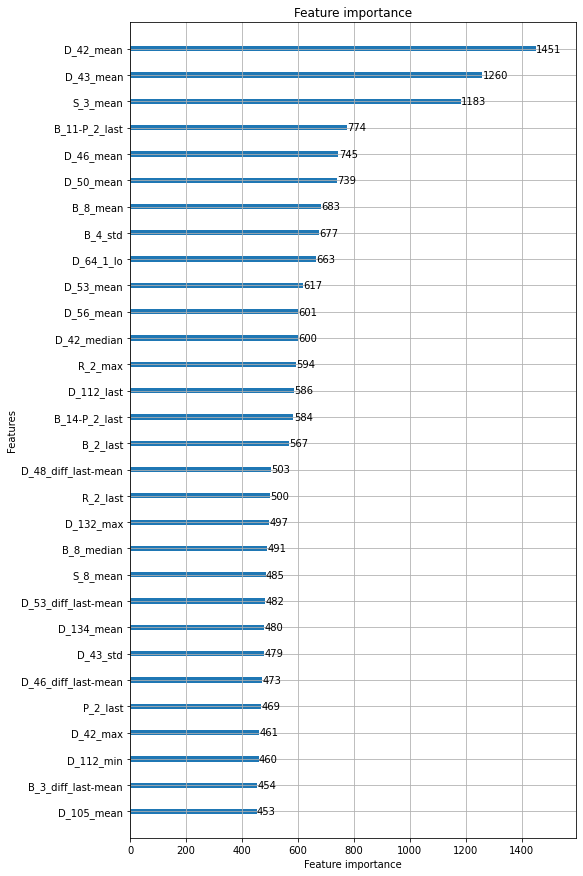

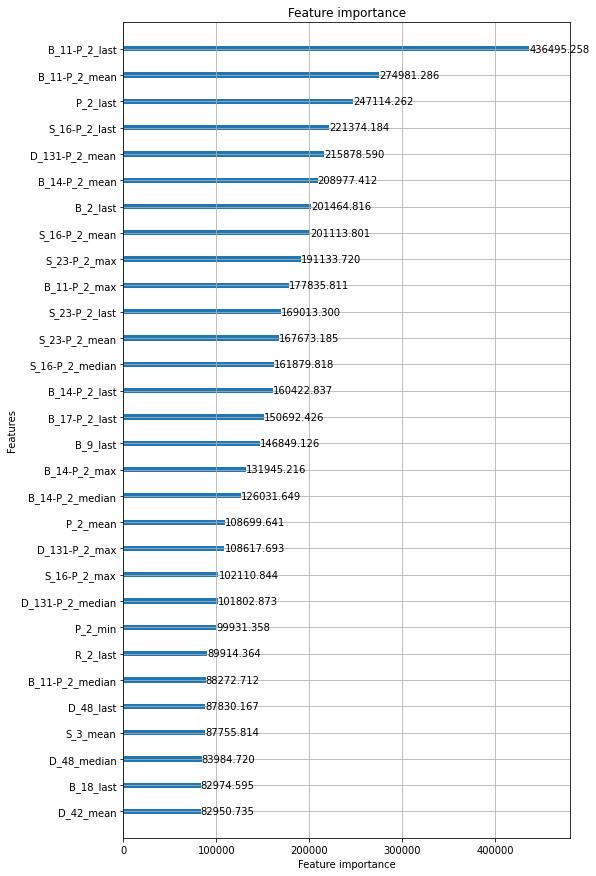

######################################## training model 3/5 ########################################
seed: 7


[50]	valid_0's amex_metric: 0.743549	valid_0's recall_at4: 0.589245	valid_0's norm_gini: 0.897852


[100]	valid_0's amex_metric: 0.750373	valid_0's recall_at4: 0.599344	valid_0's norm_gini: 0.901402


[150]	valid_0's amex_metric: 0.756456	valid_0's recall_at4: 0.608222	valid_0's norm_gini: 0.90469


[200]	valid_0's amex_metric: 0.759404	valid_0's recall_at4: 0.612051	valid_0's norm_gini: 0.906757


[250]	valid_0's amex_metric: 0.762067	valid_0's recall_at4: 0.615249	valid_0's norm_gini: 0.908885


[300]	valid_0's amex_metric: 0.765469	valid_0's recall_at4: 0.619793	valid_0's norm_gini: 0.911145


[350]	valid_0's amex_metric: 0.769465	valid_0's recall_at4: 0.626231	valid_0's norm_gini: 0.912698


[400]	valid_0's amex_metric: 0.770432	valid_0's recall_at4: 0.627577	valid_0's norm_gini: 0.913287


[450]	valid_0's amex_metric: 0.771849	valid_0's recall_at4: 0.629387	valid_0's norm_gini: 0.914312


[500]	valid_0's amex_metric: 0.774826	valid_0's recall_at4: 0.634183	valid_0's norm_gini: 0.915469


[550]	valid_0's amex_metric: 0.777073	valid_0's recall_at4: 0.637549	valid_0's norm_gini: 0.916597


[600]	valid_0's amex_metric: 0.777248	valid_0's recall_at4: 0.637507	valid_0's norm_gini: 0.916988


[650]	valid_0's amex_metric: 0.778794	valid_0's recall_at4: 0.640032	valid_0's norm_gini: 0.917557


[700]	valid_0's amex_metric: 0.779756	valid_0's recall_at4: 0.641547	valid_0's norm_gini: 0.917966


[750]	valid_0's amex_metric: 0.780058	valid_0's recall_at4: 0.642052	valid_0's norm_gini: 0.918064


[800]	valid_0's amex_metric: 0.780376	valid_0's recall_at4: 0.642178	valid_0's norm_gini: 0.918575


[850]	valid_0's amex_metric: 0.781378	valid_0's recall_at4: 0.643819	valid_0's norm_gini: 0.918936


[900]	valid_0's amex_metric: 0.782357	valid_0's recall_at4: 0.64546	valid_0's norm_gini: 0.919253


[950]	valid_0's amex_metric: 0.782771	valid_0's recall_at4: 0.645965	valid_0's norm_gini: 0.919578


[1000]	valid_0's amex_metric: 0.783314	valid_0's recall_at4: 0.646722	valid_0's norm_gini: 0.919906


[1050]	valid_0's amex_metric: 0.7839	valid_0's recall_at4: 0.647606	valid_0's norm_gini: 0.920195


[1100]	valid_0's amex_metric: 0.784041	valid_0's recall_at4: 0.64769	valid_0's norm_gini: 0.920392


[1150]	valid_0's amex_metric: 0.784212	valid_0's recall_at4: 0.647942	valid_0's norm_gini: 0.920481


[1200]	valid_0's amex_metric: 0.783874	valid_0's recall_at4: 0.647269	valid_0's norm_gini: 0.920478


[1250]	valid_0's amex_metric: 0.784554	valid_0's recall_at4: 0.648489	valid_0's norm_gini: 0.920619


[1300]	valid_0's amex_metric: 0.784833	valid_0's recall_at4: 0.648868	valid_0's norm_gini: 0.920798


[1350]	valid_0's amex_metric: 0.785186	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.920956


[1400]	valid_0's amex_metric: 0.785507	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.921177


[1450]	valid_0's amex_metric: 0.785818	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.921295


[1500]	valid_0's amex_metric: 0.785998	valid_0's recall_at4: 0.650509	valid_0's norm_gini: 0.921488


[1550]	valid_0's amex_metric: 0.786575	valid_0's recall_at4: 0.651519	valid_0's norm_gini: 0.921631


[1600]	valid_0's amex_metric: 0.786692	valid_0's recall_at4: 0.651645	valid_0's norm_gini: 0.921739


[1650]	valid_0's amex_metric: 0.786798	valid_0's recall_at4: 0.651687	valid_0's norm_gini: 0.921909


[1700]	valid_0's amex_metric: 0.786821	valid_0's recall_at4: 0.651645	valid_0's norm_gini: 0.921998


[1750]	valid_0's amex_metric: 0.787389	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.922123


[1800]	valid_0's amex_metric: 0.787606	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.922221


[1850]	valid_0's amex_metric: 0.786888	valid_0's recall_at4: 0.651477	valid_0's norm_gini: 0.9223


[1900]	valid_0's amex_metric: 0.787217	valid_0's recall_at4: 0.652066	valid_0's norm_gini: 0.922368


[1950]	valid_0's amex_metric: 0.787181	valid_0's recall_at4: 0.651898	valid_0's norm_gini: 0.922465


[2000]	valid_0's amex_metric: 0.787082	valid_0's recall_at4: 0.651645	valid_0's norm_gini: 0.922518


[2050]	valid_0's amex_metric: 0.787242	valid_0's recall_at4: 0.651898	valid_0's norm_gini: 0.922586


[2100]	valid_0's amex_metric: 0.787747	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.922629


[2150]	valid_0's amex_metric: 0.787896	valid_0's recall_at4: 0.653076	valid_0's norm_gini: 0.922716


[2200]	valid_0's amex_metric: 0.788566	valid_0's recall_at4: 0.654338	valid_0's norm_gini: 0.922793


[2250]	valid_0's amex_metric: 0.78824	valid_0's recall_at4: 0.653623	valid_0's norm_gini: 0.922857


[2300]	valid_0's amex_metric: 0.788691	valid_0's recall_at4: 0.654464	valid_0's norm_gini: 0.922918


[2350]	valid_0's amex_metric: 0.788757	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.922966


[2400]	valid_0's amex_metric: 0.788493	valid_0's recall_at4: 0.653959	valid_0's norm_gini: 0.923027


[2450]	valid_0's amex_metric: 0.789351	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.923103


[2500]	valid_0's amex_metric: 0.789016	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.923146


[2550]	valid_0's amex_metric: 0.789601	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.923182


[2600]	valid_0's amex_metric: 0.789847	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.92321


[2650]	valid_0's amex_metric: 0.789632	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.923242


[2700]	valid_0's amex_metric: 0.789798	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.92328


[2750]	valid_0's amex_metric: 0.78994	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.923354


[2800]	valid_0's amex_metric: 0.790143	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.923382


[2850]	valid_0's amex_metric: 0.789661	valid_0's recall_at4: 0.655895	valid_0's norm_gini: 0.923427


[2900]	valid_0's amex_metric: 0.789803	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.923459


[2950]	valid_0's amex_metric: 0.789789	valid_0's recall_at4: 0.656105	valid_0's norm_gini: 0.923473


[3000]	valid_0's amex_metric: 0.789628	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.923529


[3050]	valid_0's amex_metric: 0.790064	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.923559


[3100]	valid_0's amex_metric: 0.789611	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.923622


[3150]	valid_0's amex_metric: 0.789991	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.923667


[3200]	valid_0's amex_metric: 0.790003	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.92369


[3250]	valid_0's amex_metric: 0.790089	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.923695


[3300]	valid_0's amex_metric: 0.790274	valid_0's recall_at4: 0.656821	valid_0's norm_gini: 0.923727


[3350]	valid_0's amex_metric: 0.790168	valid_0's recall_at4: 0.65661	valid_0's norm_gini: 0.923726


[3400]	valid_0's amex_metric: 0.790834	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923753


[3450]	valid_0's amex_metric: 0.790597	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.923784


[3500]	valid_0's amex_metric: 0.790434	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.923795


[3550]	valid_0's amex_metric: 0.790189	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.923809


[3600]	valid_0's amex_metric: 0.790243	valid_0's recall_at4: 0.656652	valid_0's norm_gini: 0.923833


[3650]	valid_0's amex_metric: 0.790439	valid_0's recall_at4: 0.657031	valid_0's norm_gini: 0.923848


[3700]	valid_0's amex_metric: 0.790337	valid_0's recall_at4: 0.656821	valid_0's norm_gini: 0.923854


[3750]	valid_0's amex_metric: 0.790237	valid_0's recall_at4: 0.65661	valid_0's norm_gini: 0.923863


[3800]	valid_0's amex_metric: 0.790394	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.923883


[3850]	valid_0's amex_metric: 0.79059	valid_0's recall_at4: 0.657283	valid_0's norm_gini: 0.923897


[3900]	valid_0's amex_metric: 0.790856	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923924


[3950]	valid_0's amex_metric: 0.790674	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.92398


[4000]	valid_0's amex_metric: 0.790875	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.924004


[4050]	valid_0's amex_metric: 0.790822	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.924024


[4100]	valid_0's amex_metric: 0.791128	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.924048


[4150]	valid_0's amex_metric: 0.791123	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.924078


[4200]	valid_0's amex_metric: 0.791091	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.924098


[4250]	valid_0's amex_metric: 0.791032	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.924107


[4300]	valid_0's amex_metric: 0.790868	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.924157


[4350]	valid_0's amex_metric: 0.791215	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.924178


[4400]	valid_0's amex_metric: 0.791324	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.924187


[4450]	valid_0's amex_metric: 0.791346	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.924189


[4500]	valid_0's amex_metric: 0.791477	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.924197


[4550]	valid_0's amex_metric: 0.79136	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.924216


[4600]	valid_0's amex_metric: 0.791299	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.92422


[4650]	valid_0's amex_metric: 0.791128	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.924214


[4700]	valid_0's amex_metric: 0.790749	valid_0's recall_at4: 0.657283	valid_0's norm_gini: 0.924215


[4750]	valid_0's amex_metric: 0.791179	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.92419


[4800]	valid_0's amex_metric: 0.791184	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.9242


[4850]	valid_0's amex_metric: 0.791182	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.924197


[4900]	valid_0's amex_metric: 0.791097	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.924196


[4950]	valid_0's amex_metric: 0.791226	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.9242


[5000]	valid_0's amex_metric: 0.791034	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.924195


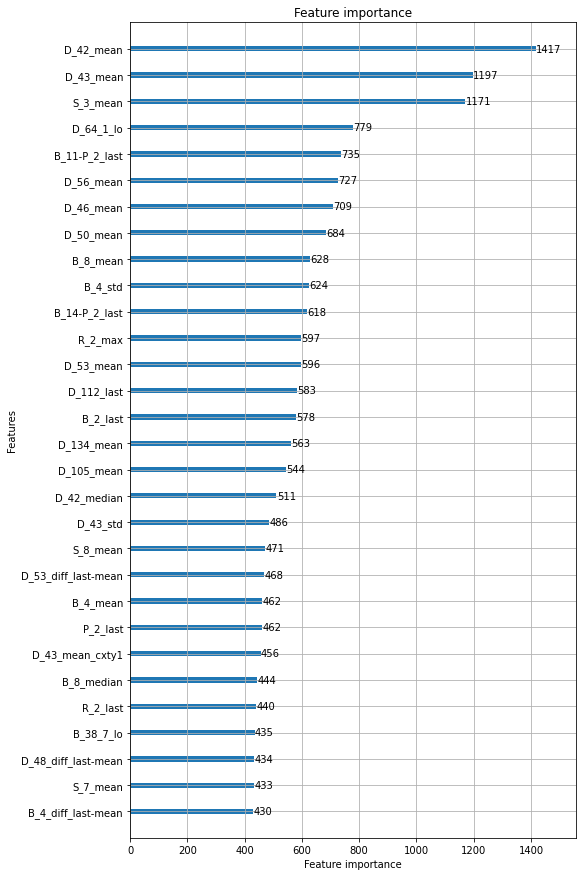

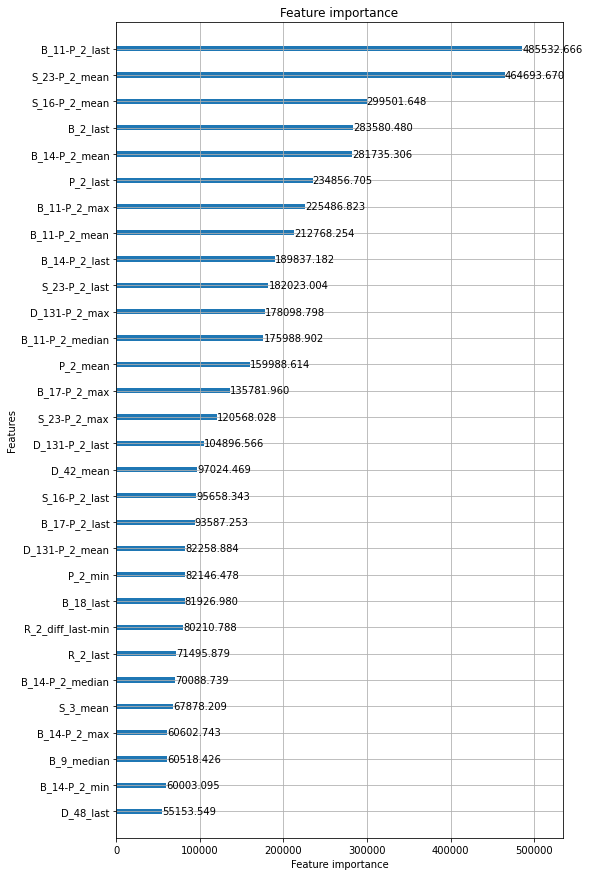

######################################## training model 4/5 ########################################
seed: 8


[50]	valid_0's amex_metric: 0.74763	valid_0's recall_at4: 0.595708	valid_0's norm_gini: 0.899553


[100]	valid_0's amex_metric: 0.75556	valid_0's recall_at4: 0.607238	valid_0's norm_gini: 0.903882


[150]	valid_0's amex_metric: 0.758846	valid_0's recall_at4: 0.611656	valid_0's norm_gini: 0.906036


[200]	valid_0's amex_metric: 0.761707	valid_0's recall_at4: 0.615822	valid_0's norm_gini: 0.907592


[250]	valid_0's amex_metric: 0.763794	valid_0's recall_at4: 0.618935	valid_0's norm_gini: 0.908652


[300]	valid_0's amex_metric: 0.76686	valid_0's recall_at4: 0.623648	valid_0's norm_gini: 0.910072


[350]	valid_0's amex_metric: 0.769307	valid_0's recall_at4: 0.627099	valid_0's norm_gini: 0.911515


[400]	valid_0's amex_metric: 0.772226	valid_0's recall_at4: 0.631727	valid_0's norm_gini: 0.912725


[450]	valid_0's amex_metric: 0.774689	valid_0's recall_at4: 0.63543	valid_0's norm_gini: 0.913948


[500]	valid_0's amex_metric: 0.776017	valid_0's recall_at4: 0.637155	valid_0's norm_gini: 0.914879


[550]	valid_0's amex_metric: 0.779055	valid_0's recall_at4: 0.642079	valid_0's norm_gini: 0.916032


[600]	valid_0's amex_metric: 0.779949	valid_0's recall_at4: 0.643131	valid_0's norm_gini: 0.916767


[650]	valid_0's amex_metric: 0.780171	valid_0's recall_at4: 0.64292	valid_0's norm_gini: 0.917422


[700]	valid_0's amex_metric: 0.782596	valid_0's recall_at4: 0.647002	valid_0's norm_gini: 0.918191


[750]	valid_0's amex_metric: 0.783485	valid_0's recall_at4: 0.64818	valid_0's norm_gini: 0.91879


[800]	valid_0's amex_metric: 0.784762	valid_0's recall_at4: 0.650326	valid_0's norm_gini: 0.919198


[850]	valid_0's amex_metric: 0.785348	valid_0's recall_at4: 0.651252	valid_0's norm_gini: 0.919444


[900]	valid_0's amex_metric: 0.785857	valid_0's recall_at4: 0.652093	valid_0's norm_gini: 0.91962


[950]	valid_0's amex_metric: 0.786627	valid_0's recall_at4: 0.653356	valid_0's norm_gini: 0.919899


[1000]	valid_0's amex_metric: 0.787356	valid_0's recall_at4: 0.654576	valid_0's norm_gini: 0.920135


[1050]	valid_0's amex_metric: 0.787884	valid_0's recall_at4: 0.655376	valid_0's norm_gini: 0.920392


[1100]	valid_0's amex_metric: 0.788653	valid_0's recall_at4: 0.656554	valid_0's norm_gini: 0.920751


[1150]	valid_0's amex_metric: 0.790119	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.920992


[1200]	valid_0's amex_metric: 0.790721	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.921186


[1250]	valid_0's amex_metric: 0.791295	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.921533


[1300]	valid_0's amex_metric: 0.79131	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.921774


[1350]	valid_0's amex_metric: 0.791833	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.92202


[1400]	valid_0's amex_metric: 0.792219	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.922204


[1450]	valid_0's amex_metric: 0.792388	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.922373


[1500]	valid_0's amex_metric: 0.792584	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.922471


[1550]	valid_0's amex_metric: 0.792785	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.922579


[1600]	valid_0's amex_metric: 0.793659	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.922685


[1650]	valid_0's amex_metric: 0.793395	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.922788


[1700]	valid_0's amex_metric: 0.793232	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.922924


[1750]	valid_0's amex_metric: 0.793555	valid_0's recall_at4: 0.664044	valid_0's norm_gini: 0.923065


[1800]	valid_0's amex_metric: 0.793735	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.923131


[1850]	valid_0's amex_metric: 0.793652	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.923219


[1900]	valid_0's amex_metric: 0.793795	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.923294


[1950]	valid_0's amex_metric: 0.793859	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.923379


[2000]	valid_0's amex_metric: 0.794009	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.92347


[2050]	valid_0's amex_metric: 0.794241	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.923554


[2100]	valid_0's amex_metric: 0.794618	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.923636


[2150]	valid_0's amex_metric: 0.795205	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.923715


[2200]	valid_0's amex_metric: 0.794527	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.92379


[2250]	valid_0's amex_metric: 0.795236	valid_0's recall_at4: 0.666653	valid_0's norm_gini: 0.92382


[2300]	valid_0's amex_metric: 0.795827	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.923865


[2350]	valid_0's amex_metric: 0.79498	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.923896


[2400]	valid_0's amex_metric: 0.795266	valid_0's recall_at4: 0.666568	valid_0's norm_gini: 0.923964


[2450]	valid_0's amex_metric: 0.795207	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.924015


[2500]	valid_0's amex_metric: 0.795602	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.924088


[2550]	valid_0's amex_metric: 0.795939	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.924131


[2600]	valid_0's amex_metric: 0.795772	valid_0's recall_at4: 0.66741	valid_0's norm_gini: 0.924133


[2650]	valid_0's amex_metric: 0.796157	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.924147


[2700]	valid_0's amex_metric: 0.795862	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924187


[2750]	valid_0's amex_metric: 0.795415	valid_0's recall_at4: 0.666568	valid_0's norm_gini: 0.924261


[2800]	valid_0's amex_metric: 0.796115	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.924315


[2850]	valid_0's amex_metric: 0.796131	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.924348


[2900]	valid_0's amex_metric: 0.795961	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924386


[2950]	valid_0's amex_metric: 0.795798	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.924438


[3000]	valid_0's amex_metric: 0.796007	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924478


[3050]	valid_0's amex_metric: 0.796105	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.924505


[3100]	valid_0's amex_metric: 0.79641	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.924527


[3150]	valid_0's amex_metric: 0.796864	valid_0's recall_at4: 0.669177	valid_0's norm_gini: 0.924551


[3200]	valid_0's amex_metric: 0.79624	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.924566


[3250]	valid_0's amex_metric: 0.795914	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.924586


[3300]	valid_0's amex_metric: 0.796153	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.924601


[3350]	valid_0's amex_metric: 0.796236	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.924642


[3400]	valid_0's amex_metric: 0.796238	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.924646


[3450]	valid_0's amex_metric: 0.796841	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.924672


[3500]	valid_0's amex_metric: 0.797029	valid_0's recall_at4: 0.669346	valid_0's norm_gini: 0.924712


[3550]	valid_0's amex_metric: 0.79721	valid_0's recall_at4: 0.669682	valid_0's norm_gini: 0.924738


[3600]	valid_0's amex_metric: 0.7974	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.924781


[3650]	valid_0's amex_metric: 0.797403	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.924788


[3700]	valid_0's amex_metric: 0.797308	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.924808


[3750]	valid_0's amex_metric: 0.797269	valid_0's recall_at4: 0.669724	valid_0's norm_gini: 0.924813


[3800]	valid_0's amex_metric: 0.797022	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.924825


[3850]	valid_0's amex_metric: 0.797222	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.924846


[3900]	valid_0's amex_metric: 0.797549	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.924869


[3950]	valid_0's amex_metric: 0.797044	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.924869


[4000]	valid_0's amex_metric: 0.797467	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.924872


[4050]	valid_0's amex_metric: 0.797818	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.924902


[4100]	valid_0's amex_metric: 0.797385	valid_0's recall_at4: 0.669851	valid_0's norm_gini: 0.92492


[4150]	valid_0's amex_metric: 0.79741	valid_0's recall_at4: 0.669893	valid_0's norm_gini: 0.924928


[4200]	valid_0's amex_metric: 0.797623	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.924933


[4250]	valid_0's amex_metric: 0.797927	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.924952


[4300]	valid_0's amex_metric: 0.798194	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.92498


[4350]	valid_0's amex_metric: 0.798333	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.925007


[4400]	valid_0's amex_metric: 0.797974	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925045


[4450]	valid_0's amex_metric: 0.797643	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925057


[4500]	valid_0's amex_metric: 0.798243	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.925079


[4550]	valid_0's amex_metric: 0.798105	valid_0's recall_at4: 0.671113	valid_0's norm_gini: 0.925097


[4600]	valid_0's amex_metric: 0.798152	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.925107


[4650]	valid_0's amex_metric: 0.798075	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.92512


[4700]	valid_0's amex_metric: 0.798082	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.925135


[4750]	valid_0's amex_metric: 0.798311	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.92513


[4800]	valid_0's amex_metric: 0.798451	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.925158


[4850]	valid_0's amex_metric: 0.798251	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.925178


[4900]	valid_0's amex_metric: 0.798525	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.925179


[4950]	valid_0's amex_metric: 0.798633	valid_0's recall_at4: 0.672081	valid_0's norm_gini: 0.925185


[5000]	valid_0's amex_metric: 0.798996	valid_0's recall_at4: 0.672796	valid_0's norm_gini: 0.925195


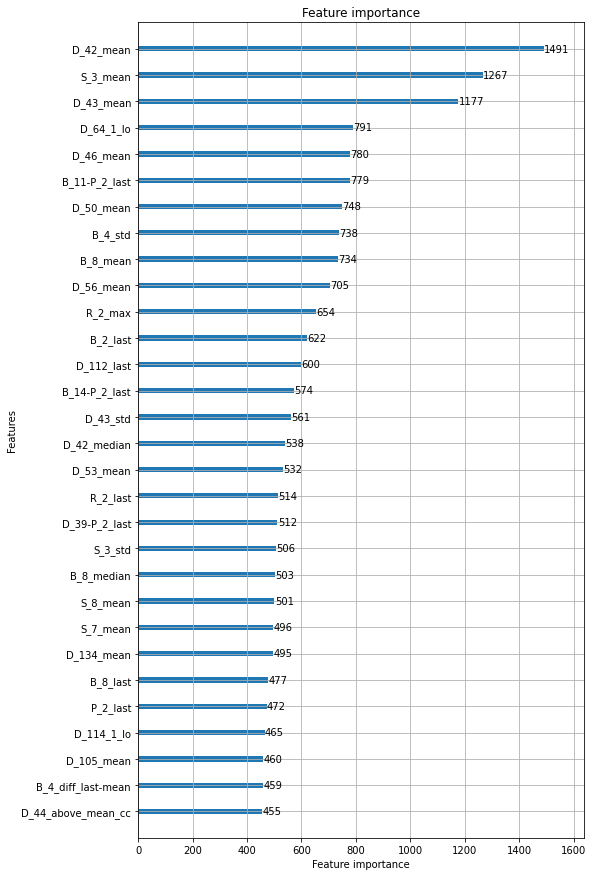

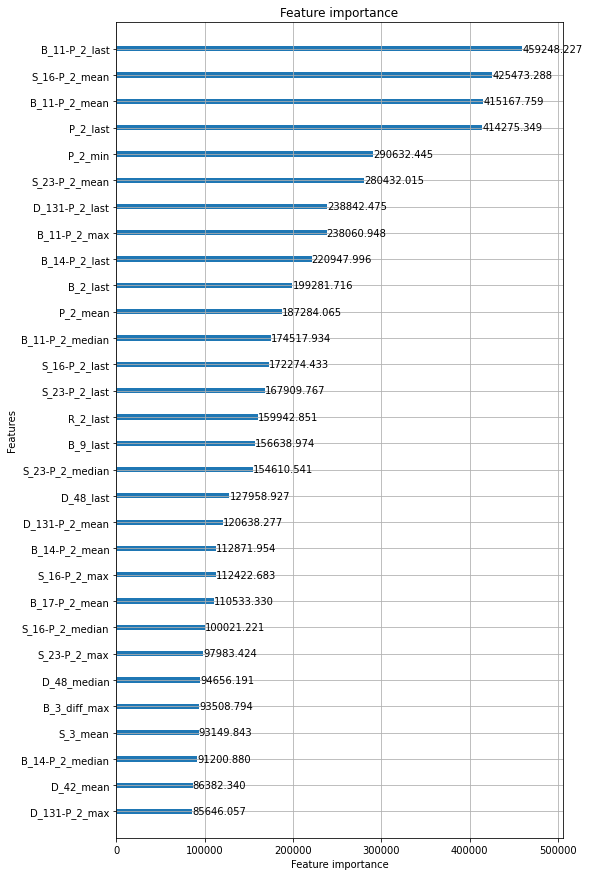

######################################## training model 5/5 ########################################
seed: 9


[50]	valid_0's amex_metric: 0.750542	valid_0's recall_at4: 0.600673	valid_0's norm_gini: 0.900412


[100]	valid_0's amex_metric: 0.756381	valid_0's recall_at4: 0.608668	valid_0's norm_gini: 0.904093


[150]	valid_0's amex_metric: 0.760339	valid_0's recall_at4: 0.614559	valid_0's norm_gini: 0.90612


[200]	valid_0's amex_metric: 0.76339	valid_0's recall_at4: 0.618725	valid_0's norm_gini: 0.908054


[250]	valid_0's amex_metric: 0.770246	valid_0's recall_at4: 0.629539	valid_0's norm_gini: 0.910953


[300]	valid_0's amex_metric: 0.773193	valid_0's recall_at4: 0.634294	valid_0's norm_gini: 0.912092


[350]	valid_0's amex_metric: 0.775961	valid_0's recall_at4: 0.63766	valid_0's norm_gini: 0.914262


[400]	valid_0's amex_metric: 0.778091	valid_0's recall_at4: 0.6409	valid_0's norm_gini: 0.915282


[450]	valid_0's amex_metric: 0.779847	valid_0's recall_at4: 0.643341	valid_0's norm_gini: 0.916352


[500]	valid_0's amex_metric: 0.780908	valid_0's recall_at4: 0.644814	valid_0's norm_gini: 0.917003


[550]	valid_0's amex_metric: 0.781197	valid_0's recall_at4: 0.644814	valid_0's norm_gini: 0.917581


[600]	valid_0's amex_metric: 0.781906	valid_0's recall_at4: 0.645866	valid_0's norm_gini: 0.917945


[650]	valid_0's amex_metric: 0.78248	valid_0's recall_at4: 0.646539	valid_0's norm_gini: 0.918421


[700]	valid_0's amex_metric: 0.784506	valid_0's recall_at4: 0.649989	valid_0's norm_gini: 0.919023


[750]	valid_0's amex_metric: 0.785095	valid_0's recall_at4: 0.650915	valid_0's norm_gini: 0.919275


[800]	valid_0's amex_metric: 0.786229	valid_0's recall_at4: 0.652767	valid_0's norm_gini: 0.919691


[850]	valid_0's amex_metric: 0.786751	valid_0's recall_at4: 0.653566	valid_0's norm_gini: 0.919936


[900]	valid_0's amex_metric: 0.786768	valid_0's recall_at4: 0.65344	valid_0's norm_gini: 0.920095


[950]	valid_0's amex_metric: 0.786732	valid_0's recall_at4: 0.653145	valid_0's norm_gini: 0.920318


[1000]	valid_0's amex_metric: 0.787435	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.920631


[1050]	valid_0's amex_metric: 0.787834	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.920965


[1100]	valid_0's amex_metric: 0.788958	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.92132


[1150]	valid_0's amex_metric: 0.789381	valid_0's recall_at4: 0.657185	valid_0's norm_gini: 0.921578


[1200]	valid_0's amex_metric: 0.78958	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.921723


[1250]	valid_0's amex_metric: 0.790042	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.921889


[1300]	valid_0's amex_metric: 0.790381	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.922061


[1350]	valid_0's amex_metric: 0.790779	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.922227


[1400]	valid_0's amex_metric: 0.791411	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.922354


[1450]	valid_0's amex_metric: 0.791814	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.922529


[1500]	valid_0's amex_metric: 0.792334	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.922687


[1550]	valid_0's amex_metric: 0.792541	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.92289


[1600]	valid_0's amex_metric: 0.792716	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.923029


[1650]	valid_0's amex_metric: 0.79325	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923172


[1700]	valid_0's amex_metric: 0.793325	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923321


[1750]	valid_0's amex_metric: 0.793403	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.923435


[1800]	valid_0's amex_metric: 0.793764	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.923567


[1850]	valid_0's amex_metric: 0.793982	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.923667


[1900]	valid_0's amex_metric: 0.79433	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.923732


[1950]	valid_0's amex_metric: 0.794231	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.923787


[2000]	valid_0's amex_metric: 0.79448	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.923864


[2050]	valid_0's amex_metric: 0.794677	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.923921


[2100]	valid_0's amex_metric: 0.794706	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.92398


[2150]	valid_0's amex_metric: 0.79504	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.924017


[2200]	valid_0's amex_metric: 0.794838	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.924076


[2250]	valid_0's amex_metric: 0.794903	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.924121


[2300]	valid_0's amex_metric: 0.794581	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924151


[2350]	valid_0's amex_metric: 0.794474	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.924189


[2400]	valid_0's amex_metric: 0.794622	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924233


[2450]	valid_0's amex_metric: 0.795168	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.924273


[2500]	valid_0's amex_metric: 0.794859	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924328


[2550]	valid_0's amex_metric: 0.794898	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924405


[2600]	valid_0's amex_metric: 0.794735	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.924416


[2650]	valid_0's amex_metric: 0.79528	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.924454


[2700]	valid_0's amex_metric: 0.795221	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.924505


[2750]	valid_0's amex_metric: 0.795109	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924576


[2800]	valid_0's amex_metric: 0.795244	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924634


[2850]	valid_0's amex_metric: 0.795596	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.924666


[2900]	valid_0's amex_metric: 0.795793	valid_0's recall_at4: 0.666905	valid_0's norm_gini: 0.924681


[2950]	valid_0's amex_metric: 0.79571	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.924726


[3000]	valid_0's amex_metric: 0.796215	valid_0's recall_at4: 0.667663	valid_0's norm_gini: 0.924767


[3050]	valid_0's amex_metric: 0.796058	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.92479


[3100]	valid_0's amex_metric: 0.79624	valid_0's recall_at4: 0.667663	valid_0's norm_gini: 0.924818


[3150]	valid_0's amex_metric: 0.796624	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.924871


[3200]	valid_0's amex_metric: 0.796569	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.924887


[3250]	valid_0's amex_metric: 0.796652	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.924926


[3300]	valid_0's amex_metric: 0.796657	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.924936


[3350]	valid_0's amex_metric: 0.796832	valid_0's recall_at4: 0.668672	valid_0's norm_gini: 0.924991


[3400]	valid_0's amex_metric: 0.796707	valid_0's recall_at4: 0.66842	valid_0's norm_gini: 0.924994


[3450]	valid_0's amex_metric: 0.796973	valid_0's recall_at4: 0.668925	valid_0's norm_gini: 0.925021


[3500]	valid_0's amex_metric: 0.796771	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.925038


[3550]	valid_0's amex_metric: 0.796779	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.925055


[3600]	valid_0's amex_metric: 0.796835	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.925082


[3650]	valid_0's amex_metric: 0.796962	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925084


[3700]	valid_0's amex_metric: 0.797187	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.925112


[3750]	valid_0's amex_metric: 0.7975	valid_0's recall_at4: 0.669851	valid_0's norm_gini: 0.92515


[3800]	valid_0's amex_metric: 0.797337	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.925161


[3850]	valid_0's amex_metric: 0.797435	valid_0's recall_at4: 0.669682	valid_0's norm_gini: 0.925189


[3900]	valid_0's amex_metric: 0.797224	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925228


[3950]	valid_0's amex_metric: 0.797467	valid_0's recall_at4: 0.669682	valid_0's norm_gini: 0.925251


[4000]	valid_0's amex_metric: 0.797618	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.925301


[4050]	valid_0's amex_metric: 0.797393	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925314


[4100]	valid_0's amex_metric: 0.797292	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.925322


[4150]	valid_0's amex_metric: 0.797343	valid_0's recall_at4: 0.669346	valid_0's norm_gini: 0.925341


[4200]	valid_0's amex_metric: 0.797783	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.925379


[4250]	valid_0's amex_metric: 0.798032	valid_0's recall_at4: 0.67065	valid_0's norm_gini: 0.925414


[4300]	valid_0's amex_metric: 0.798128	valid_0's recall_at4: 0.670818	valid_0's norm_gini: 0.925437


[4350]	valid_0's amex_metric: 0.798172	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925441


[4400]	valid_0's amex_metric: 0.798013	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.92546


[4450]	valid_0's amex_metric: 0.798191	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.92548


[4500]	valid_0's amex_metric: 0.797797	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.92549


[4550]	valid_0's amex_metric: 0.797931	valid_0's recall_at4: 0.670356	valid_0's norm_gini: 0.925506


[4600]	valid_0's amex_metric: 0.798108	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925524


[4650]	valid_0's amex_metric: 0.798113	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925534


[4700]	valid_0's amex_metric: 0.798235	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.925525


[4750]	valid_0's amex_metric: 0.797927	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.92554


[4800]	valid_0's amex_metric: 0.798161	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.925546


[4850]	valid_0's amex_metric: 0.798224	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925546


[4900]	valid_0's amex_metric: 0.797812	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925564


[4950]	valid_0's amex_metric: 0.797584	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.92557


[5000]	valid_0's amex_metric: 0.797275	valid_0's recall_at4: 0.668967	valid_0's norm_gini: 0.925583


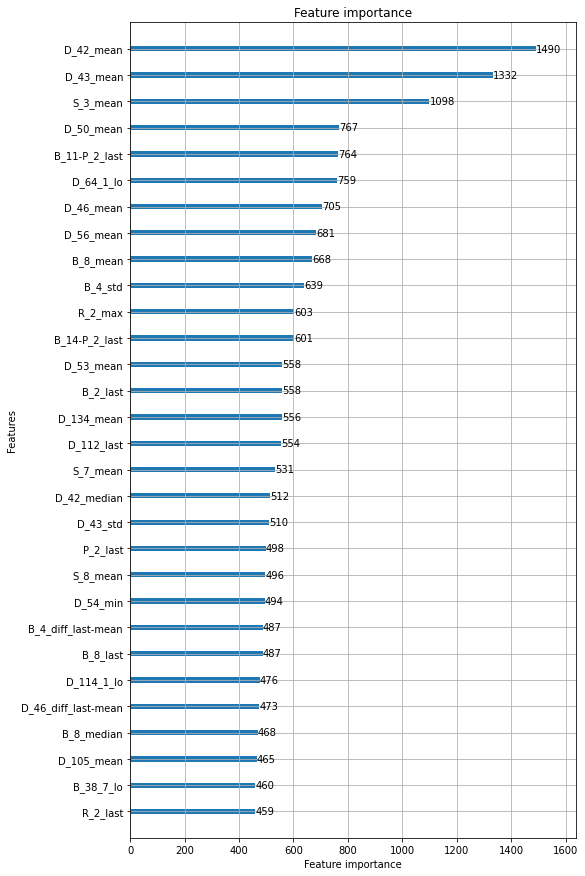

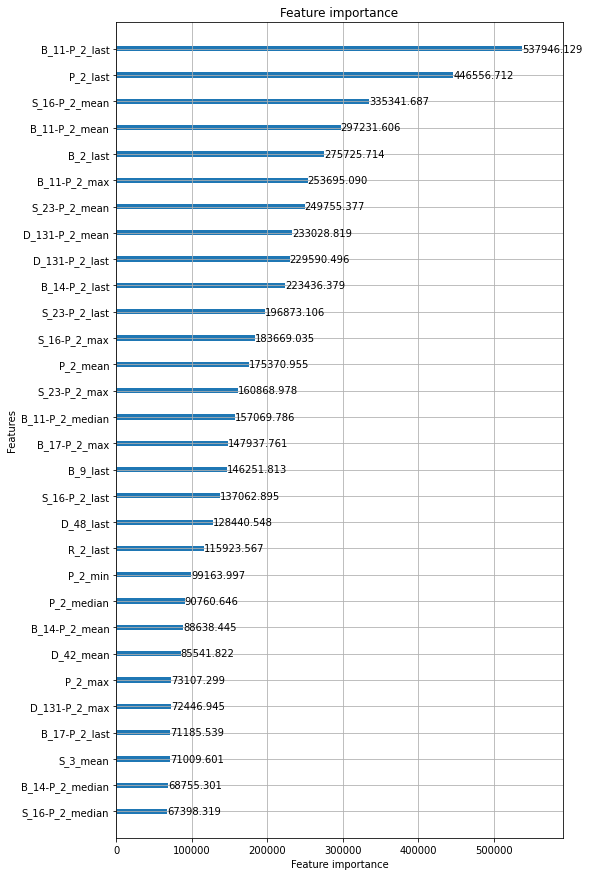

Training time: 72.92761981487274 min.
OOF recall_at4: 0.6675867640623422
OOF normalized_gini: 0.9250664358134656
OOF competition metric: 0.7963265999379039


############################### repeated cross-validation step: 3/5 ################################


######################################## training model 1/5 ########################################
seed: 10


[50]	valid_0's amex_metric: 0.744863	valid_0's recall_at4: 0.591097	valid_0's norm_gini: 0.898629


[100]	valid_0's amex_metric: 0.752977	valid_0's recall_at4: 0.603551	valid_0's norm_gini: 0.902403


[150]	valid_0's amex_metric: 0.755693	valid_0's recall_at4: 0.60738	valid_0's norm_gini: 0.904005


[200]	valid_0's amex_metric: 0.757729	valid_0's recall_at4: 0.610326	valid_0's norm_gini: 0.905133


[250]	valid_0's amex_metric: 0.76032	valid_0's recall_at4: 0.613776	valid_0's norm_gini: 0.906863


[300]	valid_0's amex_metric: 0.763691	valid_0's recall_at4: 0.619078	valid_0's norm_gini: 0.908303


[350]	valid_0's amex_metric: 0.76618	valid_0's recall_at4: 0.62278	valid_0's norm_gini: 0.90958


[400]	valid_0's amex_metric: 0.767091	valid_0's recall_at4: 0.623748	valid_0's norm_gini: 0.910435


[450]	valid_0's amex_metric: 0.769167	valid_0's recall_at4: 0.626652	valid_0's norm_gini: 0.911682


[500]	valid_0's amex_metric: 0.771484	valid_0's recall_at4: 0.629681	valid_0's norm_gini: 0.913288


[550]	valid_0's amex_metric: 0.77333	valid_0's recall_at4: 0.632626	valid_0's norm_gini: 0.914034


[600]	valid_0's amex_metric: 0.774006	valid_0's recall_at4: 0.6333	valid_0's norm_gini: 0.914712


[650]	valid_0's amex_metric: 0.776695	valid_0's recall_at4: 0.637844	valid_0's norm_gini: 0.915546


[700]	valid_0's amex_metric: 0.778156	valid_0's recall_at4: 0.6402	valid_0's norm_gini: 0.916112


[750]	valid_0's amex_metric: 0.779013	valid_0's recall_at4: 0.641421	valid_0's norm_gini: 0.916605


[800]	valid_0's amex_metric: 0.779871	valid_0's recall_at4: 0.642557	valid_0's norm_gini: 0.917185


[850]	valid_0's amex_metric: 0.781031	valid_0's recall_at4: 0.644282	valid_0's norm_gini: 0.917781


[900]	valid_0's amex_metric: 0.782127	valid_0's recall_at4: 0.646007	valid_0's norm_gini: 0.918248


[950]	valid_0's amex_metric: 0.782867	valid_0's recall_at4: 0.647227	valid_0's norm_gini: 0.918507


[1000]	valid_0's amex_metric: 0.783016	valid_0's recall_at4: 0.647395	valid_0's norm_gini: 0.918637


[1050]	valid_0's amex_metric: 0.783267	valid_0's recall_at4: 0.647564	valid_0's norm_gini: 0.91897


[1100]	valid_0's amex_metric: 0.783391	valid_0's recall_at4: 0.647522	valid_0's norm_gini: 0.91926


[1150]	valid_0's amex_metric: 0.783819	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.919486


[1200]	valid_0's amex_metric: 0.784663	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.919701


[1250]	valid_0's amex_metric: 0.78553	valid_0's recall_at4: 0.65114	valid_0's norm_gini: 0.919919


[1300]	valid_0's amex_metric: 0.785914	valid_0's recall_at4: 0.651729	valid_0's norm_gini: 0.920098


[1350]	valid_0's amex_metric: 0.786576	valid_0's recall_at4: 0.652823	valid_0's norm_gini: 0.920328


[1400]	valid_0's amex_metric: 0.786237	valid_0's recall_at4: 0.652024	valid_0's norm_gini: 0.92045


[1450]	valid_0's amex_metric: 0.78726	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.920644


[1500]	valid_0's amex_metric: 0.787153	valid_0's recall_at4: 0.653539	valid_0's norm_gini: 0.920767


[1550]	valid_0's amex_metric: 0.787195	valid_0's recall_at4: 0.653539	valid_0's norm_gini: 0.920852


[1600]	valid_0's amex_metric: 0.787981	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.921035


[1650]	valid_0's amex_metric: 0.787786	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.92115


[1700]	valid_0's amex_metric: 0.788544	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.921235


[1750]	valid_0's amex_metric: 0.788536	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.921345


[1800]	valid_0's amex_metric: 0.788669	valid_0's recall_at4: 0.655895	valid_0's norm_gini: 0.921443


[1850]	valid_0's amex_metric: 0.789039	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.921552


[1900]	valid_0's amex_metric: 0.789765	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.921616


[1950]	valid_0's amex_metric: 0.789833	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.921668


[2000]	valid_0's amex_metric: 0.789453	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.921748


[2050]	valid_0's amex_metric: 0.789621	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.921832


[2100]	valid_0's amex_metric: 0.789782	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.921902


[2150]	valid_0's amex_metric: 0.789955	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.921954


[2200]	valid_0's amex_metric: 0.789819	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.922017


[2250]	valid_0's amex_metric: 0.789516	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.922127


[2300]	valid_0's amex_metric: 0.789943	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.922181


[2350]	valid_0's amex_metric: 0.790466	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.922259


[2400]	valid_0's amex_metric: 0.790573	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.922306


[2450]	valid_0's amex_metric: 0.790702	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.922312


[2500]	valid_0's amex_metric: 0.791259	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.922373


[2550]	valid_0's amex_metric: 0.791384	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.922413


[2600]	valid_0's amex_metric: 0.791247	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.922475


[2650]	valid_0's amex_metric: 0.790919	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.922492


[2700]	valid_0's amex_metric: 0.791232	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.922529


[2750]	valid_0's amex_metric: 0.791786	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.922585


[2800]	valid_0's amex_metric: 0.791658	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.922624


[2850]	valid_0's amex_metric: 0.791581	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.922638


[2900]	valid_0's amex_metric: 0.791712	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.922648


[2950]	valid_0's amex_metric: 0.792164	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.922668


[3000]	valid_0's amex_metric: 0.792251	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.922674


[3050]	valid_0's amex_metric: 0.792275	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.922723


[3100]	valid_0's amex_metric: 0.791994	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.922749


[3150]	valid_0's amex_metric: 0.792529	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.922768


[3200]	valid_0's amex_metric: 0.792625	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922791


[3250]	valid_0's amex_metric: 0.792751	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.922832


[3300]	valid_0's amex_metric: 0.792328	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.922829


[3350]	valid_0's amex_metric: 0.792772	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.922875


[3400]	valid_0's amex_metric: 0.792657	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.922897


[3450]	valid_0's amex_metric: 0.792641	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.92295


[3500]	valid_0's amex_metric: 0.792822	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.922975


[3550]	valid_0's amex_metric: 0.79292	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.923001


[3600]	valid_0's amex_metric: 0.79316	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.92302


[3650]	valid_0's amex_metric: 0.79386	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.923031


[3700]	valid_0's amex_metric: 0.793329	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.923063


[3750]	valid_0's amex_metric: 0.793764	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.923091


[3800]	valid_0's amex_metric: 0.793672	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.923118


[3850]	valid_0's amex_metric: 0.793218	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923135


[3900]	valid_0's amex_metric: 0.793297	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.923168


[3950]	valid_0's amex_metric: 0.793374	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.923196


[4000]	valid_0's amex_metric: 0.793603	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.923232


[4050]	valid_0's amex_metric: 0.793787	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.923264


[4100]	valid_0's amex_metric: 0.79397	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.923292


[4150]	valid_0's amex_metric: 0.794036	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923299


[4200]	valid_0's amex_metric: 0.79395	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.923295


[4250]	valid_0's amex_metric: 0.793885	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.923291


[4300]	valid_0's amex_metric: 0.79397	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.923292


[4350]	valid_0's amex_metric: 0.793846	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.923298


[4400]	valid_0's amex_metric: 0.793895	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.923312


[4450]	valid_0's amex_metric: 0.793638	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.923344


[4500]	valid_0's amex_metric: 0.79373	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.923361


[4550]	valid_0's amex_metric: 0.793884	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.923374


[4600]	valid_0's amex_metric: 0.793258	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923384


[4650]	valid_0's amex_metric: 0.793386	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923387


[4700]	valid_0's amex_metric: 0.793347	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923393


[4750]	valid_0's amex_metric: 0.793524	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.923412


[4800]	valid_0's amex_metric: 0.793472	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923433


[4850]	valid_0's amex_metric: 0.79352	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.923444


[4900]	valid_0's amex_metric: 0.793644	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.92344


[4950]	valid_0's amex_metric: 0.793733	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.923451


[5000]	valid_0's amex_metric: 0.793273	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.923456


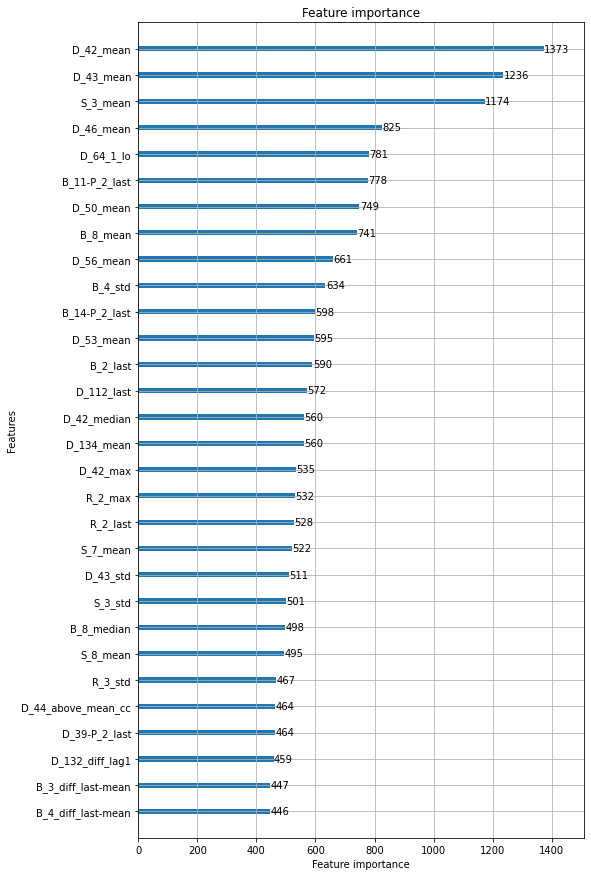

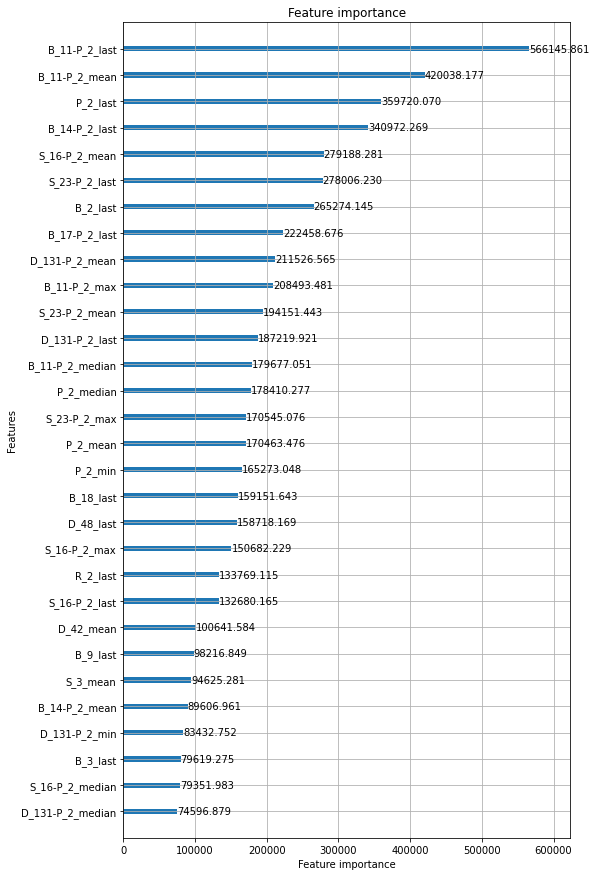

######################################## training model 2/5 ########################################
seed: 11


[50]	valid_0's amex_metric: 0.745512	valid_0's recall_at4: 0.591728	valid_0's norm_gini: 0.899297


[100]	valid_0's amex_metric: 0.753503	valid_0's recall_at4: 0.603383	valid_0's norm_gini: 0.903624


[150]	valid_0's amex_metric: 0.758268	valid_0's recall_at4: 0.610157	valid_0's norm_gini: 0.906379


[200]	valid_0's amex_metric: 0.760612	valid_0's recall_at4: 0.613439	valid_0's norm_gini: 0.907784


[250]	valid_0's amex_metric: 0.761608	valid_0's recall_at4: 0.614197	valid_0's norm_gini: 0.90902


[300]	valid_0's amex_metric: 0.76396	valid_0's recall_at4: 0.617984	valid_0's norm_gini: 0.909937


[350]	valid_0's amex_metric: 0.765507	valid_0's recall_at4: 0.619877	valid_0's norm_gini: 0.911138


[400]	valid_0's amex_metric: 0.767493	valid_0's recall_at4: 0.622654	valid_0's norm_gini: 0.912331


[450]	valid_0's amex_metric: 0.769623	valid_0's recall_at4: 0.625726	valid_0's norm_gini: 0.913521


[500]	valid_0's amex_metric: 0.77165	valid_0's recall_at4: 0.628797	valid_0's norm_gini: 0.914503


[550]	valid_0's amex_metric: 0.773545	valid_0's recall_at4: 0.631743	valid_0's norm_gini: 0.915347


[600]	valid_0's amex_metric: 0.775265	valid_0's recall_at4: 0.634436	valid_0's norm_gini: 0.916093


[650]	valid_0's amex_metric: 0.775719	valid_0's recall_at4: 0.634688	valid_0's norm_gini: 0.91675


[700]	valid_0's amex_metric: 0.777749	valid_0's recall_at4: 0.638054	valid_0's norm_gini: 0.917444


[750]	valid_0's amex_metric: 0.778842	valid_0's recall_at4: 0.63978	valid_0's norm_gini: 0.917904


[800]	valid_0's amex_metric: 0.779287	valid_0's recall_at4: 0.640284	valid_0's norm_gini: 0.918289


[850]	valid_0's amex_metric: 0.780741	valid_0's recall_at4: 0.642809	valid_0's norm_gini: 0.918674


[900]	valid_0's amex_metric: 0.781166	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.919229


[950]	valid_0's amex_metric: 0.782494	valid_0's recall_at4: 0.645334	valid_0's norm_gini: 0.919654


[1000]	valid_0's amex_metric: 0.782041	valid_0's recall_at4: 0.644113	valid_0's norm_gini: 0.919969


[1050]	valid_0's amex_metric: 0.783118	valid_0's recall_at4: 0.645881	valid_0's norm_gini: 0.920355


[1100]	valid_0's amex_metric: 0.783614	valid_0's recall_at4: 0.646512	valid_0's norm_gini: 0.920716


[1150]	valid_0's amex_metric: 0.78409	valid_0's recall_at4: 0.647353	valid_0's norm_gini: 0.920826


[1200]	valid_0's amex_metric: 0.783945	valid_0's recall_at4: 0.646806	valid_0's norm_gini: 0.921083


[1250]	valid_0's amex_metric: 0.784569	valid_0's recall_at4: 0.647732	valid_0's norm_gini: 0.921406


[1300]	valid_0's amex_metric: 0.784448	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.921585


[1350]	valid_0's amex_metric: 0.785196	valid_0's recall_at4: 0.648616	valid_0's norm_gini: 0.921776


[1400]	valid_0's amex_metric: 0.78547	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.921946


[1450]	valid_0's amex_metric: 0.785829	valid_0's recall_at4: 0.649668	valid_0's norm_gini: 0.921991


[1500]	valid_0's amex_metric: 0.786013	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.922191


[1550]	valid_0's amex_metric: 0.786223	valid_0's recall_at4: 0.650173	valid_0's norm_gini: 0.922273


[1600]	valid_0's amex_metric: 0.786426	valid_0's recall_at4: 0.650509	valid_0's norm_gini: 0.922343


[1650]	valid_0's amex_metric: 0.786659	valid_0's recall_at4: 0.650804	valid_0's norm_gini: 0.922515


[1700]	valid_0's amex_metric: 0.786915	valid_0's recall_at4: 0.651224	valid_0's norm_gini: 0.922606


[1750]	valid_0's amex_metric: 0.786948	valid_0's recall_at4: 0.651224	valid_0's norm_gini: 0.922672


[1800]	valid_0's amex_metric: 0.78731	valid_0's recall_at4: 0.651814	valid_0's norm_gini: 0.922806


[1850]	valid_0's amex_metric: 0.786819	valid_0's recall_at4: 0.65072	valid_0's norm_gini: 0.922919


[1900]	valid_0's amex_metric: 0.787988	valid_0's recall_at4: 0.652907	valid_0's norm_gini: 0.923068


[1950]	valid_0's amex_metric: 0.788148	valid_0's recall_at4: 0.65316	valid_0's norm_gini: 0.923135


[2000]	valid_0's amex_metric: 0.788297	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.923224


[2050]	valid_0's amex_metric: 0.788494	valid_0's recall_at4: 0.653707	valid_0's norm_gini: 0.923281


[2100]	valid_0's amex_metric: 0.789107	valid_0's recall_at4: 0.654843	valid_0's norm_gini: 0.92337


[2150]	valid_0's amex_metric: 0.788967	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.923428


[2200]	valid_0's amex_metric: 0.788382	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.923478


[2250]	valid_0's amex_metric: 0.788429	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.923571


[2300]	valid_0's amex_metric: 0.788709	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.923626


[2350]	valid_0's amex_metric: 0.788802	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.923688


[2400]	valid_0's amex_metric: 0.788463	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.923724


[2450]	valid_0's amex_metric: 0.788356	valid_0's recall_at4: 0.65295	valid_0's norm_gini: 0.923763


[2500]	valid_0's amex_metric: 0.788455	valid_0's recall_at4: 0.653076	valid_0's norm_gini: 0.923835


[2550]	valid_0's amex_metric: 0.789049	valid_0's recall_at4: 0.654212	valid_0's norm_gini: 0.923886


[2600]	valid_0's amex_metric: 0.789427	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.923927


[2650]	valid_0's amex_metric: 0.789211	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.924


[2700]	valid_0's amex_metric: 0.789675	valid_0's recall_at4: 0.655264	valid_0's norm_gini: 0.924086


[2750]	valid_0's amex_metric: 0.789565	valid_0's recall_at4: 0.654969	valid_0's norm_gini: 0.92416


[2800]	valid_0's amex_metric: 0.789901	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.924201


[2850]	valid_0's amex_metric: 0.789628	valid_0's recall_at4: 0.655011	valid_0's norm_gini: 0.924244


[2900]	valid_0's amex_metric: 0.789597	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.924268


[2950]	valid_0's amex_metric: 0.790032	valid_0's recall_at4: 0.655769	valid_0's norm_gini: 0.924296


[3000]	valid_0's amex_metric: 0.79009	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.924327


[3050]	valid_0's amex_metric: 0.790536	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.924378


[3100]	valid_0's amex_metric: 0.790495	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.924421


[3150]	valid_0's amex_metric: 0.790443	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.924444


[3200]	valid_0's amex_metric: 0.790501	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.924477


[3250]	valid_0's amex_metric: 0.790024	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.924489


[3300]	valid_0's amex_metric: 0.790234	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.92453


[3350]	valid_0's amex_metric: 0.790376	valid_0's recall_at4: 0.65619	valid_0's norm_gini: 0.924562


[3400]	valid_0's amex_metric: 0.790494	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.924589


[3450]	valid_0's amex_metric: 0.790371	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.924594


[3500]	valid_0's amex_metric: 0.790602	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.924637


[3550]	valid_0's amex_metric: 0.790331	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.924641


[3600]	valid_0's amex_metric: 0.790515	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.924673


[3650]	valid_0's amex_metric: 0.790541	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.924681


[3700]	valid_0's amex_metric: 0.790499	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.924682


[3750]	valid_0's amex_metric: 0.79092	valid_0's recall_at4: 0.657115	valid_0's norm_gini: 0.924725


[3800]	valid_0's amex_metric: 0.79124	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.924734


[3850]	valid_0's amex_metric: 0.791141	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.924746


[3900]	valid_0's amex_metric: 0.791107	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.924762


[3950]	valid_0's amex_metric: 0.791108	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.924765


[4000]	valid_0's amex_metric: 0.791366	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.924776


[4050]	valid_0's amex_metric: 0.79149	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.924813


[4100]	valid_0's amex_metric: 0.791948	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.924845


[4150]	valid_0's amex_metric: 0.791712	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.924879


[4200]	valid_0's amex_metric: 0.792407	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.924921


[4250]	valid_0's amex_metric: 0.792439	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.924944


[4300]	valid_0's amex_metric: 0.792814	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.924979


[4350]	valid_0's amex_metric: 0.792739	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.924997


[4400]	valid_0's amex_metric: 0.792688	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.925021


[4450]	valid_0's amex_metric: 0.792112	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.925047


[4500]	valid_0's amex_metric: 0.792104	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.925073


[4550]	valid_0's amex_metric: 0.792158	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.925097


[4600]	valid_0's amex_metric: 0.792051	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.925093


[4650]	valid_0's amex_metric: 0.791679	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.925107


[4700]	valid_0's amex_metric: 0.791999	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.925115


[4750]	valid_0's amex_metric: 0.791981	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.925121


[4800]	valid_0's amex_metric: 0.792179	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.925138


[4850]	valid_0's amex_metric: 0.7918	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.925138


[4900]	valid_0's amex_metric: 0.792081	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.925153


[4950]	valid_0's amex_metric: 0.791796	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.925172


[5000]	valid_0's amex_metric: 0.791591	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.925184


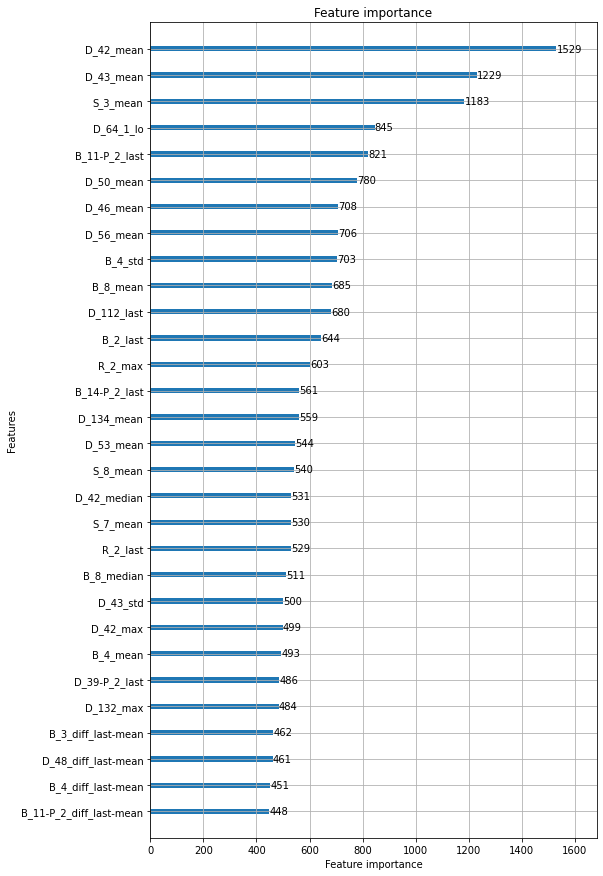

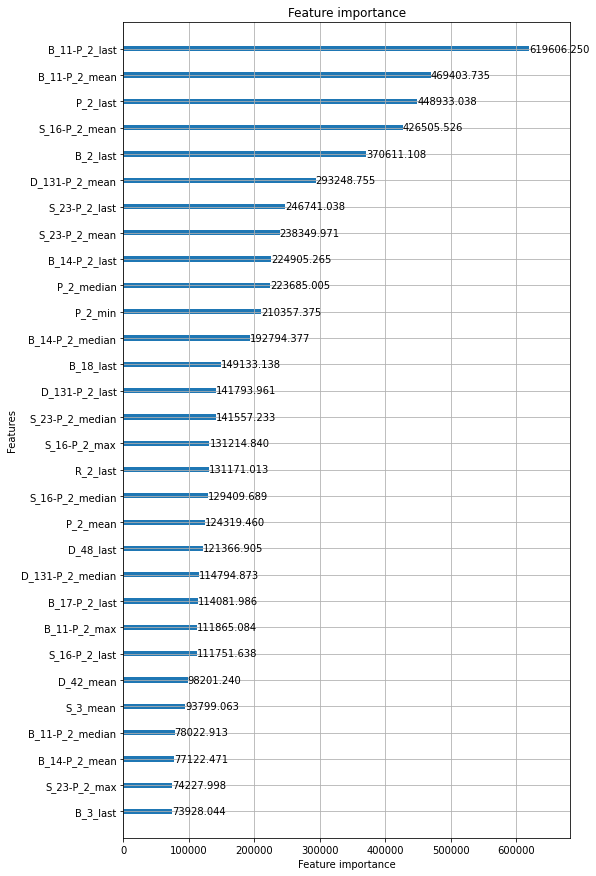

######################################## training model 3/5 ########################################
seed: 12


[50]	valid_0's amex_metric: 0.748756	valid_0's recall_at4: 0.598376	valid_0's norm_gini: 0.899137


[100]	valid_0's amex_metric: 0.75638	valid_0's recall_at4: 0.609484	valid_0's norm_gini: 0.903276


[150]	valid_0's amex_metric: 0.759905	valid_0's recall_at4: 0.614702	valid_0's norm_gini: 0.905108


[200]	valid_0's amex_metric: 0.762404	valid_0's recall_at4: 0.618447	valid_0's norm_gini: 0.906361


[250]	valid_0's amex_metric: 0.763937	valid_0's recall_at4: 0.620424	valid_0's norm_gini: 0.90745


[300]	valid_0's amex_metric: 0.76711	valid_0's recall_at4: 0.625347	valid_0's norm_gini: 0.908873


[350]	valid_0's amex_metric: 0.768826	valid_0's recall_at4: 0.627241	valid_0's norm_gini: 0.910412


[400]	valid_0's amex_metric: 0.772213	valid_0's recall_at4: 0.631995	valid_0's norm_gini: 0.91243


[450]	valid_0's amex_metric: 0.774908	valid_0's recall_at4: 0.636371	valid_0's norm_gini: 0.913444


[500]	valid_0's amex_metric: 0.777194	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.914652


[550]	valid_0's amex_metric: 0.778068	valid_0's recall_at4: 0.640663	valid_0's norm_gini: 0.915472


[600]	valid_0's amex_metric: 0.778388	valid_0's recall_at4: 0.640789	valid_0's norm_gini: 0.915986


[650]	valid_0's amex_metric: 0.779176	valid_0's recall_at4: 0.641715	valid_0's norm_gini: 0.916637


[700]	valid_0's amex_metric: 0.780459	valid_0's recall_at4: 0.643651	valid_0's norm_gini: 0.917267


[750]	valid_0's amex_metric: 0.781446	valid_0's recall_at4: 0.645207	valid_0's norm_gini: 0.917685


[800]	valid_0's amex_metric: 0.782587	valid_0's recall_at4: 0.647101	valid_0's norm_gini: 0.918073


[850]	valid_0's amex_metric: 0.783388	valid_0's recall_at4: 0.647985	valid_0's norm_gini: 0.918792


[900]	valid_0's amex_metric: 0.784744	valid_0's recall_at4: 0.650299	valid_0's norm_gini: 0.919189


[950]	valid_0's amex_metric: 0.785865	valid_0's recall_at4: 0.65194	valid_0's norm_gini: 0.91979


[1000]	valid_0's amex_metric: 0.787043	valid_0's recall_at4: 0.653749	valid_0's norm_gini: 0.920336


[1050]	valid_0's amex_metric: 0.787561	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.920616


[1100]	valid_0's amex_metric: 0.787484	valid_0's recall_at4: 0.65417	valid_0's norm_gini: 0.920798


[1150]	valid_0's amex_metric: 0.78847	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.921129


[1200]	valid_0's amex_metric: 0.789806	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.921445


[1250]	valid_0's amex_metric: 0.790229	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.921659


[1300]	valid_0's amex_metric: 0.790753	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.921824


[1350]	valid_0's amex_metric: 0.791378	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.922106


[1400]	valid_0's amex_metric: 0.791748	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.9223


[1450]	valid_0's amex_metric: 0.79247	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.922523


[1500]	valid_0's amex_metric: 0.792762	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.922771


[1550]	valid_0's amex_metric: 0.792858	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.922921


[1600]	valid_0's amex_metric: 0.793231	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.923036


[1650]	valid_0's amex_metric: 0.793784	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.923131


[1700]	valid_0's amex_metric: 0.793272	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923244


[1750]	valid_0's amex_metric: 0.793294	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923288


[1800]	valid_0's amex_metric: 0.793646	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.923361


[1850]	valid_0's amex_metric: 0.793641	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.923434


[1900]	valid_0's amex_metric: 0.793289	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.923488


[1950]	valid_0's amex_metric: 0.792915	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.923498


[2000]	valid_0's amex_metric: 0.793264	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.923564


[2050]	valid_0's amex_metric: 0.793126	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.923624


[2100]	valid_0's amex_metric: 0.793633	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.923712


[2150]	valid_0's amex_metric: 0.793775	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.923745


[2200]	valid_0's amex_metric: 0.794022	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.923817


[2250]	valid_0's amex_metric: 0.794314	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.923813


[2300]	valid_0's amex_metric: 0.794006	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.923828


[2350]	valid_0's amex_metric: 0.794628	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.923852


[2400]	valid_0's amex_metric: 0.794196	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.92387


[2450]	valid_0's amex_metric: 0.794038	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.923892


[2500]	valid_0's amex_metric: 0.794562	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.923972


[2550]	valid_0's amex_metric: 0.794504	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924024


[2600]	valid_0's amex_metric: 0.794696	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.924072


[2650]	valid_0's amex_metric: 0.794908	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924158


[2700]	valid_0's amex_metric: 0.795199	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924195


[2750]	valid_0's amex_metric: 0.795875	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924242


[2800]	valid_0's amex_metric: 0.795893	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924278


[2850]	valid_0's amex_metric: 0.796294	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.924321


[2900]	valid_0's amex_metric: 0.796119	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.924351


[2950]	valid_0's amex_metric: 0.79594	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924373


[3000]	valid_0's amex_metric: 0.796218	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924423


[3050]	valid_0's amex_metric: 0.796187	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924444


[3100]	valid_0's amex_metric: 0.795998	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924488


[3150]	valid_0's amex_metric: 0.796189	valid_0's recall_at4: 0.667845	valid_0's norm_gini: 0.924534


[3200]	valid_0's amex_metric: 0.796113	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.92455


[3250]	valid_0's amex_metric: 0.796181	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.924559


[3300]	valid_0's amex_metric: 0.796044	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924579


[3350]	valid_0's amex_metric: 0.796472	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924595


[3400]	valid_0's amex_metric: 0.796548	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.924619


[3450]	valid_0's amex_metric: 0.79672	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.92467


[3500]	valid_0's amex_metric: 0.796799	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.924702


[3550]	valid_0's amex_metric: 0.796631	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.924745


[3600]	valid_0's amex_metric: 0.797041	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924765


[3650]	valid_0's amex_metric: 0.796824	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.924793


[3700]	valid_0's amex_metric: 0.796981	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.924812


[3750]	valid_0's amex_metric: 0.79673	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.924857


[3800]	valid_0's amex_metric: 0.796618	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924887


[3850]	valid_0's amex_metric: 0.796865	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.924916


[3900]	valid_0's amex_metric: 0.797135	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924952


[3950]	valid_0's amex_metric: 0.796665	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.92498


[4000]	valid_0's amex_metric: 0.79668	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925011


[4050]	valid_0's amex_metric: 0.797259	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925033


[4100]	valid_0's amex_metric: 0.797343	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.925032


[4150]	valid_0's amex_metric: 0.796679	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.925051


[4200]	valid_0's amex_metric: 0.797278	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925069


[4250]	valid_0's amex_metric: 0.796951	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.92509


[4300]	valid_0's amex_metric: 0.796985	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.925115


[4350]	valid_0's amex_metric: 0.796799	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.925123


[4400]	valid_0's amex_metric: 0.797156	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925163


[4450]	valid_0's amex_metric: 0.797096	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.925169


[4500]	valid_0's amex_metric: 0.797327	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925168


[4550]	valid_0's amex_metric: 0.797167	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925184


[4600]	valid_0's amex_metric: 0.796916	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.925189


[4650]	valid_0's amex_metric: 0.796838	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.925201


[4700]	valid_0's amex_metric: 0.797271	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.925224


[4750]	valid_0's amex_metric: 0.797234	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.925235


[4800]	valid_0's amex_metric: 0.797574	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925242


[4850]	valid_0's amex_metric: 0.797647	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925261


[4900]	valid_0's amex_metric: 0.797234	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925276


[4950]	valid_0's amex_metric: 0.797148	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.925273


[5000]	valid_0's amex_metric: 0.797316	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925273


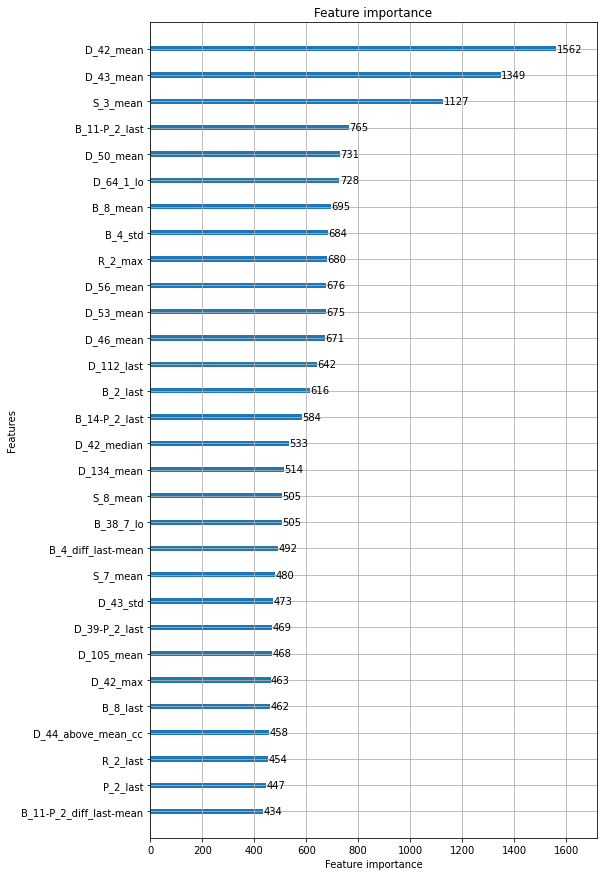

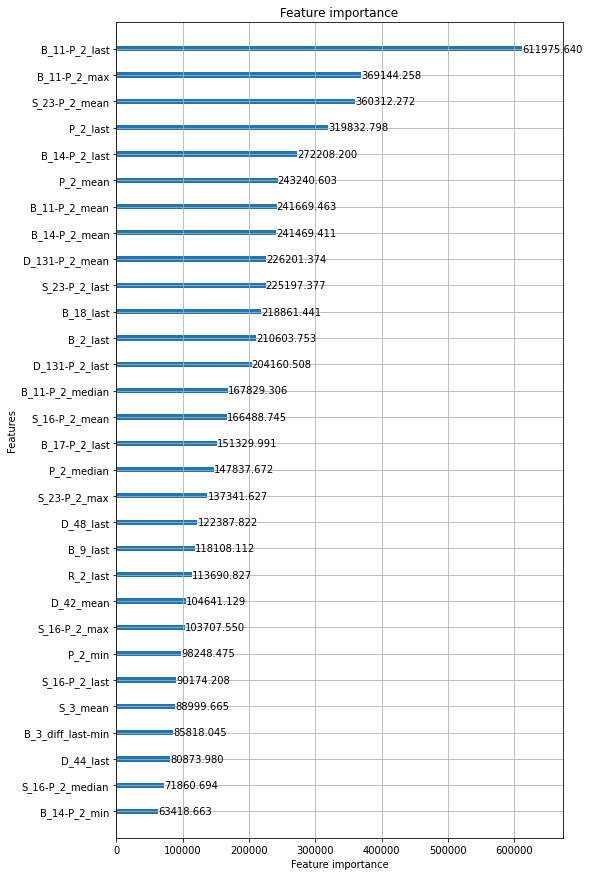

######################################## training model 4/5 ########################################
seed: 13


[50]	valid_0's amex_metric: 0.751587	valid_0's recall_at4: 0.60021	valid_0's norm_gini: 0.902963


[100]	valid_0's amex_metric: 0.757125	valid_0's recall_at4: 0.608247	valid_0's norm_gini: 0.906002


[150]	valid_0's amex_metric: 0.761833	valid_0's recall_at4: 0.615317	valid_0's norm_gini: 0.908349


[200]	valid_0's amex_metric: 0.765777	valid_0's recall_at4: 0.621755	valid_0's norm_gini: 0.909799


[250]	valid_0's amex_metric: 0.769075	valid_0's recall_at4: 0.626425	valid_0's norm_gini: 0.911725


[300]	valid_0's amex_metric: 0.772634	valid_0's recall_at4: 0.631475	valid_0's norm_gini: 0.913793


[350]	valid_0's amex_metric: 0.777365	valid_0's recall_at4: 0.638628	valid_0's norm_gini: 0.916101


[400]	valid_0's amex_metric: 0.78025	valid_0's recall_at4: 0.643257	valid_0's norm_gini: 0.917242


[450]	valid_0's amex_metric: 0.782358	valid_0's recall_at4: 0.646539	valid_0's norm_gini: 0.918177


[500]	valid_0's amex_metric: 0.783461	valid_0's recall_at4: 0.648054	valid_0's norm_gini: 0.918867


[550]	valid_0's amex_metric: 0.784968	valid_0's recall_at4: 0.6502	valid_0's norm_gini: 0.919736


[600]	valid_0's amex_metric: 0.786802	valid_0's recall_at4: 0.653145	valid_0's norm_gini: 0.920458


[650]	valid_0's amex_metric: 0.786681	valid_0's recall_at4: 0.65264	valid_0's norm_gini: 0.920721


[700]	valid_0's amex_metric: 0.787253	valid_0's recall_at4: 0.653482	valid_0's norm_gini: 0.921023


[750]	valid_0's amex_metric: 0.787994	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.921327


[800]	valid_0's amex_metric: 0.789169	valid_0's recall_at4: 0.65647	valid_0's norm_gini: 0.921869


[850]	valid_0's amex_metric: 0.791115	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.922394


[900]	valid_0's amex_metric: 0.792222	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.922925


[950]	valid_0's amex_metric: 0.793104	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.923258


[1000]	valid_0's amex_metric: 0.793651	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.923636


[1050]	valid_0's amex_metric: 0.79395	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.923898


[1100]	valid_0's amex_metric: 0.794354	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924159


[1150]	valid_0's amex_metric: 0.794659	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924306


[1200]	valid_0's amex_metric: 0.795261	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.9245


[1250]	valid_0's amex_metric: 0.795024	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924658


[1300]	valid_0's amex_metric: 0.795583	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.92485


[1350]	valid_0's amex_metric: 0.796047	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.924978


[1400]	valid_0's amex_metric: 0.796616	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.925107


[1450]	valid_0's amex_metric: 0.797391	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925309


[1500]	valid_0's amex_metric: 0.797656	valid_0's recall_at4: 0.669893	valid_0's norm_gini: 0.92542


[1550]	valid_0's amex_metric: 0.79749	valid_0's recall_at4: 0.66943	valid_0's norm_gini: 0.925551


[1600]	valid_0's amex_metric: 0.797881	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925701


[1650]	valid_0's amex_metric: 0.797953	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925803


[1700]	valid_0's amex_metric: 0.7985	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.925929


[1750]	valid_0's amex_metric: 0.798681	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926038


[1800]	valid_0's amex_metric: 0.798913	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.926123


[1850]	valid_0's amex_metric: 0.798972	valid_0's recall_at4: 0.671786	valid_0's norm_gini: 0.926158


[1900]	valid_0's amex_metric: 0.799409	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926232


[1950]	valid_0's amex_metric: 0.799324	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.926315


[2000]	valid_0's amex_metric: 0.799646	valid_0's recall_at4: 0.672922	valid_0's norm_gini: 0.92637


[2050]	valid_0's amex_metric: 0.799226	valid_0's recall_at4: 0.672039	valid_0's norm_gini: 0.926413


[2100]	valid_0's amex_metric: 0.799795	valid_0's recall_at4: 0.673133	valid_0's norm_gini: 0.926458


[2150]	valid_0's amex_metric: 0.800121	valid_0's recall_at4: 0.673722	valid_0's norm_gini: 0.926521


[2200]	valid_0's amex_metric: 0.800454	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926554


[2250]	valid_0's amex_metric: 0.800875	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.926639


[2300]	valid_0's amex_metric: 0.801121	valid_0's recall_at4: 0.675489	valid_0's norm_gini: 0.926753


[2350]	valid_0's amex_metric: 0.801293	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.926845


[2400]	valid_0's amex_metric: 0.801234	valid_0's recall_at4: 0.675573	valid_0's norm_gini: 0.926895


[2450]	valid_0's amex_metric: 0.800693	valid_0's recall_at4: 0.674437	valid_0's norm_gini: 0.926948


[2500]	valid_0's amex_metric: 0.801311	valid_0's recall_at4: 0.675615	valid_0's norm_gini: 0.927007


[2550]	valid_0's amex_metric: 0.801301	valid_0's recall_at4: 0.675573	valid_0's norm_gini: 0.927029


[2600]	valid_0's amex_metric: 0.801149	valid_0's recall_at4: 0.675237	valid_0's norm_gini: 0.927061


[2650]	valid_0's amex_metric: 0.80159	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.927102


[2700]	valid_0's amex_metric: 0.801636	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.927152


[2750]	valid_0's amex_metric: 0.801732	valid_0's recall_at4: 0.676289	valid_0's norm_gini: 0.927175


[2800]	valid_0's amex_metric: 0.80142	valid_0's recall_at4: 0.675615	valid_0's norm_gini: 0.927225


[2850]	valid_0's amex_metric: 0.801562	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.927257


[2900]	valid_0's amex_metric: 0.801604	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.927297


[2950]	valid_0's amex_metric: 0.801274	valid_0's recall_at4: 0.675237	valid_0's norm_gini: 0.927312


[3000]	valid_0's amex_metric: 0.801218	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927326


[3050]	valid_0's amex_metric: 0.80144	valid_0's recall_at4: 0.675531	valid_0's norm_gini: 0.927348


[3100]	valid_0's amex_metric: 0.801302	valid_0's recall_at4: 0.675237	valid_0's norm_gini: 0.927367


[3150]	valid_0's amex_metric: 0.801784	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.927406


[3200]	valid_0's amex_metric: 0.801942	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.927427


[3250]	valid_0's amex_metric: 0.801999	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927457


[3300]	valid_0's amex_metric: 0.801544	valid_0's recall_at4: 0.675615	valid_0's norm_gini: 0.927473


[3350]	valid_0's amex_metric: 0.801545	valid_0's recall_at4: 0.675573	valid_0's norm_gini: 0.927516


[3400]	valid_0's amex_metric: 0.801524	valid_0's recall_at4: 0.675531	valid_0's norm_gini: 0.927517


[3450]	valid_0's amex_metric: 0.801701	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.927535


[3500]	valid_0's amex_metric: 0.801749	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927545


[3550]	valid_0's amex_metric: 0.801748	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927543


[3600]	valid_0's amex_metric: 0.802464	valid_0's recall_at4: 0.677383	valid_0's norm_gini: 0.927545


[3650]	valid_0's amex_metric: 0.80242	valid_0's recall_at4: 0.677256	valid_0's norm_gini: 0.927584


[3700]	valid_0's amex_metric: 0.8026	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.927607


[3750]	valid_0's amex_metric: 0.802976	valid_0's recall_at4: 0.678308	valid_0's norm_gini: 0.927644


[3800]	valid_0's amex_metric: 0.802779	valid_0's recall_at4: 0.677888	valid_0's norm_gini: 0.927669


[3850]	valid_0's amex_metric: 0.802576	valid_0's recall_at4: 0.677467	valid_0's norm_gini: 0.927685


[3900]	valid_0's amex_metric: 0.802933	valid_0's recall_at4: 0.67814	valid_0's norm_gini: 0.927726


[3950]	valid_0's amex_metric: 0.802704	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.927732


[4000]	valid_0's amex_metric: 0.802593	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927762


[4050]	valid_0's amex_metric: 0.802903	valid_0's recall_at4: 0.678014	valid_0's norm_gini: 0.927792


[4100]	valid_0's amex_metric: 0.803146	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.927816


[4150]	valid_0's amex_metric: 0.80292	valid_0's recall_at4: 0.678014	valid_0's norm_gini: 0.927827


[4200]	valid_0's amex_metric: 0.802824	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.927844


[4250]	valid_0's amex_metric: 0.803164	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.927851


[4300]	valid_0's amex_metric: 0.802955	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.927854


[4350]	valid_0's amex_metric: 0.803035	valid_0's recall_at4: 0.678182	valid_0's norm_gini: 0.927887


[4400]	valid_0's amex_metric: 0.803096	valid_0's recall_at4: 0.678308	valid_0's norm_gini: 0.927884


[4450]	valid_0's amex_metric: 0.803089	valid_0's recall_at4: 0.678266	valid_0's norm_gini: 0.927912


[4500]	valid_0's amex_metric: 0.802443	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927925


[4550]	valid_0's amex_metric: 0.802744	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.927936


[4600]	valid_0's amex_metric: 0.803045	valid_0's recall_at4: 0.67814	valid_0's norm_gini: 0.92795


[4650]	valid_0's amex_metric: 0.803138	valid_0's recall_at4: 0.678308	valid_0's norm_gini: 0.927968


[4700]	valid_0's amex_metric: 0.803398	valid_0's recall_at4: 0.678813	valid_0's norm_gini: 0.927983


[4750]	valid_0's amex_metric: 0.803024	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.927992


[4800]	valid_0's amex_metric: 0.803263	valid_0's recall_at4: 0.678519	valid_0's norm_gini: 0.928007


[4850]	valid_0's amex_metric: 0.802892	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.928023


[4900]	valid_0's amex_metric: 0.802801	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.928051


[4950]	valid_0's amex_metric: 0.803016	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.928061


[5000]	valid_0's amex_metric: 0.803672	valid_0's recall_at4: 0.679276	valid_0's norm_gini: 0.928067


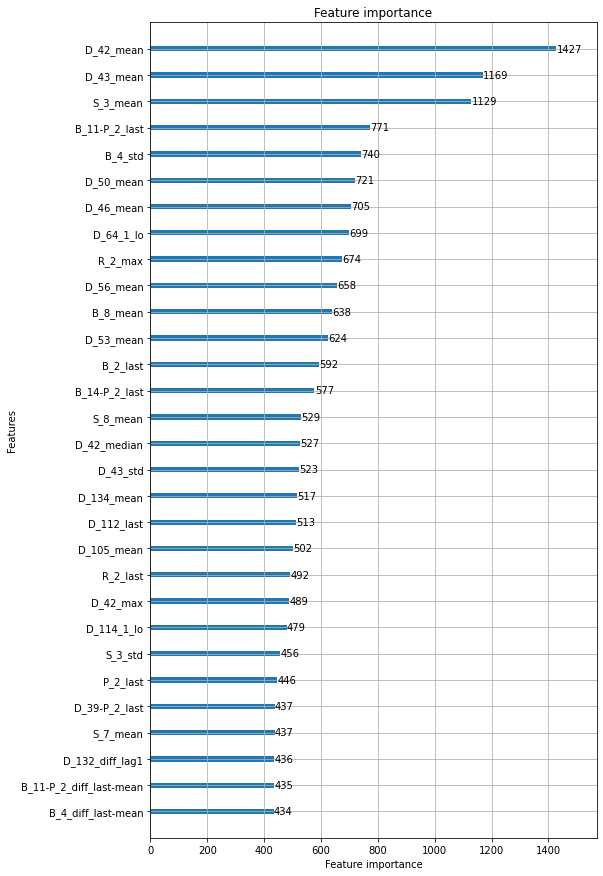

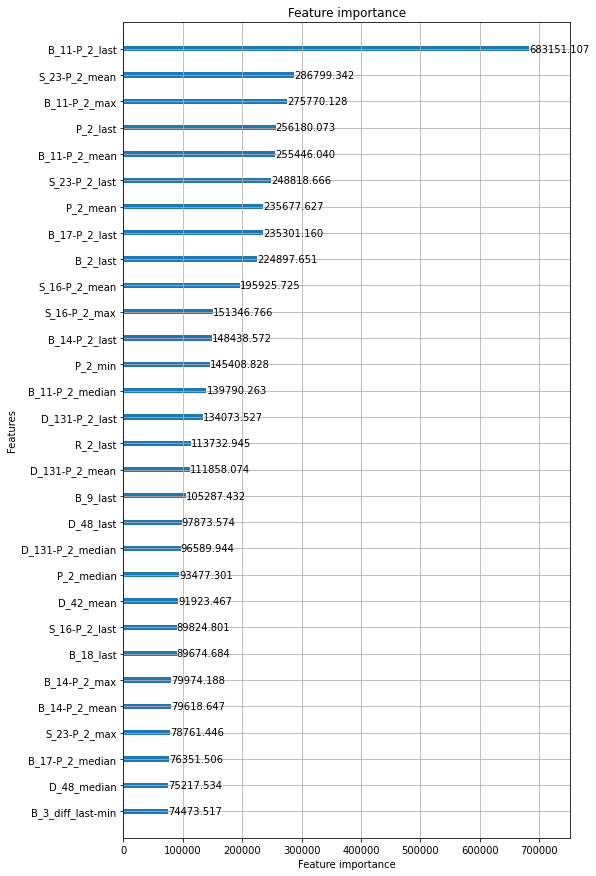

######################################## training model 5/5 ########################################
seed: 14


[50]	valid_0's amex_metric: 0.746873	valid_0's recall_at4: 0.595119	valid_0's norm_gini: 0.898626


[100]	valid_0's amex_metric: 0.756835	valid_0's recall_at4: 0.609762	valid_0's norm_gini: 0.903907


[150]	valid_0's amex_metric: 0.763999	valid_0's recall_at4: 0.620072	valid_0's norm_gini: 0.907926


[200]	valid_0's amex_metric: 0.76741	valid_0's recall_at4: 0.625121	valid_0's norm_gini: 0.909699


[250]	valid_0's amex_metric: 0.771487	valid_0's recall_at4: 0.630717	valid_0's norm_gini: 0.912256


[300]	valid_0's amex_metric: 0.773214	valid_0's recall_at4: 0.633158	valid_0's norm_gini: 0.91327


[350]	valid_0's amex_metric: 0.775692	valid_0's recall_at4: 0.637155	valid_0's norm_gini: 0.914229


[400]	valid_0's amex_metric: 0.777166	valid_0's recall_at4: 0.639091	valid_0's norm_gini: 0.91524


[450]	valid_0's amex_metric: 0.778016	valid_0's recall_at4: 0.640269	valid_0's norm_gini: 0.915762


[500]	valid_0's amex_metric: 0.779035	valid_0's recall_at4: 0.641742	valid_0's norm_gini: 0.916327


[550]	valid_0's amex_metric: 0.779762	valid_0's recall_at4: 0.642668	valid_0's norm_gini: 0.916856


[600]	valid_0's amex_metric: 0.780207	valid_0's recall_at4: 0.643131	valid_0's norm_gini: 0.917283


[650]	valid_0's amex_metric: 0.781032	valid_0's recall_at4: 0.644393	valid_0's norm_gini: 0.917672


[700]	valid_0's amex_metric: 0.781886	valid_0's recall_at4: 0.645571	valid_0's norm_gini: 0.918202


[750]	valid_0's amex_metric: 0.782426	valid_0's recall_at4: 0.646287	valid_0's norm_gini: 0.918565


[800]	valid_0's amex_metric: 0.782927	valid_0's recall_at4: 0.647044	valid_0's norm_gini: 0.918811


[850]	valid_0's amex_metric: 0.783836	valid_0's recall_at4: 0.648433	valid_0's norm_gini: 0.919239


[900]	valid_0's amex_metric: 0.784112	valid_0's recall_at4: 0.648601	valid_0's norm_gini: 0.919623


[950]	valid_0's amex_metric: 0.784791	valid_0's recall_at4: 0.649695	valid_0's norm_gini: 0.919888


[1000]	valid_0's amex_metric: 0.784647	valid_0's recall_at4: 0.649064	valid_0's norm_gini: 0.920231


[1050]	valid_0's amex_metric: 0.785514	valid_0's recall_at4: 0.650621	valid_0's norm_gini: 0.920407


[1100]	valid_0's amex_metric: 0.786146	valid_0's recall_at4: 0.651673	valid_0's norm_gini: 0.920619


[1150]	valid_0's amex_metric: 0.786982	valid_0's recall_at4: 0.653103	valid_0's norm_gini: 0.920861


[1200]	valid_0's amex_metric: 0.787074	valid_0's recall_at4: 0.653103	valid_0's norm_gini: 0.921044


[1250]	valid_0's amex_metric: 0.787249	valid_0's recall_at4: 0.653356	valid_0's norm_gini: 0.921141


[1300]	valid_0's amex_metric: 0.787476	valid_0's recall_at4: 0.653692	valid_0's norm_gini: 0.92126


[1350]	valid_0's amex_metric: 0.787677	valid_0's recall_at4: 0.653945	valid_0's norm_gini: 0.921409


[1400]	valid_0's amex_metric: 0.787889	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.921539


[1450]	valid_0's amex_metric: 0.788055	valid_0's recall_at4: 0.65445	valid_0's norm_gini: 0.92166


[1500]	valid_0's amex_metric: 0.788358	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.92172


[1550]	valid_0's amex_metric: 0.78831	valid_0's recall_at4: 0.654829	valid_0's norm_gini: 0.921792


[1600]	valid_0's amex_metric: 0.788544	valid_0's recall_at4: 0.655249	valid_0's norm_gini: 0.921839


[1650]	valid_0's amex_metric: 0.788962	valid_0's recall_at4: 0.656049	valid_0's norm_gini: 0.921875


[1700]	valid_0's amex_metric: 0.788768	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.921909


[1750]	valid_0's amex_metric: 0.789286	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.921976


[1800]	valid_0's amex_metric: 0.789524	valid_0's recall_at4: 0.656975	valid_0's norm_gini: 0.922074


[1850]	valid_0's amex_metric: 0.789853	valid_0's recall_at4: 0.657522	valid_0's norm_gini: 0.922184


[1900]	valid_0's amex_metric: 0.790239	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.922283


[1950]	valid_0's amex_metric: 0.790317	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922355


[2000]	valid_0's amex_metric: 0.790785	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.92245


[2050]	valid_0's amex_metric: 0.790625	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.92255


[2100]	valid_0's amex_metric: 0.791023	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.92263


[2150]	valid_0's amex_metric: 0.790849	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.922703


[2200]	valid_0's amex_metric: 0.791134	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.922768


[2250]	valid_0's amex_metric: 0.791056	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.922824


[2300]	valid_0's amex_metric: 0.791061	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.922916


[2350]	valid_0's amex_metric: 0.791183	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.922993


[2400]	valid_0's amex_metric: 0.791157	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.923066


[2450]	valid_0's amex_metric: 0.791535	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923108


[2500]	valid_0's amex_metric: 0.791736	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.92313


[2550]	valid_0's amex_metric: 0.791922	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.923166


[2600]	valid_0's amex_metric: 0.79158	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923198


[2650]	valid_0's amex_metric: 0.791547	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.923217


[2700]	valid_0's amex_metric: 0.791812	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.923241


[2750]	valid_0's amex_metric: 0.791493	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923235


[2800]	valid_0's amex_metric: 0.791359	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.923261


[2850]	valid_0's amex_metric: 0.791371	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.923284


[2900]	valid_0's amex_metric: 0.791624	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.923327


[2950]	valid_0's amex_metric: 0.791685	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.923365


[3000]	valid_0's amex_metric: 0.79166	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.923399


[3050]	valid_0's amex_metric: 0.791969	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.92343


[3100]	valid_0's amex_metric: 0.792015	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.923437


[3150]	valid_0's amex_metric: 0.791718	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923475


[3200]	valid_0's amex_metric: 0.791346	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.92353


[3250]	valid_0's amex_metric: 0.791761	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.92356


[3300]	valid_0's amex_metric: 0.792303	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.923591


[3350]	valid_0's amex_metric: 0.792315	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.923616


[3400]	valid_0's amex_metric: 0.791788	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923615


[3450]	valid_0's amex_metric: 0.792049	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.92363


[3500]	valid_0's amex_metric: 0.792069	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.923629


[3550]	valid_0's amex_metric: 0.791619	valid_0's recall_at4: 0.659583	valid_0's norm_gini: 0.923654


[3600]	valid_0's amex_metric: 0.791814	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923666


[3650]	valid_0's amex_metric: 0.791501	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.92367


[3700]	valid_0's amex_metric: 0.791699	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.923689


[3750]	valid_0's amex_metric: 0.791833	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923704


[3800]	valid_0's amex_metric: 0.792131	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.923711


[3850]	valid_0's amex_metric: 0.791792	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.923749


[3900]	valid_0's amex_metric: 0.791887	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.92377


[3950]	valid_0's amex_metric: 0.791873	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923784


[4000]	valid_0's amex_metric: 0.79225	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.923781


[4050]	valid_0's amex_metric: 0.791774	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923797


[4100]	valid_0's amex_metric: 0.792375	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.92382


[4150]	valid_0's amex_metric: 0.792169	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.923828


[4200]	valid_0's amex_metric: 0.792877	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.923857


[4250]	valid_0's amex_metric: 0.79249	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.923882


[4300]	valid_0's amex_metric: 0.792503	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.923908


[4350]	valid_0's amex_metric: 0.793025	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.923942


[4400]	valid_0's amex_metric: 0.793036	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.923964


[4450]	valid_0's amex_metric: 0.793098	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.923962


[4500]	valid_0's amex_metric: 0.793268	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.923966


[4550]	valid_0's amex_metric: 0.792811	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923977


[4600]	valid_0's amex_metric: 0.792975	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.923969


[4650]	valid_0's amex_metric: 0.792816	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923986


[4700]	valid_0's amex_metric: 0.792849	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.92401


[4750]	valid_0's amex_metric: 0.793063	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.924018


[4800]	valid_0's amex_metric: 0.792943	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.92403


[4850]	valid_0's amex_metric: 0.793073	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.924038


[4900]	valid_0's amex_metric: 0.793403	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924025


[4950]	valid_0's amex_metric: 0.793301	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.924031


[5000]	valid_0's amex_metric: 0.793336	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.924059


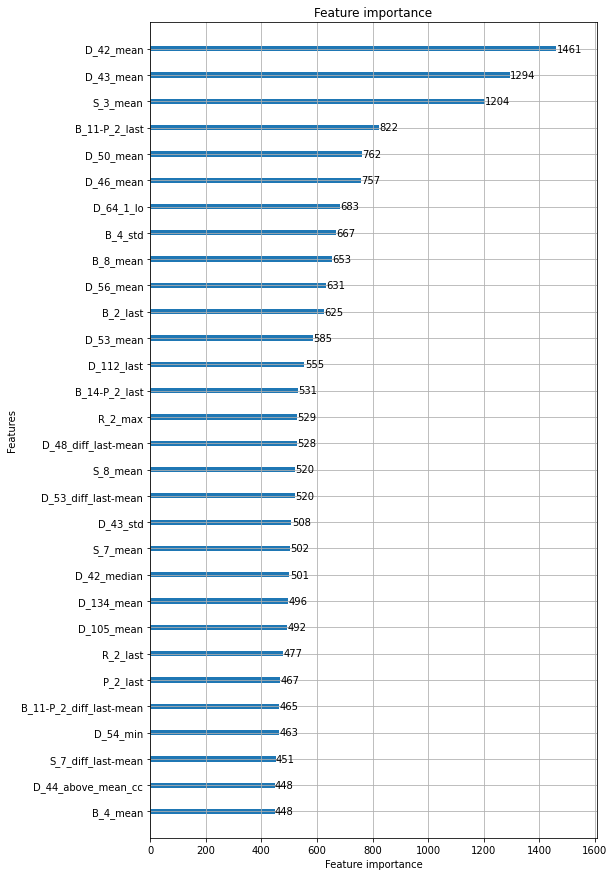

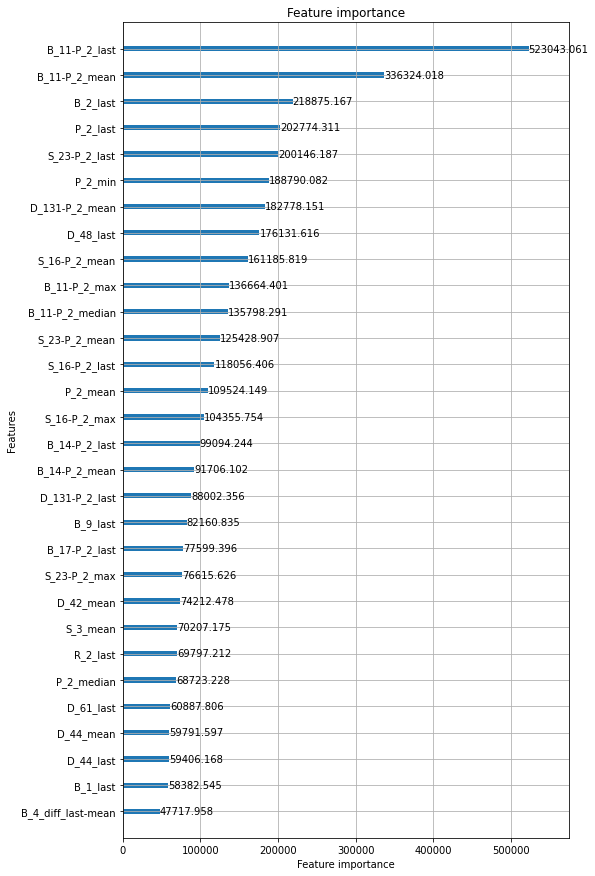

Training time: 72.92212051153183 min.
OOF recall_at4: 0.6659457366950551
OOF normalized_gini: 0.9250706426842897
OOF competition metric: 0.7955081896896724


############################### repeated cross-validation step: 4/5 ################################


######################################## training model 1/5 ########################################
seed: 15


[50]	valid_0's amex_metric: 0.745947	valid_0's recall_at4: 0.594505	valid_0's norm_gini: 0.89739


[100]	valid_0's amex_metric: 0.754675	valid_0's recall_at4: 0.607002	valid_0's norm_gini: 0.902348


[150]	valid_0's amex_metric: 0.761765	valid_0's recall_at4: 0.618068	valid_0's norm_gini: 0.905462


[200]	valid_0's amex_metric: 0.76442	valid_0's recall_at4: 0.621729	valid_0's norm_gini: 0.907112


[250]	valid_0's amex_metric: 0.765684	valid_0's recall_at4: 0.622444	valid_0's norm_gini: 0.908925


[300]	valid_0's amex_metric: 0.769258	valid_0's recall_at4: 0.62783	valid_0's norm_gini: 0.910686


[350]	valid_0's amex_metric: 0.771695	valid_0's recall_at4: 0.631322	valid_0's norm_gini: 0.912068


[400]	valid_0's amex_metric: 0.774152	valid_0's recall_at4: 0.635067	valid_0's norm_gini: 0.913238


[450]	valid_0's amex_metric: 0.774503	valid_0's recall_at4: 0.635488	valid_0's norm_gini: 0.913519


[500]	valid_0's amex_metric: 0.775265	valid_0's recall_at4: 0.636371	valid_0's norm_gini: 0.914158


[550]	valid_0's amex_metric: 0.776464	valid_0's recall_at4: 0.638054	valid_0's norm_gini: 0.914873


[600]	valid_0's amex_metric: 0.778243	valid_0's recall_at4: 0.640958	valid_0's norm_gini: 0.915529


[650]	valid_0's amex_metric: 0.778831	valid_0's recall_at4: 0.641421	valid_0's norm_gini: 0.916242


[700]	valid_0's amex_metric: 0.780498	valid_0's recall_at4: 0.644113	valid_0's norm_gini: 0.916883


[750]	valid_0's amex_metric: 0.781235	valid_0's recall_at4: 0.645081	valid_0's norm_gini: 0.917388


[800]	valid_0's amex_metric: 0.78192	valid_0's recall_at4: 0.646007	valid_0's norm_gini: 0.917834


[850]	valid_0's amex_metric: 0.782169	valid_0's recall_at4: 0.646133	valid_0's norm_gini: 0.918206


[900]	valid_0's amex_metric: 0.782901	valid_0's recall_at4: 0.647269	valid_0's norm_gini: 0.918532


[950]	valid_0's amex_metric: 0.783061	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.918811


[1000]	valid_0's amex_metric: 0.784071	valid_0's recall_at4: 0.649078	valid_0's norm_gini: 0.919064


[1050]	valid_0's amex_metric: 0.784692	valid_0's recall_at4: 0.64992	valid_0's norm_gini: 0.919464


[1100]	valid_0's amex_metric: 0.785217	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.919757


[1150]	valid_0's amex_metric: 0.785703	valid_0's recall_at4: 0.651519	valid_0's norm_gini: 0.919887


[1200]	valid_0's amex_metric: 0.786394	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.920133


[1250]	valid_0's amex_metric: 0.786377	valid_0's recall_at4: 0.652529	valid_0's norm_gini: 0.920226


[1300]	valid_0's amex_metric: 0.786974	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.920367


[1350]	valid_0's amex_metric: 0.787197	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.920477


[1400]	valid_0's amex_metric: 0.7875	valid_0's recall_at4: 0.654464	valid_0's norm_gini: 0.920536


[1450]	valid_0's amex_metric: 0.787382	valid_0's recall_at4: 0.654086	valid_0's norm_gini: 0.920678


[1500]	valid_0's amex_metric: 0.787222	valid_0's recall_at4: 0.653623	valid_0's norm_gini: 0.92082


[1550]	valid_0's amex_metric: 0.787271	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.920961


[1600]	valid_0's amex_metric: 0.788539	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.92114


[1650]	valid_0's amex_metric: 0.789208	valid_0's recall_at4: 0.657115	valid_0's norm_gini: 0.921301


[1700]	valid_0's amex_metric: 0.788945	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.921405


[1750]	valid_0's amex_metric: 0.78893	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.921501


[1800]	valid_0's amex_metric: 0.788971	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.921542


[1850]	valid_0's amex_metric: 0.789506	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.921601


[1900]	valid_0's amex_metric: 0.789421	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.921684


[1950]	valid_0's amex_metric: 0.789756	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.921765


[2000]	valid_0's amex_metric: 0.789787	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.92187


[2050]	valid_0's amex_metric: 0.790404	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.921967


[2100]	valid_0's amex_metric: 0.790214	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.92205


[2150]	valid_0's amex_metric: 0.789845	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.922069


[2200]	valid_0's amex_metric: 0.79002	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.922125


[2250]	valid_0's amex_metric: 0.790457	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.922157


[2300]	valid_0's amex_metric: 0.790555	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.922227


[2350]	valid_0's amex_metric: 0.790025	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.922304


[2400]	valid_0's amex_metric: 0.790189	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.922338


[2450]	valid_0's amex_metric: 0.790332	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.92237


[2500]	valid_0's amex_metric: 0.790143	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.922414


[2550]	valid_0's amex_metric: 0.789931	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922452


[2600]	valid_0's amex_metric: 0.79011	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.922516


[2650]	valid_0's amex_metric: 0.790238	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.922562


[2700]	valid_0's amex_metric: 0.79025	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.922628


[2750]	valid_0's amex_metric: 0.789892	valid_0's recall_at4: 0.657115	valid_0's norm_gini: 0.922669


[2800]	valid_0's amex_metric: 0.790347	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.922695


[2850]	valid_0's amex_metric: 0.790337	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.922758


[2900]	valid_0's amex_metric: 0.790295	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.922802


[2950]	valid_0's amex_metric: 0.790455	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.92287


[3000]	valid_0's amex_metric: 0.790228	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.922919


[3050]	valid_0's amex_metric: 0.790385	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.922939


[3100]	valid_0's amex_metric: 0.790196	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922982


[3150]	valid_0's amex_metric: 0.791206	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.923024


[3200]	valid_0's amex_metric: 0.790652	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923053


[3250]	valid_0's amex_metric: 0.790692	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.92309


[3300]	valid_0's amex_metric: 0.791116	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923138


[3350]	valid_0's amex_metric: 0.791318	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.923164


[3400]	valid_0's amex_metric: 0.791384	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.923171


[3450]	valid_0's amex_metric: 0.791727	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.923182


[3500]	valid_0's amex_metric: 0.791929	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.923166


[3550]	valid_0's amex_metric: 0.79187	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923174


[3600]	valid_0's amex_metric: 0.791915	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.92318


[3650]	valid_0's amex_metric: 0.792179	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.923204


[3700]	valid_0's amex_metric: 0.792406	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.923236


[3750]	valid_0's amex_metric: 0.792196	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.92328


[3800]	valid_0's amex_metric: 0.792153	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923277


[3850]	valid_0's amex_metric: 0.791696	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.92329


[3900]	valid_0's amex_metric: 0.792094	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.923328


[3950]	valid_0's amex_metric: 0.791638	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923341


[4000]	valid_0's amex_metric: 0.791577	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.923345


[4050]	valid_0's amex_metric: 0.791987	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.923366


[4100]	valid_0's amex_metric: 0.792089	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923402


[4150]	valid_0's amex_metric: 0.792092	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923409


[4200]	valid_0's amex_metric: 0.792183	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.923421


[4250]	valid_0's amex_metric: 0.792651	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.923431


[4300]	valid_0's amex_metric: 0.7921	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923424


[4350]	valid_0's amex_metric: 0.792422	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923436


[4400]	valid_0's amex_metric: 0.792064	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.923436


[4450]	valid_0's amex_metric: 0.79171	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923443


[4500]	valid_0's amex_metric: 0.791296	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.923458


[4550]	valid_0's amex_metric: 0.791936	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923475


[4600]	valid_0's amex_metric: 0.792226	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923466


[4650]	valid_0's amex_metric: 0.792704	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.923453


[4700]	valid_0's amex_metric: 0.792105	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923475


[4750]	valid_0's amex_metric: 0.791868	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.923507


[4800]	valid_0's amex_metric: 0.792381	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923524


[4850]	valid_0's amex_metric: 0.791862	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.923537


[4900]	valid_0's amex_metric: 0.791695	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.923539


[4950]	valid_0's amex_metric: 0.791931	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.923549


[5000]	valid_0's amex_metric: 0.792016	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.923551


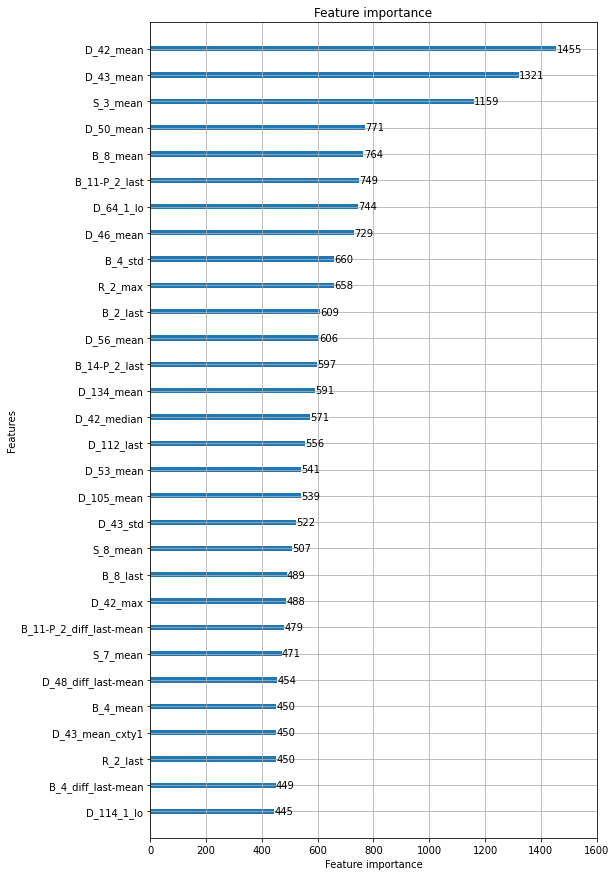

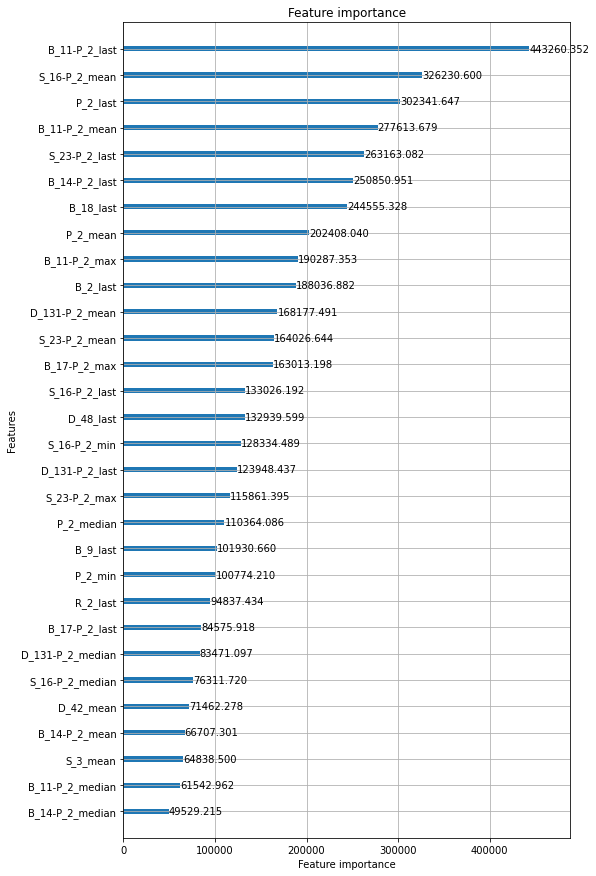

######################################## training model 2/5 ########################################
seed: 16


[50]	valid_0's amex_metric: 0.751934	valid_0's recall_at4: 0.602668	valid_0's norm_gini: 0.9012


[100]	valid_0's amex_metric: 0.755776	valid_0's recall_at4: 0.608096	valid_0's norm_gini: 0.903456


[150]	valid_0's amex_metric: 0.759997	valid_0's recall_at4: 0.613355	valid_0's norm_gini: 0.906638


[200]	valid_0's amex_metric: 0.768153	valid_0's recall_at4: 0.625894	valid_0's norm_gini: 0.910411


[250]	valid_0's amex_metric: 0.770353	valid_0's recall_at4: 0.628924	valid_0's norm_gini: 0.911782


[300]	valid_0's amex_metric: 0.77111	valid_0's recall_at4: 0.629597	valid_0's norm_gini: 0.912624


[350]	valid_0's amex_metric: 0.773739	valid_0's recall_at4: 0.63351	valid_0's norm_gini: 0.913969


[400]	valid_0's amex_metric: 0.776351	valid_0's recall_at4: 0.637044	valid_0's norm_gini: 0.915657


[450]	valid_0's amex_metric: 0.778052	valid_0's recall_at4: 0.639569	valid_0's norm_gini: 0.916535


[500]	valid_0's amex_metric: 0.77958	valid_0's recall_at4: 0.641799	valid_0's norm_gini: 0.91736


[550]	valid_0's amex_metric: 0.780158	valid_0's recall_at4: 0.642599	valid_0's norm_gini: 0.917716


[600]	valid_0's amex_metric: 0.781324	valid_0's recall_at4: 0.644198	valid_0's norm_gini: 0.91845


[650]	valid_0's amex_metric: 0.783169	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.919026


[700]	valid_0's amex_metric: 0.783203	valid_0's recall_at4: 0.647269	valid_0's norm_gini: 0.919136


[750]	valid_0's amex_metric: 0.783669	valid_0's recall_at4: 0.647942	valid_0's norm_gini: 0.919395


[800]	valid_0's amex_metric: 0.785308	valid_0's recall_at4: 0.650593	valid_0's norm_gini: 0.920024


[850]	valid_0's amex_metric: 0.78692	valid_0's recall_at4: 0.653244	valid_0's norm_gini: 0.920595


[900]	valid_0's amex_metric: 0.787611	valid_0's recall_at4: 0.654086	valid_0's norm_gini: 0.921137


[950]	valid_0's amex_metric: 0.788524	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.921447


[1000]	valid_0's amex_metric: 0.789058	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.921758


[1050]	valid_0's amex_metric: 0.789515	valid_0's recall_at4: 0.657031	valid_0's norm_gini: 0.921999


[1100]	valid_0's amex_metric: 0.79049	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.922097


[1150]	valid_0's amex_metric: 0.789822	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.922276


[1200]	valid_0's amex_metric: 0.791453	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.922509


[1250]	valid_0's amex_metric: 0.791332	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.922729


[1300]	valid_0's amex_metric: 0.791461	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.922861


[1350]	valid_0's amex_metric: 0.791712	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923027


[1400]	valid_0's amex_metric: 0.791753	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.923068


[1450]	valid_0's amex_metric: 0.792725	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923201


[1500]	valid_0's amex_metric: 0.792373	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.92334


[1550]	valid_0's amex_metric: 0.793077	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.923527


[1600]	valid_0's amex_metric: 0.793633	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.923671


[1650]	valid_0's amex_metric: 0.792858	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.923762


[1700]	valid_0's amex_metric: 0.793288	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.923865


[1750]	valid_0's amex_metric: 0.793626	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923952


[1800]	valid_0's amex_metric: 0.794124	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924021


[1850]	valid_0's amex_metric: 0.794698	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.924076


[1900]	valid_0's amex_metric: 0.794868	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.924163


[1950]	valid_0's amex_metric: 0.795029	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924232


[2000]	valid_0's amex_metric: 0.795214	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924309


[2050]	valid_0's amex_metric: 0.795316	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.924345


[2100]	valid_0's amex_metric: 0.794689	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924394


[2150]	valid_0's amex_metric: 0.794619	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924422


[2200]	valid_0's amex_metric: 0.794785	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.92446


[2250]	valid_0's amex_metric: 0.795347	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924491


[2300]	valid_0's amex_metric: 0.795862	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.924553


[2350]	valid_0's amex_metric: 0.795474	valid_0's recall_at4: 0.66633	valid_0's norm_gini: 0.924619


[2400]	valid_0's amex_metric: 0.795335	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.924634


[2450]	valid_0's amex_metric: 0.794831	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924679


[2500]	valid_0's amex_metric: 0.795504	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.92472


[2550]	valid_0's amex_metric: 0.795853	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.924787


[2600]	valid_0's amex_metric: 0.795922	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.924841


[2650]	valid_0's amex_metric: 0.796214	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.924878


[2700]	valid_0's amex_metric: 0.79598	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.924915


[2750]	valid_0's amex_metric: 0.795581	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924958


[2800]	valid_0's amex_metric: 0.796336	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.924995


[2850]	valid_0's amex_metric: 0.796652	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.925038


[2900]	valid_0's amex_metric: 0.796711	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925073


[2950]	valid_0's amex_metric: 0.796747	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.925102


[3000]	valid_0's amex_metric: 0.796726	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.925145


[3050]	valid_0's amex_metric: 0.796764	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925179


[3100]	valid_0's amex_metric: 0.796781	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925212


[3150]	valid_0's amex_metric: 0.796974	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.925261


[3200]	valid_0's amex_metric: 0.797096	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925296


[3250]	valid_0's amex_metric: 0.797041	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.925312


[3300]	valid_0's amex_metric: 0.797118	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925338


[3350]	valid_0's amex_metric: 0.797121	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925346


[3400]	valid_0's amex_metric: 0.797283	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925374


[3450]	valid_0's amex_metric: 0.797315	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.925397


[3500]	valid_0's amex_metric: 0.797308	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925426


[3550]	valid_0's amex_metric: 0.797679	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925452


[3600]	valid_0's amex_metric: 0.797963	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925472


[3650]	valid_0's amex_metric: 0.798175	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925476


[3700]	valid_0's amex_metric: 0.798313	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925499


[3750]	valid_0's amex_metric: 0.798421	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925505


[3800]	valid_0's amex_metric: 0.798216	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925515


[3850]	valid_0's amex_metric: 0.798335	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925544


[3900]	valid_0's amex_metric: 0.798087	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925552


[3950]	valid_0's amex_metric: 0.797944	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925561


[4000]	valid_0's amex_metric: 0.798294	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925587


[4050]	valid_0's amex_metric: 0.797998	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.925584


[4100]	valid_0's amex_metric: 0.798241	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925607


[4150]	valid_0's amex_metric: 0.798022	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.925632


[4200]	valid_0's amex_metric: 0.797737	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925651


[4250]	valid_0's amex_metric: 0.798188	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925671


[4300]	valid_0's amex_metric: 0.79799	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925695


[4350]	valid_0's amex_metric: 0.798378	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925713


[4400]	valid_0's amex_metric: 0.798813	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925742


[4450]	valid_0's amex_metric: 0.799219	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.925755


[4500]	valid_0's amex_metric: 0.799318	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925784


[4550]	valid_0's amex_metric: 0.799243	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.925802


[4600]	valid_0's amex_metric: 0.799717	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.925825


[4650]	valid_0's amex_metric: 0.799591	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.925867


[4700]	valid_0's amex_metric: 0.799257	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.925872


[4750]	valid_0's amex_metric: 0.799451	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925882


[4800]	valid_0's amex_metric: 0.799546	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925903


[4850]	valid_0's amex_metric: 0.799251	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.925903


[4900]	valid_0's amex_metric: 0.799403	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925911


[4950]	valid_0's amex_metric: 0.799382	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925912


[5000]	valid_0's amex_metric: 0.799575	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.925919


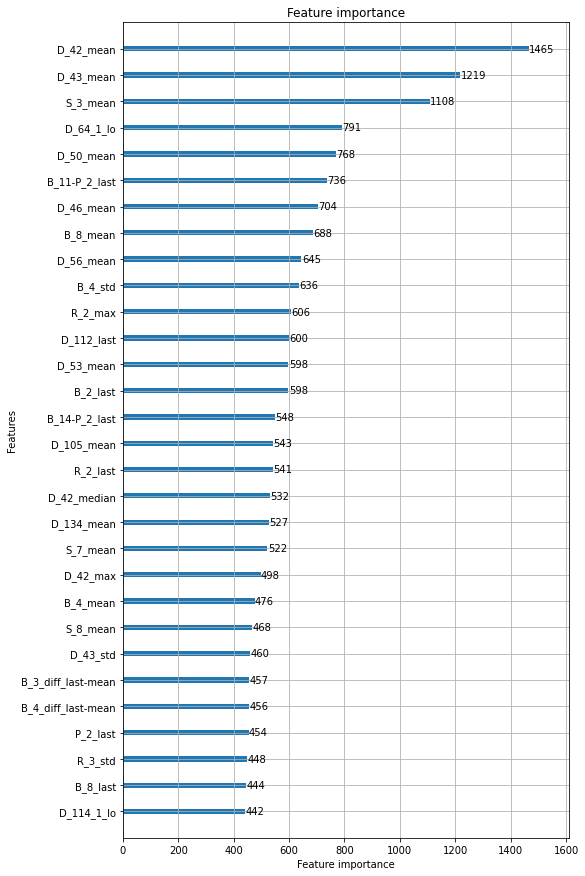

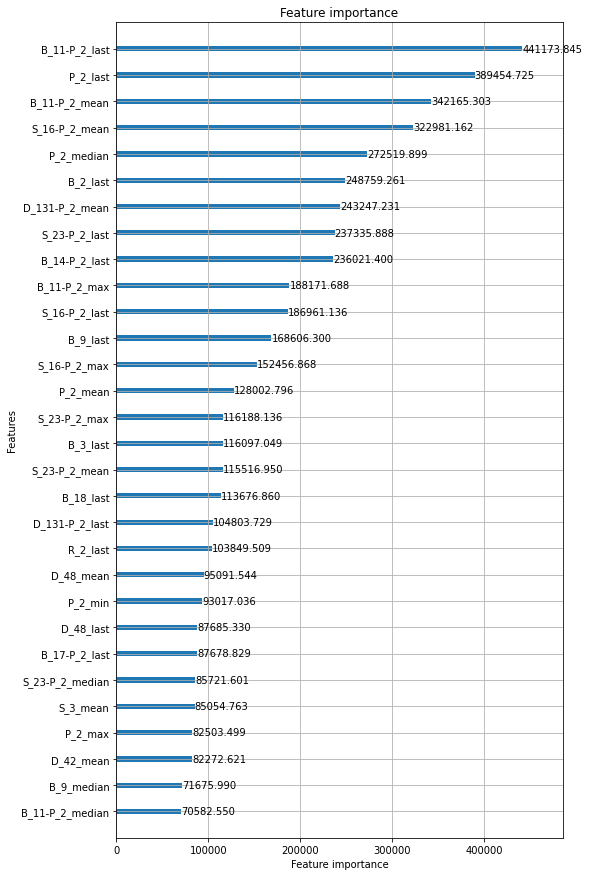

######################################## training model 3/5 ########################################
seed: 17


[50]	valid_0's amex_metric: 0.75044	valid_0's recall_at4: 0.599217	valid_0's norm_gini: 0.901664


[100]	valid_0's amex_metric: 0.755947	valid_0's recall_at4: 0.606875	valid_0's norm_gini: 0.905018


[150]	valid_0's amex_metric: 0.760026	valid_0's recall_at4: 0.613355	valid_0's norm_gini: 0.906698


[200]	valid_0's amex_metric: 0.763944	valid_0's recall_at4: 0.618825	valid_0's norm_gini: 0.909062


[250]	valid_0's amex_metric: 0.769178	valid_0's recall_at4: 0.627283	valid_0's norm_gini: 0.911073


[300]	valid_0's amex_metric: 0.770533	valid_0's recall_at4: 0.629092	valid_0's norm_gini: 0.911975


[350]	valid_0's amex_metric: 0.773334	valid_0's recall_at4: 0.632879	valid_0's norm_gini: 0.91379


[400]	valid_0's amex_metric: 0.775541	valid_0's recall_at4: 0.636077	valid_0's norm_gini: 0.915004


[450]	valid_0's amex_metric: 0.777477	valid_0's recall_at4: 0.63877	valid_0's norm_gini: 0.916185


[500]	valid_0's amex_metric: 0.780065	valid_0's recall_at4: 0.642767	valid_0's norm_gini: 0.917363


[550]	valid_0's amex_metric: 0.781738	valid_0's recall_at4: 0.645123	valid_0's norm_gini: 0.918353


[600]	valid_0's amex_metric: 0.782382	valid_0's recall_at4: 0.645881	valid_0's norm_gini: 0.918883


[650]	valid_0's amex_metric: 0.784711	valid_0's recall_at4: 0.64992	valid_0's norm_gini: 0.919502


[700]	valid_0's amex_metric: 0.78663	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.920058


[750]	valid_0's amex_metric: 0.787071	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.92035


[800]	valid_0's amex_metric: 0.788254	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.920823


[850]	valid_0's amex_metric: 0.788062	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.921198


[900]	valid_0's amex_metric: 0.790077	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.921567


[950]	valid_0's amex_metric: 0.79032	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.92201


[1000]	valid_0's amex_metric: 0.790745	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.922397


[1050]	valid_0's amex_metric: 0.791565	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922564


[1100]	valid_0's amex_metric: 0.791454	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.922763


[1150]	valid_0's amex_metric: 0.791988	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.923032


[1200]	valid_0's amex_metric: 0.792541	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.923338


[1250]	valid_0's amex_metric: 0.792564	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.923553


[1300]	valid_0's amex_metric: 0.793715	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.923834


[1350]	valid_0's amex_metric: 0.794078	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924014


[1400]	valid_0's amex_metric: 0.794375	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.924102


[1450]	valid_0's amex_metric: 0.794207	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924187


[1500]	valid_0's amex_metric: 0.794606	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924228


[1550]	valid_0's amex_metric: 0.794651	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924318


[1600]	valid_0's amex_metric: 0.794897	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.924474


[1650]	valid_0's amex_metric: 0.795205	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924586


[1700]	valid_0's amex_metric: 0.79565	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.924718


[1750]	valid_0's amex_metric: 0.796176	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924843


[1800]	valid_0's amex_metric: 0.796681	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.924969


[1850]	valid_0's amex_metric: 0.796608	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.925034


[1900]	valid_0's amex_metric: 0.79668	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.925095


[1950]	valid_0's amex_metric: 0.79704	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.92514


[2000]	valid_0's amex_metric: 0.797634	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925192


[2050]	valid_0's amex_metric: 0.796914	valid_0's recall_at4: 0.66856	valid_0's norm_gini: 0.925268


[2100]	valid_0's amex_metric: 0.797678	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925323


[2150]	valid_0's amex_metric: 0.798009	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925395


[2200]	valid_0's amex_metric: 0.797739	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925445


[2250]	valid_0's amex_metric: 0.798119	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.92549


[2300]	valid_0's amex_metric: 0.79835	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.92549


[2350]	valid_0's amex_metric: 0.798281	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.92552


[2400]	valid_0's amex_metric: 0.797859	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.925558


[2450]	valid_0's amex_metric: 0.798248	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925622


[2500]	valid_0's amex_metric: 0.798566	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925668


[2550]	valid_0's amex_metric: 0.798283	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925692


[2600]	valid_0's amex_metric: 0.798131	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.925723


[2650]	valid_0's amex_metric: 0.798753	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925789


[2700]	valid_0's amex_metric: 0.798779	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925884


[2750]	valid_0's amex_metric: 0.798536	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925945


[2800]	valid_0's amex_metric: 0.798476	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925993


[2850]	valid_0's amex_metric: 0.798455	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926035


[2900]	valid_0's amex_metric: 0.798798	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926049


[2950]	valid_0's amex_metric: 0.798797	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926131


[3000]	valid_0's amex_metric: 0.799147	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926158


[3050]	valid_0's amex_metric: 0.798848	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926191


[3100]	valid_0's amex_metric: 0.79855	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926227


[3150]	valid_0's amex_metric: 0.798906	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926265


[3200]	valid_0's amex_metric: 0.798776	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926298


[3250]	valid_0's amex_metric: 0.798864	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.926349


[3300]	valid_0's amex_metric: 0.798684	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.926367


[3350]	valid_0's amex_metric: 0.798617	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.926401


[3400]	valid_0's amex_metric: 0.798707	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.926455


[3450]	valid_0's amex_metric: 0.7992	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926473


[3500]	valid_0's amex_metric: 0.798811	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.926495


[3550]	valid_0's amex_metric: 0.798509	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.926522


[3600]	valid_0's amex_metric: 0.798706	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926537


[3650]	valid_0's amex_metric: 0.798474	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.926536


[3700]	valid_0's amex_metric: 0.798528	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.92656


[3750]	valid_0's amex_metric: 0.798637	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.926568


[3800]	valid_0's amex_metric: 0.799144	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926571


[3850]	valid_0's amex_metric: 0.799186	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926571


[3900]	valid_0's amex_metric: 0.799187	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926573


[3950]	valid_0's amex_metric: 0.799157	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926599


[4000]	valid_0's amex_metric: 0.799251	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926619


[4050]	valid_0's amex_metric: 0.799589	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92662


[4100]	valid_0's amex_metric: 0.799385	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926633


[4150]	valid_0's amex_metric: 0.799483	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.926703


[4200]	valid_0's amex_metric: 0.799511	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926716


[4250]	valid_0's amex_metric: 0.799415	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926735


[4300]	valid_0's amex_metric: 0.799474	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926727


[4350]	valid_0's amex_metric: 0.799276	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926752


[4400]	valid_0's amex_metric: 0.799242	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926769


[4450]	valid_0's amex_metric: 0.799481	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926784


[4500]	valid_0's amex_metric: 0.799255	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926795


[4550]	valid_0's amex_metric: 0.799547	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926788


[4600]	valid_0's amex_metric: 0.799626	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.92682


[4650]	valid_0's amex_metric: 0.799536	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.92685


[4700]	valid_0's amex_metric: 0.799648	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926865


[4750]	valid_0's amex_metric: 0.799443	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926876


[4800]	valid_0's amex_metric: 0.799575	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.926887


[4850]	valid_0's amex_metric: 0.8	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926938


[4900]	valid_0's amex_metric: 0.799901	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.92695


[4950]	valid_0's amex_metric: 0.799698	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926964


[5000]	valid_0's amex_metric: 0.799711	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926991


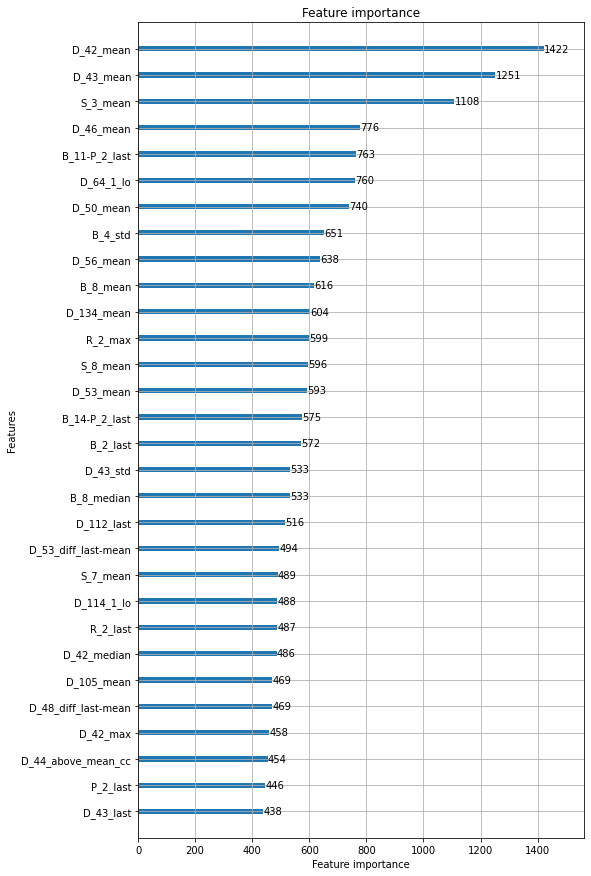

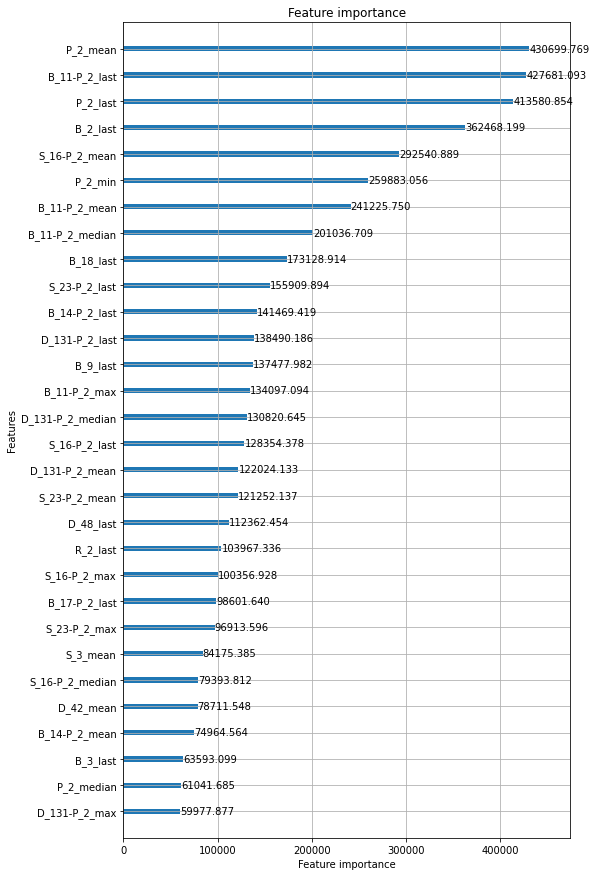

######################################## training model 4/5 ########################################
seed: 18


[50]	valid_0's amex_metric: 0.749296	valid_0's recall_at4: 0.598611	valid_0's norm_gini: 0.89998


[100]	valid_0's amex_metric: 0.75854	valid_0's recall_at4: 0.612034	valid_0's norm_gini: 0.905046


[150]	valid_0's amex_metric: 0.761556	valid_0's recall_at4: 0.6162	valid_0's norm_gini: 0.906912


[200]	valid_0's amex_metric: 0.762204	valid_0's recall_at4: 0.616453	valid_0's norm_gini: 0.907956


[250]	valid_0's amex_metric: 0.762625	valid_0's recall_at4: 0.616537	valid_0's norm_gini: 0.908714


[300]	valid_0's amex_metric: 0.767293	valid_0's recall_at4: 0.623648	valid_0's norm_gini: 0.910938


[350]	valid_0's amex_metric: 0.771084	valid_0's recall_at4: 0.629413	valid_0's norm_gini: 0.912754


[400]	valid_0's amex_metric: 0.771689	valid_0's recall_at4: 0.630086	valid_0's norm_gini: 0.913291


[450]	valid_0's amex_metric: 0.774249	valid_0's recall_at4: 0.63421	valid_0's norm_gini: 0.914287


[500]	valid_0's amex_metric: 0.775047	valid_0's recall_at4: 0.634715	valid_0's norm_gini: 0.915379


[550]	valid_0's amex_metric: 0.776765	valid_0's recall_at4: 0.637534	valid_0's norm_gini: 0.915996


[600]	valid_0's amex_metric: 0.778706	valid_0's recall_at4: 0.64069	valid_0's norm_gini: 0.916722


[650]	valid_0's amex_metric: 0.780106	valid_0's recall_at4: 0.642752	valid_0's norm_gini: 0.917461


[700]	valid_0's amex_metric: 0.781029	valid_0's recall_at4: 0.643972	valid_0's norm_gini: 0.918086


[750]	valid_0's amex_metric: 0.780961	valid_0's recall_at4: 0.643509	valid_0's norm_gini: 0.918412


[800]	valid_0's amex_metric: 0.781624	valid_0's recall_at4: 0.644351	valid_0's norm_gini: 0.918897


[850]	valid_0's amex_metric: 0.783956	valid_0's recall_at4: 0.648306	valid_0's norm_gini: 0.919605


[900]	valid_0's amex_metric: 0.784465	valid_0's recall_at4: 0.649022	valid_0's norm_gini: 0.919908


[950]	valid_0's amex_metric: 0.785408	valid_0's recall_at4: 0.650452	valid_0's norm_gini: 0.920363


[1000]	valid_0's amex_metric: 0.786172	valid_0's recall_at4: 0.651673	valid_0's norm_gini: 0.920671


[1050]	valid_0's amex_metric: 0.786992	valid_0's recall_at4: 0.653103	valid_0's norm_gini: 0.920881


[1100]	valid_0's amex_metric: 0.786909	valid_0's recall_at4: 0.652725	valid_0's norm_gini: 0.921093


[1150]	valid_0's amex_metric: 0.787924	valid_0's recall_at4: 0.654492	valid_0's norm_gini: 0.921357


[1200]	valid_0's amex_metric: 0.788224	valid_0's recall_at4: 0.654871	valid_0's norm_gini: 0.921577


[1250]	valid_0's amex_metric: 0.788298	valid_0's recall_at4: 0.654829	valid_0's norm_gini: 0.921767


[1300]	valid_0's amex_metric: 0.788652	valid_0's recall_at4: 0.655376	valid_0's norm_gini: 0.921928


[1350]	valid_0's amex_metric: 0.789399	valid_0's recall_at4: 0.656722	valid_0's norm_gini: 0.922077


[1400]	valid_0's amex_metric: 0.789596	valid_0's recall_at4: 0.657017	valid_0's norm_gini: 0.922176


[1450]	valid_0's amex_metric: 0.790005	valid_0's recall_at4: 0.657732	valid_0's norm_gini: 0.922278


[1500]	valid_0's amex_metric: 0.790445	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.9224


[1550]	valid_0's amex_metric: 0.790636	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.922531


[1600]	valid_0's amex_metric: 0.790951	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.922613


[1650]	valid_0's amex_metric: 0.790895	valid_0's recall_at4: 0.659036	valid_0's norm_gini: 0.922753


[1700]	valid_0's amex_metric: 0.791085	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.922881


[1750]	valid_0's amex_metric: 0.791214	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.922971


[1800]	valid_0's amex_metric: 0.791627	valid_0's recall_at4: 0.660173	valid_0's norm_gini: 0.923082


[1850]	valid_0's amex_metric: 0.791439	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923127


[1900]	valid_0's amex_metric: 0.791637	valid_0's recall_at4: 0.660046	valid_0's norm_gini: 0.923227


[1950]	valid_0's amex_metric: 0.791877	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.923286


[2000]	valid_0's amex_metric: 0.792066	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.923371


[2050]	valid_0's amex_metric: 0.792105	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.923407


[2100]	valid_0's amex_metric: 0.791656	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.923433


[2150]	valid_0's amex_metric: 0.791899	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.923498


[2200]	valid_0's amex_metric: 0.791604	valid_0's recall_at4: 0.659668	valid_0's norm_gini: 0.92354


[2250]	valid_0's amex_metric: 0.792005	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.923584


[2300]	valid_0's amex_metric: 0.792253	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.923618


[2350]	valid_0's amex_metric: 0.792276	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.923665


[2400]	valid_0's amex_metric: 0.791908	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.923685


[2450]	valid_0's amex_metric: 0.792339	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.923748


[2500]	valid_0's amex_metric: 0.792716	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923787


[2550]	valid_0's amex_metric: 0.793163	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923839


[2600]	valid_0's amex_metric: 0.793079	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.923882


[2650]	valid_0's amex_metric: 0.793657	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.923901


[2700]	valid_0's amex_metric: 0.793575	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.923947


[2750]	valid_0's amex_metric: 0.793713	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.923972


[2800]	valid_0's amex_metric: 0.793666	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924004


[2850]	valid_0's amex_metric: 0.793837	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924051


[2900]	valid_0's amex_metric: 0.793501	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924093


[2950]	valid_0's amex_metric: 0.793557	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.924122


[3000]	valid_0's amex_metric: 0.793771	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.924172


[3050]	valid_0's amex_metric: 0.794085	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.92421


[3100]	valid_0's amex_metric: 0.794191	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924254


[3150]	valid_0's amex_metric: 0.794114	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924269


[3200]	valid_0's amex_metric: 0.794444	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.924297


[3250]	valid_0's amex_metric: 0.794209	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.924333


[3300]	valid_0's amex_metric: 0.794536	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.924354


[3350]	valid_0's amex_metric: 0.794403	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924383


[3400]	valid_0's amex_metric: 0.794389	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.924398


[3450]	valid_0's amex_metric: 0.795026	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924409


[3500]	valid_0's amex_metric: 0.794992	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.924426


[3550]	valid_0's amex_metric: 0.794748	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.924442


[3600]	valid_0's amex_metric: 0.794956	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.924479


[3650]	valid_0's amex_metric: 0.794942	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924493


[3700]	valid_0's amex_metric: 0.795009	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.924501


[3750]	valid_0's amex_metric: 0.794942	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.924535


[3800]	valid_0's amex_metric: 0.795117	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.924549


[3850]	valid_0's amex_metric: 0.794951	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.924554


[3900]	valid_0's amex_metric: 0.794681	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.924603


[3950]	valid_0's amex_metric: 0.79453	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924637


[4000]	valid_0's amex_metric: 0.794539	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924655


[4050]	valid_0's amex_metric: 0.795081	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.924688


[4100]	valid_0's amex_metric: 0.795174	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924705


[4150]	valid_0's amex_metric: 0.795279	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924704


[4200]	valid_0's amex_metric: 0.795183	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924723


[4250]	valid_0's amex_metric: 0.794773	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.924745


[4300]	valid_0's amex_metric: 0.794816	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.924747


[4350]	valid_0's amex_metric: 0.794919	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.924743


[4400]	valid_0's amex_metric: 0.794961	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.924743


[4450]	valid_0's amex_metric: 0.794881	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.92475


[4500]	valid_0's amex_metric: 0.794848	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924769


[4550]	valid_0's amex_metric: 0.7953	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.924789


[4600]	valid_0's amex_metric: 0.79526	valid_0's recall_at4: 0.665727	valid_0's norm_gini: 0.924793


[4650]	valid_0's amex_metric: 0.795475	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.924802


[4700]	valid_0's amex_metric: 0.795375	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.924813


[4750]	valid_0's amex_metric: 0.795448	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.924832


[4800]	valid_0's amex_metric: 0.795357	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924861


[4850]	valid_0's amex_metric: 0.795511	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.924875


[4900]	valid_0's amex_metric: 0.795579	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.924883


[4950]	valid_0's amex_metric: 0.795749	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.924888


[5000]	valid_0's amex_metric: 0.795232	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.924906


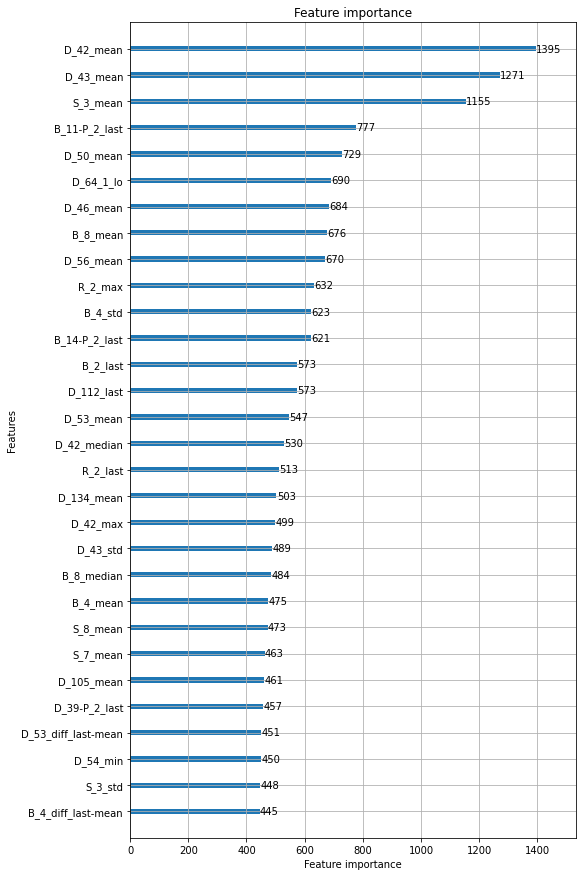

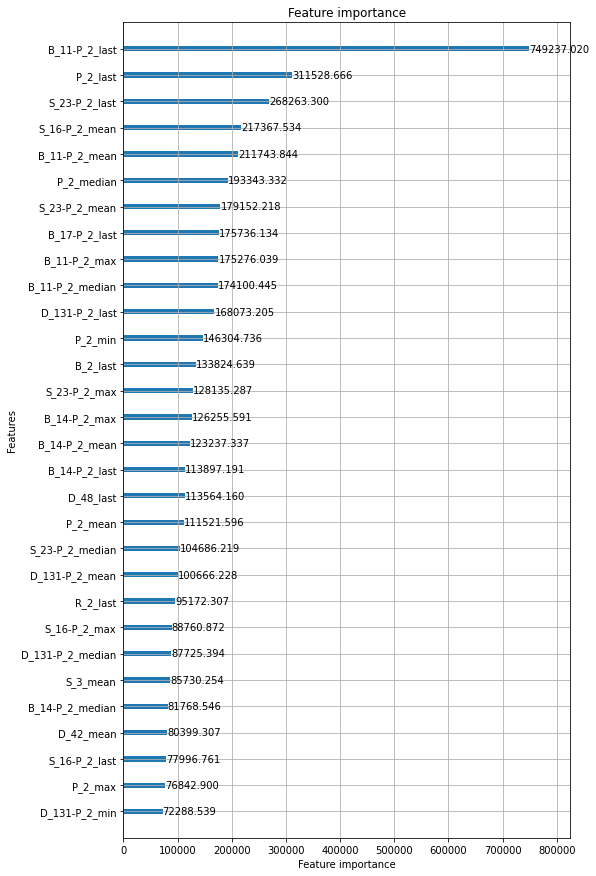

######################################## training model 5/5 ########################################
seed: 19


[50]	valid_0's amex_metric: 0.741404	valid_0's recall_at4: 0.584978	valid_0's norm_gini: 0.897829


[100]	valid_0's amex_metric: 0.749045	valid_0's recall_at4: 0.596507	valid_0's norm_gini: 0.901583


[150]	valid_0's amex_metric: 0.75815	valid_0's recall_at4: 0.609888	valid_0's norm_gini: 0.906411


[200]	valid_0's amex_metric: 0.763961	valid_0's recall_at4: 0.618893	valid_0's norm_gini: 0.909029


[250]	valid_0's amex_metric: 0.767594	valid_0's recall_at4: 0.624069	valid_0's norm_gini: 0.911119


[300]	valid_0's amex_metric: 0.770279	valid_0's recall_at4: 0.628024	valid_0's norm_gini: 0.912533


[350]	valid_0's amex_metric: 0.773144	valid_0's recall_at4: 0.632064	valid_0's norm_gini: 0.914224


[400]	valid_0's amex_metric: 0.776363	valid_0's recall_at4: 0.637198	valid_0's norm_gini: 0.915529


[450]	valid_0's amex_metric: 0.778052	valid_0's recall_at4: 0.639764	valid_0's norm_gini: 0.91634


[500]	valid_0's amex_metric: 0.779236	valid_0's recall_at4: 0.641658	valid_0's norm_gini: 0.916814


[550]	valid_0's amex_metric: 0.779641	valid_0's recall_at4: 0.642037	valid_0's norm_gini: 0.917244


[600]	valid_0's amex_metric: 0.780802	valid_0's recall_at4: 0.643972	valid_0's norm_gini: 0.917631


[650]	valid_0's amex_metric: 0.780654	valid_0's recall_at4: 0.643383	valid_0's norm_gini: 0.917924


[700]	valid_0's amex_metric: 0.78071	valid_0's recall_at4: 0.643215	valid_0's norm_gini: 0.918205


[750]	valid_0's amex_metric: 0.782271	valid_0's recall_at4: 0.645992	valid_0's norm_gini: 0.918551


[800]	valid_0's amex_metric: 0.783269	valid_0's recall_at4: 0.647633	valid_0's norm_gini: 0.918905


[850]	valid_0's amex_metric: 0.783465	valid_0's recall_at4: 0.647717	valid_0's norm_gini: 0.919212


[900]	valid_0's amex_metric: 0.783751	valid_0's recall_at4: 0.64797	valid_0's norm_gini: 0.919533


[950]	valid_0's amex_metric: 0.784338	valid_0's recall_at4: 0.648769	valid_0's norm_gini: 0.919907


[1000]	valid_0's amex_metric: 0.784456	valid_0's recall_at4: 0.648769	valid_0's norm_gini: 0.920143


[1050]	valid_0's amex_metric: 0.784615	valid_0's recall_at4: 0.648769	valid_0's norm_gini: 0.920461


[1100]	valid_0's amex_metric: 0.785376	valid_0's recall_at4: 0.650032	valid_0's norm_gini: 0.92072


[1150]	valid_0's amex_metric: 0.78596	valid_0's recall_at4: 0.650999	valid_0's norm_gini: 0.920921


[1200]	valid_0's amex_metric: 0.787484	valid_0's recall_at4: 0.653819	valid_0's norm_gini: 0.921149


[1250]	valid_0's amex_metric: 0.787641	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.921379


[1300]	valid_0's amex_metric: 0.787716	valid_0's recall_at4: 0.653819	valid_0's norm_gini: 0.921614


[1350]	valid_0's amex_metric: 0.788209	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.921759


[1400]	valid_0's amex_metric: 0.788982	valid_0's recall_at4: 0.656049	valid_0's norm_gini: 0.921916


[1450]	valid_0's amex_metric: 0.789351	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.922106


[1500]	valid_0's amex_metric: 0.789388	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.92218


[1550]	valid_0's amex_metric: 0.789459	valid_0's recall_at4: 0.656638	valid_0's norm_gini: 0.92228


[1600]	valid_0's amex_metric: 0.789961	valid_0's recall_at4: 0.657522	valid_0's norm_gini: 0.9224


[1650]	valid_0's amex_metric: 0.789865	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.922502


[1700]	valid_0's amex_metric: 0.790077	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.922674


[1750]	valid_0's amex_metric: 0.79016	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.922714


[1800]	valid_0's amex_metric: 0.790114	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.922791


[1850]	valid_0's amex_metric: 0.790062	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.922855


[1900]	valid_0's amex_metric: 0.79013	valid_0's recall_at4: 0.657311	valid_0's norm_gini: 0.922948


[1950]	valid_0's amex_metric: 0.790252	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.923026


[2000]	valid_0's amex_metric: 0.790322	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.92308


[2050]	valid_0's amex_metric: 0.790624	valid_0's recall_at4: 0.658111	valid_0's norm_gini: 0.923136


[2100]	valid_0's amex_metric: 0.790986	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.923189


[2150]	valid_0's amex_metric: 0.791459	valid_0's recall_at4: 0.659668	valid_0's norm_gini: 0.923251


[2200]	valid_0's amex_metric: 0.791172	valid_0's recall_at4: 0.659036	valid_0's norm_gini: 0.923308


[2250]	valid_0's amex_metric: 0.791132	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923354


[2300]	valid_0's amex_metric: 0.791148	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923386


[2350]	valid_0's amex_metric: 0.790796	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.923397


[2400]	valid_0's amex_metric: 0.791298	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.923433


[2450]	valid_0's amex_metric: 0.791236	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.923479


[2500]	valid_0's amex_metric: 0.791431	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.923573


[2550]	valid_0's amex_metric: 0.791812	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.92362


[2600]	valid_0's amex_metric: 0.791186	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.923631


[2650]	valid_0's amex_metric: 0.791239	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.923694


[2700]	valid_0's amex_metric: 0.791363	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.923732


[2750]	valid_0's amex_metric: 0.791467	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923813


[2800]	valid_0's amex_metric: 0.792104	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.923867


[2850]	valid_0's amex_metric: 0.792057	valid_0's recall_at4: 0.660215	valid_0's norm_gini: 0.9239


[2900]	valid_0's amex_metric: 0.792784	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.923965


[2950]	valid_0's amex_metric: 0.792404	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924004


[3000]	valid_0's amex_metric: 0.792409	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.924056


[3050]	valid_0's amex_metric: 0.792569	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.924082


[3100]	valid_0's amex_metric: 0.793022	valid_0's recall_at4: 0.66194	valid_0's norm_gini: 0.924104


[3150]	valid_0's amex_metric: 0.793347	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.924124


[3200]	valid_0's amex_metric: 0.793061	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.92414


[3250]	valid_0's amex_metric: 0.793251	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.924183


[3300]	valid_0's amex_metric: 0.793037	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.924219


[3350]	valid_0's amex_metric: 0.792781	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.924253


[3400]	valid_0's amex_metric: 0.792928	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.924295


[3450]	valid_0's amex_metric: 0.792961	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.924319


[3500]	valid_0's amex_metric: 0.793194	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.924321


[3550]	valid_0's amex_metric: 0.793013	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.924338


[3600]	valid_0's amex_metric: 0.792863	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.924375


[3650]	valid_0's amex_metric: 0.793124	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.924392


[3700]	valid_0's amex_metric: 0.793021	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924397


[3750]	valid_0's amex_metric: 0.792763	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.924427


[3800]	valid_0's amex_metric: 0.792689	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924448


[3850]	valid_0's amex_metric: 0.792614	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.924466


[3900]	valid_0's amex_metric: 0.792974	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.924472


[3950]	valid_0's amex_metric: 0.793022	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.924483


[4000]	valid_0's amex_metric: 0.792627	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.924492


[4050]	valid_0's amex_metric: 0.792491	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924514


[4100]	valid_0's amex_metric: 0.792367	valid_0's recall_at4: 0.660215	valid_0's norm_gini: 0.924519


[4150]	valid_0's amex_metric: 0.792664	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924525


[4200]	valid_0's amex_metric: 0.792773	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.924532


[4250]	valid_0's amex_metric: 0.79271	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924532


[4300]	valid_0's amex_metric: 0.792687	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.924527


[4350]	valid_0's amex_metric: 0.792624	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924528


[4400]	valid_0's amex_metric: 0.792665	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924527


[4450]	valid_0's amex_metric: 0.792669	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924534


[4500]	valid_0's amex_metric: 0.792639	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924558


[4550]	valid_0's amex_metric: 0.792507	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924547


[4600]	valid_0's amex_metric: 0.792427	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.924556


[4650]	valid_0's amex_metric: 0.792535	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924562


[4700]	valid_0's amex_metric: 0.792618	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.924559


[4750]	valid_0's amex_metric: 0.792859	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.924577


[4800]	valid_0's amex_metric: 0.792832	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.924609


[4850]	valid_0's amex_metric: 0.792861	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.924623


[4900]	valid_0's amex_metric: 0.792863	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.924628


[4950]	valid_0's amex_metric: 0.793095	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.92463


[5000]	valid_0's amex_metric: 0.793394	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.924638


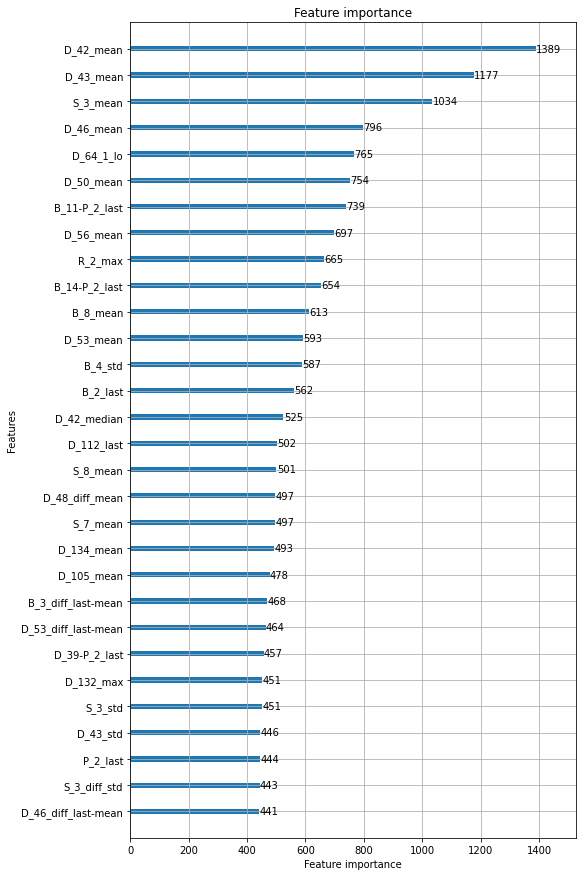

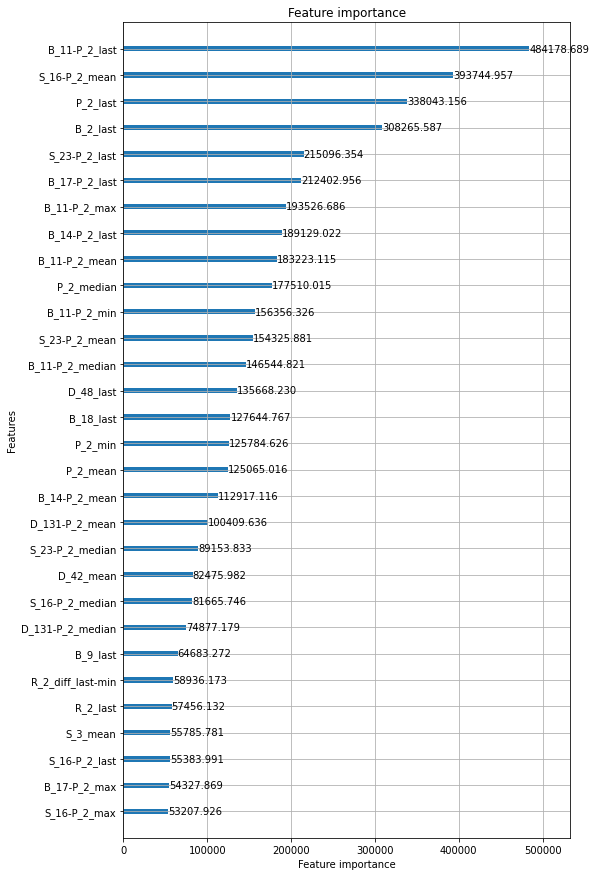

Training time: 73.57775128682455 min.
OOF recall_at4: 0.666265526643552
OOF normalized_gini: 0.9250715192662443
OOF competition metric: 0.7956685229548981


############################### repeated cross-validation step: 5/5 ################################


######################################## training model 1/5 ########################################
seed: 20


[50]	valid_0's amex_metric: 0.747697	valid_0's recall_at4: 0.595052	valid_0's norm_gini: 0.900342


[100]	valid_0's amex_metric: 0.751721	valid_0's recall_at4: 0.601027	valid_0's norm_gini: 0.902415


[150]	valid_0's amex_metric: 0.760128	valid_0's recall_at4: 0.61365	valid_0's norm_gini: 0.906606


[200]	valid_0's amex_metric: 0.766007	valid_0's recall_at4: 0.622738	valid_0's norm_gini: 0.909276


[250]	valid_0's amex_metric: 0.769888	valid_0's recall_at4: 0.628208	valid_0's norm_gini: 0.911568


[300]	valid_0's amex_metric: 0.773657	valid_0's recall_at4: 0.633552	valid_0's norm_gini: 0.913763


[350]	valid_0's amex_metric: 0.774857	valid_0's recall_at4: 0.634814	valid_0's norm_gini: 0.9149


[400]	valid_0's amex_metric: 0.777289	valid_0's recall_at4: 0.638728	valid_0's norm_gini: 0.91585


[450]	valid_0's amex_metric: 0.777763	valid_0's recall_at4: 0.63919	valid_0's norm_gini: 0.916335


[500]	valid_0's amex_metric: 0.778854	valid_0's recall_at4: 0.641	valid_0's norm_gini: 0.916709


[550]	valid_0's amex_metric: 0.779832	valid_0's recall_at4: 0.642515	valid_0's norm_gini: 0.91715


[600]	valid_0's amex_metric: 0.781637	valid_0's recall_at4: 0.645376	valid_0's norm_gini: 0.917898


[650]	valid_0's amex_metric: 0.782252	valid_0's recall_at4: 0.645923	valid_0's norm_gini: 0.918582


[700]	valid_0's amex_metric: 0.783404	valid_0's recall_at4: 0.6479	valid_0's norm_gini: 0.918908


[750]	valid_0's amex_metric: 0.784252	valid_0's recall_at4: 0.649289	valid_0's norm_gini: 0.919214


[800]	valid_0's amex_metric: 0.785303	valid_0's recall_at4: 0.651014	valid_0's norm_gini: 0.919593


[850]	valid_0's amex_metric: 0.78581	valid_0's recall_at4: 0.651814	valid_0's norm_gini: 0.919807


[900]	valid_0's amex_metric: 0.786958	valid_0's recall_at4: 0.653665	valid_0's norm_gini: 0.920251


[950]	valid_0's amex_metric: 0.787735	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.920544


[1000]	valid_0's amex_metric: 0.788744	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.92092


[1050]	valid_0's amex_metric: 0.789266	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.92129


[1100]	valid_0's amex_metric: 0.790652	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.921665


[1150]	valid_0's amex_metric: 0.790457	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.921822


[1200]	valid_0's amex_metric: 0.790648	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.922035


[1250]	valid_0's amex_metric: 0.791541	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.922221


[1300]	valid_0's amex_metric: 0.792723	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.922566


[1350]	valid_0's amex_metric: 0.793068	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.922709


[1400]	valid_0's amex_metric: 0.793424	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.922833


[1450]	valid_0's amex_metric: 0.793571	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.922957


[1500]	valid_0's amex_metric: 0.793767	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.923098


[1550]	valid_0's amex_metric: 0.794006	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923238


[1600]	valid_0's amex_metric: 0.794721	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.923365


[1650]	valid_0's amex_metric: 0.794699	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.923448


[1700]	valid_0's amex_metric: 0.794635	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.92353


[1750]	valid_0's amex_metric: 0.794964	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.923641


[1800]	valid_0's amex_metric: 0.794806	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923788


[1850]	valid_0's amex_metric: 0.795176	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.923896


[1900]	valid_0's amex_metric: 0.795189	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.923963


[1950]	valid_0's amex_metric: 0.795277	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.924056


[2000]	valid_0's amex_metric: 0.795245	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.924118


[2050]	valid_0's amex_metric: 0.795698	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.924183


[2100]	valid_0's amex_metric: 0.795816	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.92425


[2150]	valid_0's amex_metric: 0.796001	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.924325


[2200]	valid_0's amex_metric: 0.796597	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.924423


[2250]	valid_0's amex_metric: 0.797248	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.924506


[2300]	valid_0's amex_metric: 0.797296	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924559


[2350]	valid_0's amex_metric: 0.797241	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.924617


[2400]	valid_0's amex_metric: 0.797533	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.924696


[2450]	valid_0's amex_metric: 0.797937	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.924747


[2500]	valid_0's amex_metric: 0.797825	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.924775


[2550]	valid_0's amex_metric: 0.79784	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.924806


[2600]	valid_0's amex_metric: 0.798062	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.924828


[2650]	valid_0's amex_metric: 0.798245	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.924858


[2700]	valid_0's amex_metric: 0.798644	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.924942


[2750]	valid_0's amex_metric: 0.799059	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.925014


[2800]	valid_0's amex_metric: 0.798767	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925061


[2850]	valid_0's amex_metric: 0.798954	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.925098


[2900]	valid_0's amex_metric: 0.799444	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.925152


[2950]	valid_0's amex_metric: 0.799136	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.925168


[3000]	valid_0's amex_metric: 0.799167	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.925187


[3050]	valid_0's amex_metric: 0.799092	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.925206


[3100]	valid_0's amex_metric: 0.799185	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.925265


[3150]	valid_0's amex_metric: 0.799764	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.925287


[3200]	valid_0's amex_metric: 0.799886	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.925322


[3250]	valid_0's amex_metric: 0.799451	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.925334


[3300]	valid_0's amex_metric: 0.799808	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.925333


[3350]	valid_0's amex_metric: 0.799657	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.925327


[3400]	valid_0's amex_metric: 0.79996	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.925343


[3450]	valid_0's amex_metric: 0.800545	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.925376


[3500]	valid_0's amex_metric: 0.800058	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.925413


[3550]	valid_0's amex_metric: 0.800008	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.925438


[3600]	valid_0's amex_metric: 0.800398	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.925461


[3650]	valid_0's amex_metric: 0.80032	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.925473


[3700]	valid_0's amex_metric: 0.80028	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.925477


[3750]	valid_0's amex_metric: 0.800624	valid_0's recall_at4: 0.675755	valid_0's norm_gini: 0.925493


[3800]	valid_0's amex_metric: 0.801107	valid_0's recall_at4: 0.676681	valid_0's norm_gini: 0.925533


[3850]	valid_0's amex_metric: 0.800787	valid_0's recall_at4: 0.676008	valid_0's norm_gini: 0.925565


[3900]	valid_0's amex_metric: 0.800736	valid_0's recall_at4: 0.675882	valid_0's norm_gini: 0.925591


[3950]	valid_0's amex_metric: 0.800306	valid_0's recall_at4: 0.674998	valid_0's norm_gini: 0.925614


[4000]	valid_0's amex_metric: 0.800868	valid_0's recall_at4: 0.676092	valid_0's norm_gini: 0.925643


[4050]	valid_0's amex_metric: 0.800846	valid_0's recall_at4: 0.67605	valid_0's norm_gini: 0.925643


[4100]	valid_0's amex_metric: 0.801048	valid_0's recall_at4: 0.676428	valid_0's norm_gini: 0.925667


[4150]	valid_0's amex_metric: 0.800679	valid_0's recall_at4: 0.675671	valid_0's norm_gini: 0.925688


[4200]	valid_0's amex_metric: 0.800308	valid_0's recall_at4: 0.674914	valid_0's norm_gini: 0.925702


[4250]	valid_0's amex_metric: 0.800278	valid_0's recall_at4: 0.67483	valid_0's norm_gini: 0.925727


[4300]	valid_0's amex_metric: 0.800083	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.925758


[4350]	valid_0's amex_metric: 0.800273	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.925759


[4400]	valid_0's amex_metric: 0.799798	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.925776


[4450]	valid_0's amex_metric: 0.800487	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.925808


[4500]	valid_0's amex_metric: 0.800864	valid_0's recall_at4: 0.675882	valid_0's norm_gini: 0.925846


[4550]	valid_0's amex_metric: 0.800759	valid_0's recall_at4: 0.675671	valid_0's norm_gini: 0.925847


[4600]	valid_0's amex_metric: 0.800663	valid_0's recall_at4: 0.675461	valid_0's norm_gini: 0.925866


[4650]	valid_0's amex_metric: 0.800902	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.92588


[4700]	valid_0's amex_metric: 0.800823	valid_0's recall_at4: 0.675755	valid_0's norm_gini: 0.92589


[4750]	valid_0's amex_metric: 0.800927	valid_0's recall_at4: 0.675966	valid_0's norm_gini: 0.925889


[4800]	valid_0's amex_metric: 0.80053	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.925894


[4850]	valid_0's amex_metric: 0.800344	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.9259


[4900]	valid_0's amex_metric: 0.800864	valid_0's recall_at4: 0.675797	valid_0's norm_gini: 0.925931


[4950]	valid_0's amex_metric: 0.800932	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.925941


[5000]	valid_0's amex_metric: 0.800831	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.925949


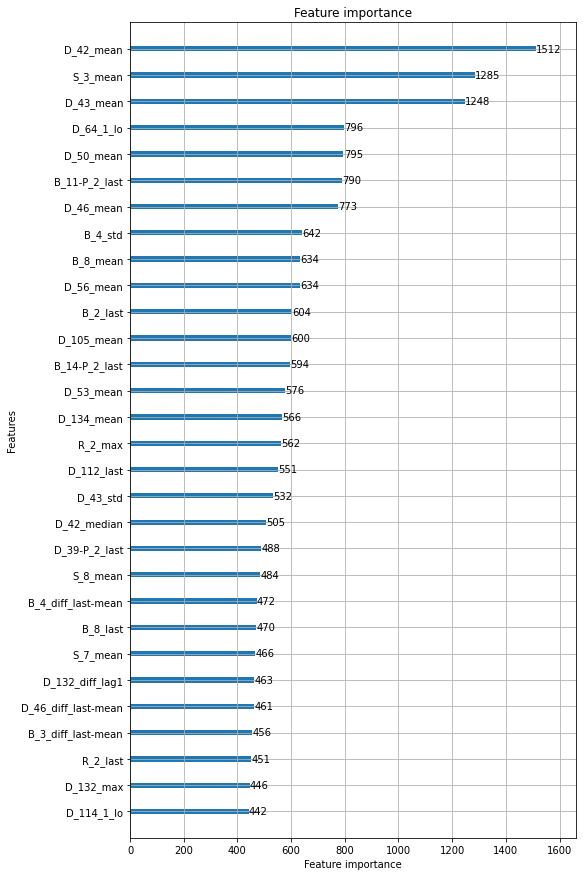

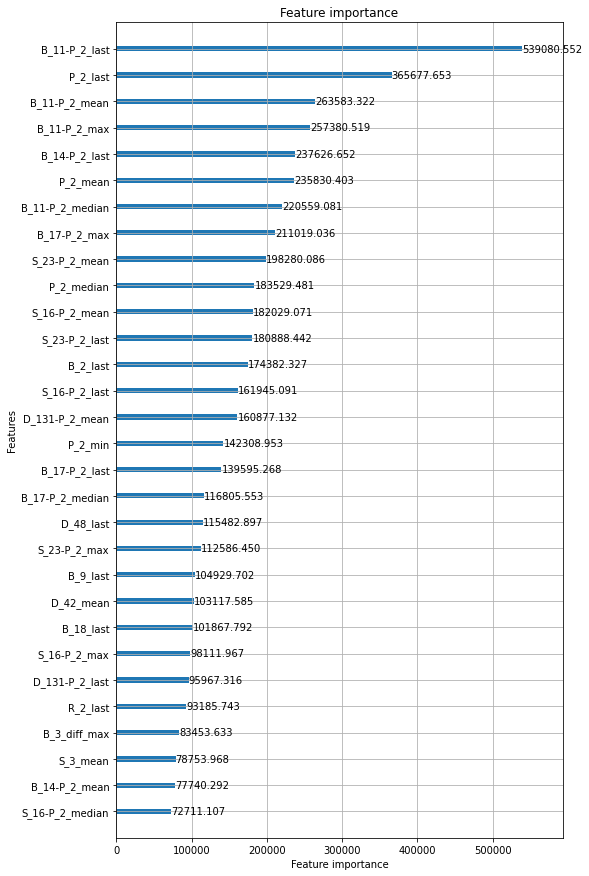

######################################## training model 2/5 ########################################
seed: 21


[50]	valid_0's amex_metric: 0.753094	valid_0's recall_at4: 0.604687	valid_0's norm_gini: 0.9015


[100]	valid_0's amex_metric: 0.759526	valid_0's recall_at4: 0.613902	valid_0's norm_gini: 0.90515


[150]	valid_0's amex_metric: 0.764979	valid_0's recall_at4: 0.622486	valid_0's norm_gini: 0.907473


[200]	valid_0's amex_metric: 0.768331	valid_0's recall_at4: 0.626736	valid_0's norm_gini: 0.909926


[250]	valid_0's amex_metric: 0.773105	valid_0's recall_at4: 0.633636	valid_0's norm_gini: 0.912574


[300]	valid_0's amex_metric: 0.775541	valid_0's recall_at4: 0.63675	valid_0's norm_gini: 0.914331


[350]	valid_0's amex_metric: 0.778567	valid_0's recall_at4: 0.641	valid_0's norm_gini: 0.916133


[400]	valid_0's amex_metric: 0.78051	valid_0's recall_at4: 0.643735	valid_0's norm_gini: 0.917286


[450]	valid_0's amex_metric: 0.781829	valid_0's recall_at4: 0.645965	valid_0's norm_gini: 0.917693


[500]	valid_0's amex_metric: 0.782502	valid_0's recall_at4: 0.646806	valid_0's norm_gini: 0.918197


[550]	valid_0's amex_metric: 0.784126	valid_0's recall_at4: 0.649289	valid_0's norm_gini: 0.918964


[600]	valid_0's amex_metric: 0.784549	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.919263


[650]	valid_0's amex_metric: 0.785356	valid_0's recall_at4: 0.650972	valid_0's norm_gini: 0.91974


[700]	valid_0's amex_metric: 0.786477	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.920089


[750]	valid_0's amex_metric: 0.786335	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.920393


[800]	valid_0's amex_metric: 0.787456	valid_0's recall_at4: 0.654128	valid_0's norm_gini: 0.920784


[850]	valid_0's amex_metric: 0.78844	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.92128


[900]	valid_0's amex_metric: 0.789468	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.92161


[950]	valid_0's amex_metric: 0.789332	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.921802


[1000]	valid_0's amex_metric: 0.789958	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.92217


[1050]	valid_0's amex_metric: 0.790096	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.922361


[1100]	valid_0's amex_metric: 0.790742	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.922644


[1150]	valid_0's amex_metric: 0.7912	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.922803


[1200]	valid_0's amex_metric: 0.791702	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.922964


[1250]	valid_0's amex_metric: 0.792101	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923173


[1300]	valid_0's amex_metric: 0.793347	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923393


[1350]	valid_0's amex_metric: 0.79393	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923718


[1400]	valid_0's amex_metric: 0.794135	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.923875


[1450]	valid_0's amex_metric: 0.79448	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.924018


[1500]	valid_0's amex_metric: 0.794707	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.92422


[1550]	valid_0's amex_metric: 0.795203	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.92437


[1600]	valid_0's amex_metric: 0.795054	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.924577


[1650]	valid_0's amex_metric: 0.794935	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.924676


[1700]	valid_0's amex_metric: 0.795368	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.924742


[1750]	valid_0's amex_metric: 0.79559	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924766


[1800]	valid_0's amex_metric: 0.795527	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.924892


[1850]	valid_0's amex_metric: 0.795425	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924941


[1900]	valid_0's amex_metric: 0.7958	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.925017


[1950]	valid_0's amex_metric: 0.795648	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.925049


[2000]	valid_0's amex_metric: 0.795956	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.925076


[2050]	valid_0's amex_metric: 0.795689	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.925131


[2100]	valid_0's amex_metric: 0.795888	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.925152


[2150]	valid_0's amex_metric: 0.795833	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.925209


[2200]	valid_0's amex_metric: 0.795839	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.925263


[2250]	valid_0's amex_metric: 0.795803	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.925319


[2300]	valid_0's amex_metric: 0.795677	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.925362


[2350]	valid_0's amex_metric: 0.795882	valid_0's recall_at4: 0.66633	valid_0's norm_gini: 0.925434


[2400]	valid_0's amex_metric: 0.796163	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.925491


[2450]	valid_0's amex_metric: 0.796564	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.925535


[2500]	valid_0's amex_metric: 0.797118	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.925591


[2550]	valid_0's amex_metric: 0.797415	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925638


[2600]	valid_0's amex_metric: 0.796825	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.925678


[2650]	valid_0's amex_metric: 0.79704	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925731


[2700]	valid_0's amex_metric: 0.796754	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925748


[2750]	valid_0's amex_metric: 0.797104	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.925815


[2800]	valid_0's amex_metric: 0.797432	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.92584


[2850]	valid_0's amex_metric: 0.797783	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.92587


[2900]	valid_0's amex_metric: 0.797668	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925892


[2950]	valid_0's amex_metric: 0.798057	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.925956


[3000]	valid_0's amex_metric: 0.798571	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925972


[3050]	valid_0's amex_metric: 0.798615	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.92602


[3100]	valid_0's amex_metric: 0.798752	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926041


[3150]	valid_0's amex_metric: 0.798782	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926058


[3200]	valid_0's amex_metric: 0.799144	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926067


[3250]	valid_0's amex_metric: 0.798936	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926071


[3300]	valid_0's amex_metric: 0.798839	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.926088


[3350]	valid_0's amex_metric: 0.798972	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.926102


[3400]	valid_0's amex_metric: 0.799153	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926127


[3450]	valid_0's amex_metric: 0.799331	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926147


[3500]	valid_0's amex_metric: 0.799383	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926167


[3550]	valid_0's amex_metric: 0.799374	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92619


[3600]	valid_0's amex_metric: 0.798833	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926203


[3650]	valid_0's amex_metric: 0.799388	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926219


[3700]	valid_0's amex_metric: 0.799266	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.926268


[3750]	valid_0's amex_metric: 0.799201	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926307


[3800]	valid_0's amex_metric: 0.799032	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926348


[3850]	valid_0's amex_metric: 0.799106	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.926371


[3900]	valid_0's amex_metric: 0.799202	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926393


[3950]	valid_0's amex_metric: 0.79906	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926405


[4000]	valid_0's amex_metric: 0.798891	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.926445


[4050]	valid_0's amex_metric: 0.798777	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.926469


[4100]	valid_0's amex_metric: 0.798831	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.926494


[4150]	valid_0's amex_metric: 0.799057	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.926525


[4200]	valid_0's amex_metric: 0.799098	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.926522


[4250]	valid_0's amex_metric: 0.79924	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926553


[4300]	valid_0's amex_metric: 0.799016	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926568


[4350]	valid_0's amex_metric: 0.799085	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.92658


[4400]	valid_0's amex_metric: 0.799362	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926587


[4450]	valid_0's amex_metric: 0.799272	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926619


[4500]	valid_0's amex_metric: 0.799209	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926618


[4550]	valid_0's amex_metric: 0.799405	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926631


[4600]	valid_0's amex_metric: 0.799291	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926656


[4650]	valid_0's amex_metric: 0.799436	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926652


[4700]	valid_0's amex_metric: 0.799609	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926661


[4750]	valid_0's amex_metric: 0.799445	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926669


[4800]	valid_0's amex_metric: 0.799613	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926669


[4850]	valid_0's amex_metric: 0.799506	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926666


[4900]	valid_0's amex_metric: 0.799909	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926671


[4950]	valid_0's amex_metric: 0.799895	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.926686


[5000]	valid_0's amex_metric: 0.800492	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926702


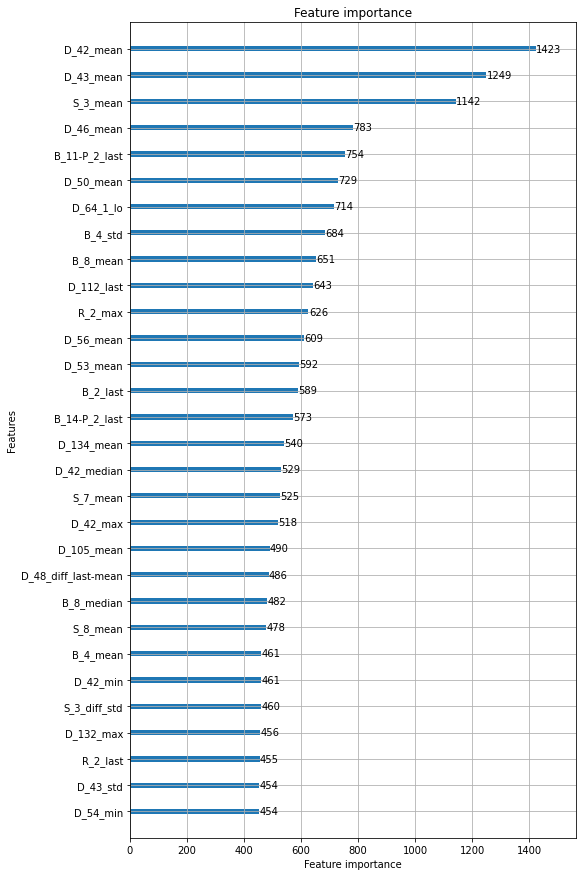

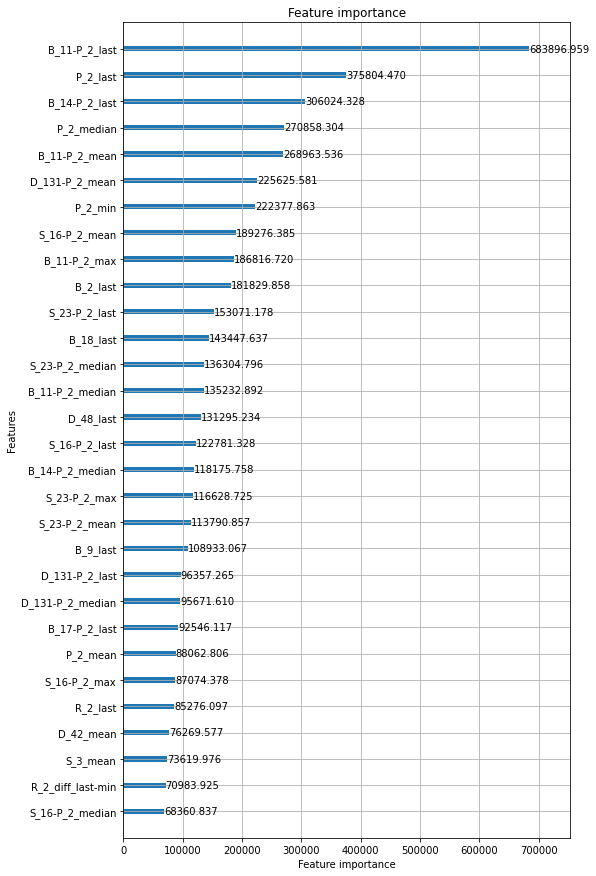

######################################## training model 3/5 ########################################
seed: 22


[50]	valid_0's amex_metric: 0.747735	valid_0's recall_at4: 0.594589	valid_0's norm_gini: 0.900881


[100]	valid_0's amex_metric: 0.752021	valid_0's recall_at4: 0.601027	valid_0's norm_gini: 0.903015


[150]	valid_0's amex_metric: 0.755291	valid_0's recall_at4: 0.605655	valid_0's norm_gini: 0.904927


[200]	valid_0's amex_metric: 0.759589	valid_0's recall_at4: 0.611967	valid_0's norm_gini: 0.90721


[250]	valid_0's amex_metric: 0.765288	valid_0's recall_at4: 0.621139	valid_0's norm_gini: 0.909436


[300]	valid_0's amex_metric: 0.768965	valid_0's recall_at4: 0.626231	valid_0's norm_gini: 0.911699


[350]	valid_0's amex_metric: 0.771431	valid_0's recall_at4: 0.629639	valid_0's norm_gini: 0.913224


[400]	valid_0's amex_metric: 0.773286	valid_0's recall_at4: 0.632079	valid_0's norm_gini: 0.914492


[450]	valid_0's amex_metric: 0.774915	valid_0's recall_at4: 0.634688	valid_0's norm_gini: 0.915143


[500]	valid_0's amex_metric: 0.776745	valid_0's recall_at4: 0.637465	valid_0's norm_gini: 0.916026


[550]	valid_0's amex_metric: 0.777876	valid_0's recall_at4: 0.639233	valid_0's norm_gini: 0.916519


[600]	valid_0's amex_metric: 0.779137	valid_0's recall_at4: 0.641	valid_0's norm_gini: 0.917274


[650]	valid_0's amex_metric: 0.779895	valid_0's recall_at4: 0.641883	valid_0's norm_gini: 0.917907


[700]	valid_0's amex_metric: 0.780637	valid_0's recall_at4: 0.642935	valid_0's norm_gini: 0.918338


[750]	valid_0's amex_metric: 0.781111	valid_0's recall_at4: 0.643356	valid_0's norm_gini: 0.918866


[800]	valid_0's amex_metric: 0.782217	valid_0's recall_at4: 0.645039	valid_0's norm_gini: 0.919395


[850]	valid_0's amex_metric: 0.782615	valid_0's recall_at4: 0.645586	valid_0's norm_gini: 0.919643


[900]	valid_0's amex_metric: 0.783129	valid_0's recall_at4: 0.646386	valid_0's norm_gini: 0.919872


[950]	valid_0's amex_metric: 0.784209	valid_0's recall_at4: 0.648237	valid_0's norm_gini: 0.92018


[1000]	valid_0's amex_metric: 0.784091	valid_0's recall_at4: 0.647816	valid_0's norm_gini: 0.920365


[1050]	valid_0's amex_metric: 0.785153	valid_0's recall_at4: 0.649541	valid_0's norm_gini: 0.920765


[1100]	valid_0's amex_metric: 0.785414	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.920992


[1150]	valid_0's amex_metric: 0.785957	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.921236


[1200]	valid_0's amex_metric: 0.786561	valid_0's recall_at4: 0.651687	valid_0's norm_gini: 0.921434


[1250]	valid_0's amex_metric: 0.786843	valid_0's recall_at4: 0.652066	valid_0's norm_gini: 0.92162


[1300]	valid_0's amex_metric: 0.786856	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.921856


[1350]	valid_0's amex_metric: 0.787178	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.921995


[1400]	valid_0's amex_metric: 0.787428	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.922201


[1450]	valid_0's amex_metric: 0.787523	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.92239


[1500]	valid_0's amex_metric: 0.788168	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.922461


[1550]	valid_0's amex_metric: 0.78873	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.922575


[1600]	valid_0's amex_metric: 0.788277	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.922636


[1650]	valid_0's amex_metric: 0.789108	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.922742


[1700]	valid_0's amex_metric: 0.78897	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.922802


[1750]	valid_0's amex_metric: 0.789428	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.922919


[1800]	valid_0's amex_metric: 0.789772	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922976


[1850]	valid_0's amex_metric: 0.789729	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.923059


[1900]	valid_0's amex_metric: 0.790162	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.923125


[1950]	valid_0's amex_metric: 0.790258	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.92319


[2000]	valid_0's amex_metric: 0.79056	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.92329


[2050]	valid_0's amex_metric: 0.790527	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.923349


[2100]	valid_0's amex_metric: 0.790731	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.923378


[2150]	valid_0's amex_metric: 0.791081	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.923448


[2200]	valid_0's amex_metric: 0.791956	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923515


[2250]	valid_0's amex_metric: 0.79126	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.923553


[2300]	valid_0's amex_metric: 0.791449	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.923596


[2350]	valid_0's amex_metric: 0.791759	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.923668


[2400]	valid_0's amex_metric: 0.791701	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.923762


[2450]	valid_0's amex_metric: 0.791626	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.923823


[2500]	valid_0's amex_metric: 0.791598	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.923851


[2550]	valid_0's amex_metric: 0.791401	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.92392


[2600]	valid_0's amex_metric: 0.791614	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.923967


[2650]	valid_0's amex_metric: 0.792043	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.924025


[2700]	valid_0's amex_metric: 0.792274	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.924067


[2750]	valid_0's amex_metric: 0.792593	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.924115


[2800]	valid_0's amex_metric: 0.792524	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.924188


[2850]	valid_0's amex_metric: 0.79262	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.924211


[2900]	valid_0's amex_metric: 0.7925	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924224


[2950]	valid_0's amex_metric: 0.792249	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.92427


[3000]	valid_0's amex_metric: 0.792264	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.924299


[3050]	valid_0's amex_metric: 0.791978	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.924317


[3100]	valid_0's amex_metric: 0.791929	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.924344


[3150]	valid_0's amex_metric: 0.791788	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.924356


[3200]	valid_0's amex_metric: 0.791542	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.92437


[3250]	valid_0's amex_metric: 0.791892	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.924397


[3300]	valid_0's amex_metric: 0.791694	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.924422


[3350]	valid_0's amex_metric: 0.792141	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924431


[3400]	valid_0's amex_metric: 0.792383	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.924453


[3450]	valid_0's amex_metric: 0.792592	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.924492


[3500]	valid_0's amex_metric: 0.792717	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.924532


[3550]	valid_0's amex_metric: 0.792928	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.924575


[3600]	valid_0's amex_metric: 0.792884	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.924613


[3650]	valid_0's amex_metric: 0.792436	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.924643


[3700]	valid_0's amex_metric: 0.792156	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.924673


[3750]	valid_0's amex_metric: 0.79233	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.924684


[3800]	valid_0's amex_metric: 0.792592	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.924703


[3850]	valid_0's amex_metric: 0.79207	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.92471


[3900]	valid_0's amex_metric: 0.792555	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.924713


[3950]	valid_0's amex_metric: 0.792583	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.924727


[4000]	valid_0's amex_metric: 0.792892	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.924756


[4050]	valid_0's amex_metric: 0.79286	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.924775


[4100]	valid_0's amex_metric: 0.792848	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.924793


[4150]	valid_0's amex_metric: 0.792415	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.924811


[4200]	valid_0's amex_metric: 0.793163	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.924835


[4250]	valid_0's amex_metric: 0.793659	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924858


[4300]	valid_0's amex_metric: 0.793265	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.924871


[4350]	valid_0's amex_metric: 0.79333	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924873


[4400]	valid_0's amex_metric: 0.793352	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924875


[4450]	valid_0's amex_metric: 0.793398	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.924885


[4500]	valid_0's amex_metric: 0.792981	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.924892


[4550]	valid_0's amex_metric: 0.793087	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.924892


[4600]	valid_0's amex_metric: 0.793136	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.924907


[4650]	valid_0's amex_metric: 0.792638	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.92492


[4700]	valid_0's amex_metric: 0.79317	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924933


[4750]	valid_0's amex_metric: 0.793047	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.92494


[4800]	valid_0's amex_metric: 0.793243	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.924952


[4850]	valid_0's amex_metric: 0.793289	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924961


[4900]	valid_0's amex_metric: 0.793376	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924966


[4950]	valid_0's amex_metric: 0.793302	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924987


[5000]	valid_0's amex_metric: 0.793577	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.92499


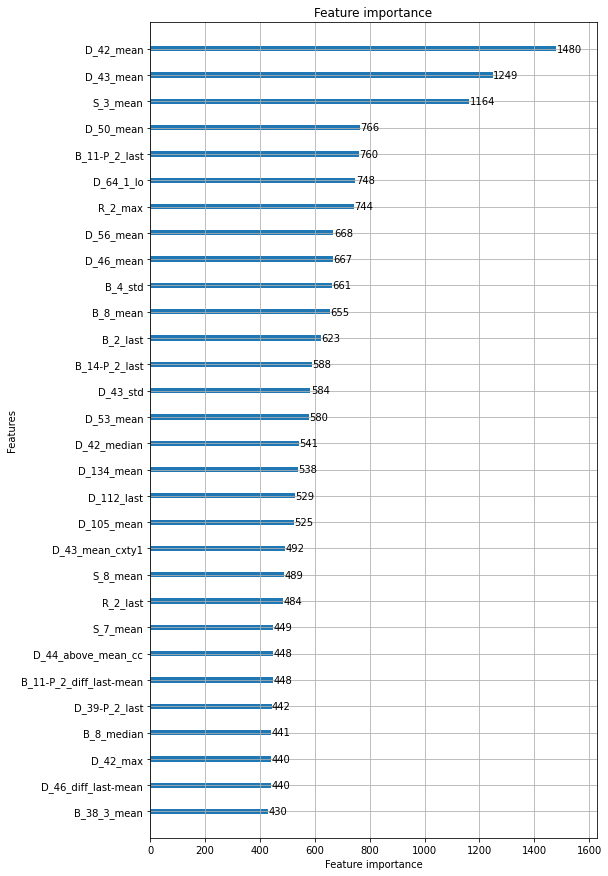

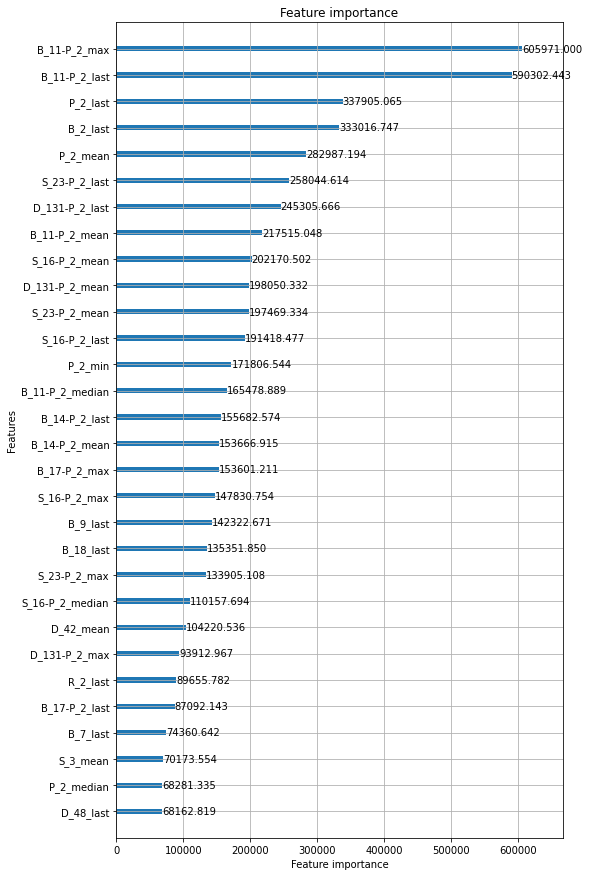

######################################## training model 4/5 ########################################
seed: 23


[50]	valid_0's amex_metric: 0.744616	valid_0's recall_at4: 0.590364	valid_0's norm_gini: 0.898868


[100]	valid_0's amex_metric: 0.756657	valid_0's recall_at4: 0.608332	valid_0's norm_gini: 0.904983


[150]	valid_0's amex_metric: 0.760187	valid_0's recall_at4: 0.613171	valid_0's norm_gini: 0.907203


[200]	valid_0's amex_metric: 0.764696	valid_0's recall_at4: 0.619861	valid_0's norm_gini: 0.909531


[250]	valid_0's amex_metric: 0.768062	valid_0's recall_at4: 0.625373	valid_0's norm_gini: 0.910751


[300]	valid_0's amex_metric: 0.76844	valid_0's recall_at4: 0.62571	valid_0's norm_gini: 0.91117


[350]	valid_0's amex_metric: 0.771652	valid_0's recall_at4: 0.630549	valid_0's norm_gini: 0.912754


[400]	valid_0's amex_metric: 0.77331	valid_0's recall_at4: 0.632779	valid_0's norm_gini: 0.913841


[450]	valid_0's amex_metric: 0.774404	valid_0's recall_at4: 0.634168	valid_0's norm_gini: 0.914641


[500]	valid_0's amex_metric: 0.776319	valid_0's recall_at4: 0.637282	valid_0's norm_gini: 0.915357


[550]	valid_0's amex_metric: 0.776663	valid_0's recall_at4: 0.637324	valid_0's norm_gini: 0.916003


[600]	valid_0's amex_metric: 0.778573	valid_0's recall_at4: 0.64048	valid_0's norm_gini: 0.916665


[650]	valid_0's amex_metric: 0.779861	valid_0's recall_at4: 0.642499	valid_0's norm_gini: 0.917223


[700]	valid_0's amex_metric: 0.780949	valid_0's recall_at4: 0.644098	valid_0's norm_gini: 0.9178


[750]	valid_0's amex_metric: 0.781829	valid_0's recall_at4: 0.645277	valid_0's norm_gini: 0.918381


[800]	valid_0's amex_metric: 0.783098	valid_0's recall_at4: 0.647339	valid_0's norm_gini: 0.918858


[850]	valid_0's amex_metric: 0.783941	valid_0's recall_at4: 0.648643	valid_0's norm_gini: 0.91924


[900]	valid_0's amex_metric: 0.785496	valid_0's recall_at4: 0.65142	valid_0's norm_gini: 0.919571


[950]	valid_0's amex_metric: 0.785549	valid_0's recall_at4: 0.651168	valid_0's norm_gini: 0.91993


[1000]	valid_0's amex_metric: 0.786261	valid_0's recall_at4: 0.652304	valid_0's norm_gini: 0.920219


[1050]	valid_0's amex_metric: 0.78666	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.920343


[1100]	valid_0's amex_metric: 0.786817	valid_0's recall_at4: 0.653061	valid_0's norm_gini: 0.920573


[1150]	valid_0's amex_metric: 0.786914	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.920808


[1200]	valid_0's amex_metric: 0.78751	valid_0's recall_at4: 0.653987	valid_0's norm_gini: 0.921034


[1250]	valid_0's amex_metric: 0.787652	valid_0's recall_at4: 0.654113	valid_0's norm_gini: 0.921192


[1300]	valid_0's amex_metric: 0.787893	valid_0's recall_at4: 0.654408	valid_0's norm_gini: 0.921379


[1350]	valid_0's amex_metric: 0.788338	valid_0's recall_at4: 0.655123	valid_0's norm_gini: 0.921553


[1400]	valid_0's amex_metric: 0.788293	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.921674


[1450]	valid_0's amex_metric: 0.787885	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.921698


[1500]	valid_0's amex_metric: 0.788173	valid_0's recall_at4: 0.654534	valid_0's norm_gini: 0.921812


[1550]	valid_0's amex_metric: 0.78861	valid_0's recall_at4: 0.655249	valid_0's norm_gini: 0.92197


[1600]	valid_0's amex_metric: 0.788596	valid_0's recall_at4: 0.655081	valid_0's norm_gini: 0.92211


[1650]	valid_0's amex_metric: 0.788799	valid_0's recall_at4: 0.655376	valid_0's norm_gini: 0.922222


[1700]	valid_0's amex_metric: 0.789631	valid_0's recall_at4: 0.65689	valid_0's norm_gini: 0.922371


[1750]	valid_0's amex_metric: 0.789844	valid_0's recall_at4: 0.657143	valid_0's norm_gini: 0.922544


[1800]	valid_0's amex_metric: 0.790146	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.922686


[1850]	valid_0's amex_metric: 0.789868	valid_0's recall_at4: 0.65689	valid_0's norm_gini: 0.922846


[1900]	valid_0's amex_metric: 0.790283	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.922961


[1950]	valid_0's amex_metric: 0.790343	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.923081


[2000]	valid_0's amex_metric: 0.790657	valid_0's recall_at4: 0.658153	valid_0's norm_gini: 0.923162


[2050]	valid_0's amex_metric: 0.790571	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.9232


[2100]	valid_0's amex_metric: 0.79097	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.923241


[2150]	valid_0's amex_metric: 0.7906	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.923257


[2200]	valid_0's amex_metric: 0.791221	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923321


[2250]	valid_0's amex_metric: 0.791563	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923375


[2300]	valid_0's amex_metric: 0.792133	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.923421


[2350]	valid_0's amex_metric: 0.792395	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.923481


[2400]	valid_0's amex_metric: 0.79301	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923533


[2450]	valid_0's amex_metric: 0.792387	valid_0's recall_at4: 0.661182	valid_0's norm_gini: 0.923592


[2500]	valid_0's amex_metric: 0.79233	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.923646


[2550]	valid_0's amex_metric: 0.792549	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.923706


[2600]	valid_0's amex_metric: 0.792824	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.92375


[2650]	valid_0's amex_metric: 0.792621	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.923807


[2700]	valid_0's amex_metric: 0.792269	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.923819


[2750]	valid_0's amex_metric: 0.792153	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.923838


[2800]	valid_0's amex_metric: 0.792471	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.923887


[2850]	valid_0's amex_metric: 0.792243	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.923893


[2900]	valid_0's amex_metric: 0.792913	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.923927


[2950]	valid_0's amex_metric: 0.792774	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.923944


[3000]	valid_0's amex_metric: 0.792626	valid_0's recall_at4: 0.661267	valid_0's norm_gini: 0.923986


[3050]	valid_0's amex_metric: 0.792711	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.924029


[3100]	valid_0's amex_metric: 0.792651	valid_0's recall_at4: 0.661267	valid_0's norm_gini: 0.924036


[3150]	valid_0's amex_metric: 0.792498	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924066


[3200]	valid_0's amex_metric: 0.792441	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924078


[3250]	valid_0's amex_metric: 0.792854	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.924105


[3300]	valid_0's amex_metric: 0.793101	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.924135


[3350]	valid_0's amex_metric: 0.792821	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.924166


[3400]	valid_0's amex_metric: 0.793423	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.924191


[3450]	valid_0's amex_metric: 0.793564	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.92422


[3500]	valid_0's amex_metric: 0.79346	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924222


[3550]	valid_0's amex_metric: 0.793489	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.92424


[3600]	valid_0's amex_metric: 0.793549	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.924274


[3650]	valid_0's amex_metric: 0.793791	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.924295


[3700]	valid_0's amex_metric: 0.793819	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.92431


[3750]	valid_0's amex_metric: 0.793673	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924311


[3800]	valid_0's amex_metric: 0.793844	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.924317


[3850]	valid_0's amex_metric: 0.794299	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924344


[3900]	valid_0's amex_metric: 0.793802	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.924359


[3950]	valid_0's amex_metric: 0.793857	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924386


[4000]	valid_0's amex_metric: 0.793674	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.924398


[4050]	valid_0's amex_metric: 0.794493	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924437


[4100]	valid_0's amex_metric: 0.794076	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.924445


[4150]	valid_0's amex_metric: 0.794141	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.924449


[4200]	valid_0's amex_metric: 0.794249	valid_0's recall_at4: 0.664044	valid_0's norm_gini: 0.924454


[4250]	valid_0's amex_metric: 0.794425	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.924469


[4300]	valid_0's amex_metric: 0.794754	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924496


[4350]	valid_0's amex_metric: 0.794687	valid_0's recall_at4: 0.664843	valid_0's norm_gini: 0.92453


[4400]	valid_0's amex_metric: 0.794419	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.924543


[4450]	valid_0's amex_metric: 0.794525	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924543


[4500]	valid_0's amex_metric: 0.794525	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924544


[4550]	valid_0's amex_metric: 0.794335	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924542


[4600]	valid_0's amex_metric: 0.79454	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924573


[4650]	valid_0's amex_metric: 0.794397	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.924581


[4700]	valid_0's amex_metric: 0.794219	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.924604


[4750]	valid_0's amex_metric: 0.794229	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.924624


[4800]	valid_0's amex_metric: 0.794575	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924643


[4850]	valid_0's amex_metric: 0.794857	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.924661


[4900]	valid_0's amex_metric: 0.794652	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.924671


[4950]	valid_0's amex_metric: 0.795012	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.924676


[5000]	valid_0's amex_metric: 0.795086	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.924697


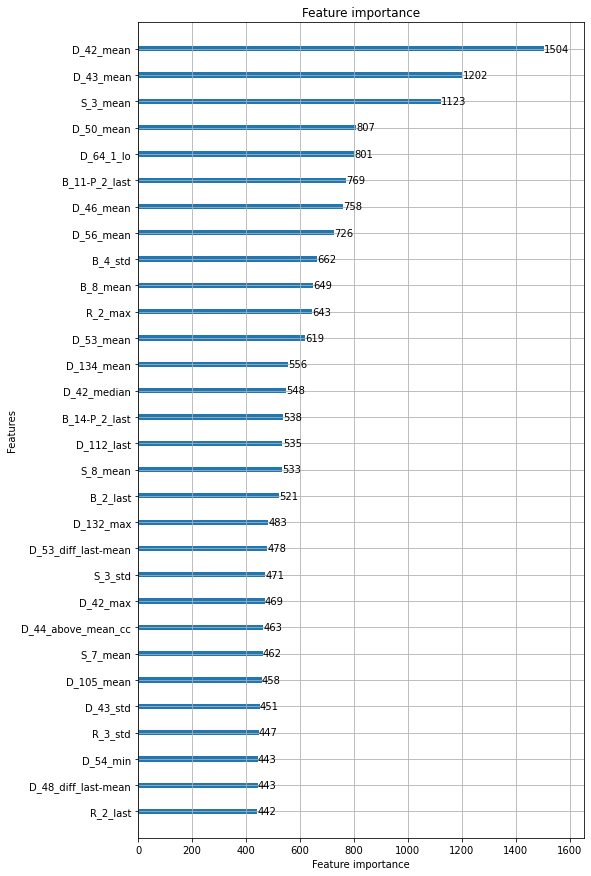

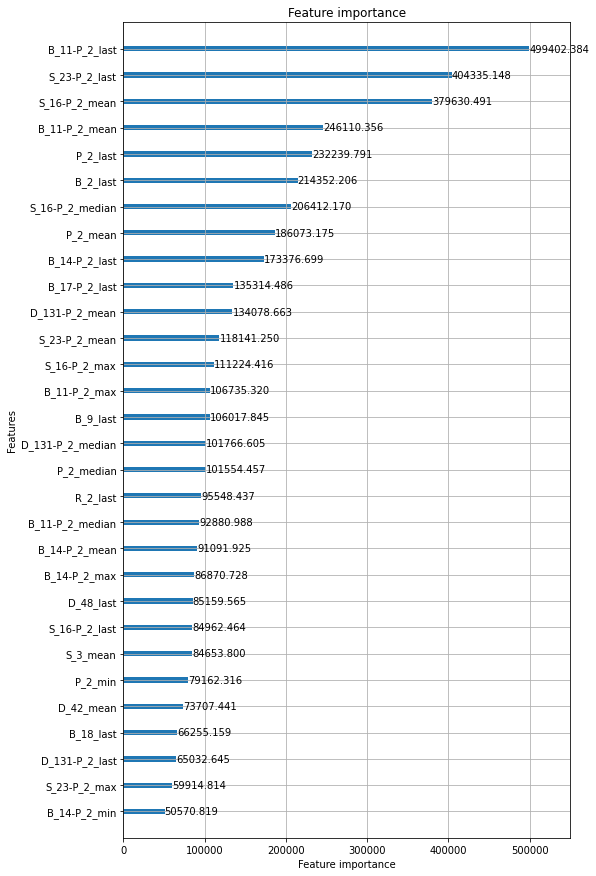

######################################## training model 5/5 ########################################
seed: 24


[50]	valid_0's amex_metric: 0.74597	valid_0's recall_at4: 0.593057	valid_0's norm_gini: 0.898883


[100]	valid_0's amex_metric: 0.754454	valid_0's recall_at4: 0.60526	valid_0's norm_gini: 0.903649


[150]	valid_0's amex_metric: 0.758321	valid_0's recall_at4: 0.610604	valid_0's norm_gini: 0.906039


[200]	valid_0's amex_metric: 0.762081	valid_0's recall_at4: 0.6162	valid_0's norm_gini: 0.907962


[250]	valid_0's amex_metric: 0.764757	valid_0's recall_at4: 0.620156	valid_0's norm_gini: 0.909358


[300]	valid_0's amex_metric: 0.767512	valid_0's recall_at4: 0.624153	valid_0's norm_gini: 0.91087


[350]	valid_0's amex_metric: 0.770056	valid_0's recall_at4: 0.627646	valid_0's norm_gini: 0.912466


[400]	valid_0's amex_metric: 0.771504	valid_0's recall_at4: 0.629665	valid_0's norm_gini: 0.913343


[450]	valid_0's amex_metric: 0.773553	valid_0's recall_at4: 0.632611	valid_0's norm_gini: 0.914496


[500]	valid_0's amex_metric: 0.77398	valid_0's recall_at4: 0.632779	valid_0's norm_gini: 0.91518


[550]	valid_0's amex_metric: 0.776522	valid_0's recall_at4: 0.637198	valid_0's norm_gini: 0.915847


[600]	valid_0's amex_metric: 0.777538	valid_0's recall_at4: 0.638923	valid_0's norm_gini: 0.916153


[650]	valid_0's amex_metric: 0.77874	valid_0's recall_at4: 0.640858	valid_0's norm_gini: 0.916621


[700]	valid_0's amex_metric: 0.779179	valid_0's recall_at4: 0.641447	valid_0's norm_gini: 0.916911


[750]	valid_0's amex_metric: 0.77921	valid_0's recall_at4: 0.641195	valid_0's norm_gini: 0.917224


[800]	valid_0's amex_metric: 0.780126	valid_0's recall_at4: 0.642626	valid_0's norm_gini: 0.917627


[850]	valid_0's amex_metric: 0.780711	valid_0's recall_at4: 0.643425	valid_0's norm_gini: 0.917997


[900]	valid_0's amex_metric: 0.782369	valid_0's recall_at4: 0.64616	valid_0's norm_gini: 0.918578


[950]	valid_0's amex_metric: 0.783187	valid_0's recall_at4: 0.647296	valid_0's norm_gini: 0.919077


[1000]	valid_0's amex_metric: 0.784392	valid_0's recall_at4: 0.649316	valid_0's norm_gini: 0.919467


[1050]	valid_0's amex_metric: 0.784331	valid_0's recall_at4: 0.648938	valid_0's norm_gini: 0.919724


[1100]	valid_0's amex_metric: 0.784326	valid_0's recall_at4: 0.648769	valid_0's norm_gini: 0.919883


[1150]	valid_0's amex_metric: 0.78413	valid_0's recall_at4: 0.64818	valid_0's norm_gini: 0.92008


[1200]	valid_0's amex_metric: 0.78466	valid_0's recall_at4: 0.649064	valid_0's norm_gini: 0.920257


[1250]	valid_0's amex_metric: 0.784899	valid_0's recall_at4: 0.649316	valid_0's norm_gini: 0.920481


[1300]	valid_0's amex_metric: 0.78597	valid_0's recall_at4: 0.651294	valid_0's norm_gini: 0.920647


[1350]	valid_0's amex_metric: 0.786604	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.920821


[1400]	valid_0's amex_metric: 0.786817	valid_0's recall_at4: 0.652683	valid_0's norm_gini: 0.920952


[1450]	valid_0's amex_metric: 0.787562	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.921053


[1500]	valid_0's amex_metric: 0.786818	valid_0's recall_at4: 0.652514	valid_0's norm_gini: 0.921122


[1550]	valid_0's amex_metric: 0.786872	valid_0's recall_at4: 0.652556	valid_0's norm_gini: 0.921187


[1600]	valid_0's amex_metric: 0.786704	valid_0's recall_at4: 0.652135	valid_0's norm_gini: 0.921273


[1650]	valid_0's amex_metric: 0.78732	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.92141


[1700]	valid_0's amex_metric: 0.787366	valid_0's recall_at4: 0.653272	valid_0's norm_gini: 0.92146


[1750]	valid_0's amex_metric: 0.787628	valid_0's recall_at4: 0.653692	valid_0's norm_gini: 0.921564


[1800]	valid_0's amex_metric: 0.787895	valid_0's recall_at4: 0.654155	valid_0's norm_gini: 0.921635


[1850]	valid_0's amex_metric: 0.788368	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.92174


[1900]	valid_0's amex_metric: 0.788949	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.921891


[1950]	valid_0's amex_metric: 0.789223	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.922061


[2000]	valid_0's amex_metric: 0.789809	valid_0's recall_at4: 0.657395	valid_0's norm_gini: 0.922223


[2050]	valid_0's amex_metric: 0.790276	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922274


[2100]	valid_0's amex_metric: 0.790325	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.92237


[2150]	valid_0's amex_metric: 0.790154	valid_0's recall_at4: 0.657858	valid_0's norm_gini: 0.92245


[2200]	valid_0's amex_metric: 0.790409	valid_0's recall_at4: 0.658321	valid_0's norm_gini: 0.922498


[2250]	valid_0's amex_metric: 0.790381	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.922566


[2300]	valid_0's amex_metric: 0.790736	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.922646


[2350]	valid_0's amex_metric: 0.790954	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.922704


[2400]	valid_0's amex_metric: 0.791452	valid_0's recall_at4: 0.660173	valid_0's norm_gini: 0.922731


[2450]	valid_0's amex_metric: 0.791735	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.922793


[2500]	valid_0's amex_metric: 0.791439	valid_0's recall_at4: 0.660046	valid_0's norm_gini: 0.922832


[2550]	valid_0's amex_metric: 0.791904	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.922879


[2600]	valid_0's amex_metric: 0.791714	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.922919


[2650]	valid_0's amex_metric: 0.791728	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.922947


[2700]	valid_0's amex_metric: 0.791903	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.923003


[2750]	valid_0's amex_metric: 0.791744	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.923021


[2800]	valid_0's amex_metric: 0.791878	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.923078


[2850]	valid_0's amex_metric: 0.792336	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.923111


[2900]	valid_0's amex_metric: 0.792445	valid_0's recall_at4: 0.661729	valid_0's norm_gini: 0.92316


[2950]	valid_0's amex_metric: 0.792843	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.9232


[3000]	valid_0's amex_metric: 0.792568	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.923237


[3050]	valid_0's amex_metric: 0.792943	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.923273


[3100]	valid_0's amex_metric: 0.792956	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.9233


[3150]	valid_0's amex_metric: 0.793315	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923301


[3200]	valid_0's amex_metric: 0.792908	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923329


[3250]	valid_0's amex_metric: 0.793134	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.923361


[3300]	valid_0's amex_metric: 0.793264	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.92341


[3350]	valid_0's amex_metric: 0.792953	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923419


[3400]	valid_0's amex_metric: 0.793321	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.923441


[3450]	valid_0's amex_metric: 0.79339	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923452


[3500]	valid_0's amex_metric: 0.793679	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.923482


[3550]	valid_0's amex_metric: 0.793292	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.923508


[3600]	valid_0's amex_metric: 0.793025	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.923521


[3650]	valid_0's amex_metric: 0.793594	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.923564


[3700]	valid_0's amex_metric: 0.793335	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.923594


[3750]	valid_0's amex_metric: 0.793154	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.923611


[3800]	valid_0's amex_metric: 0.793179	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.923619


[3850]	valid_0's amex_metric: 0.793273	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.923639


[3900]	valid_0's amex_metric: 0.792655	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923664


[3950]	valid_0's amex_metric: 0.793205	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.923712


[4000]	valid_0's amex_metric: 0.793375	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.923717


[4050]	valid_0's amex_metric: 0.793114	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.92374


[4100]	valid_0's amex_metric: 0.792949	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.923747


[4150]	valid_0's amex_metric: 0.79308	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.923758


[4200]	valid_0's amex_metric: 0.793393	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.923795


[4250]	valid_0's amex_metric: 0.793472	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.923825


[4300]	valid_0's amex_metric: 0.7936	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.92383


[4350]	valid_0's amex_metric: 0.793902	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.923845


[4400]	valid_0's amex_metric: 0.794316	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.923873


[4450]	valid_0's amex_metric: 0.793781	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.923898


[4500]	valid_0's amex_metric: 0.794026	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.923923


[4550]	valid_0's amex_metric: 0.794053	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.923937


[4600]	valid_0's amex_metric: 0.79395	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.92394


[4650]	valid_0's amex_metric: 0.793853	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.923956


[4700]	valid_0's amex_metric: 0.793797	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.92397


[4750]	valid_0's amex_metric: 0.79408	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.92399


[4800]	valid_0's amex_metric: 0.794038	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.923991


[4850]	valid_0's amex_metric: 0.79412	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.923985


[4900]	valid_0's amex_metric: 0.79423	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.923995


[4950]	valid_0's amex_metric: 0.793835	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.924005


[5000]	valid_0's amex_metric: 0.794288	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924027


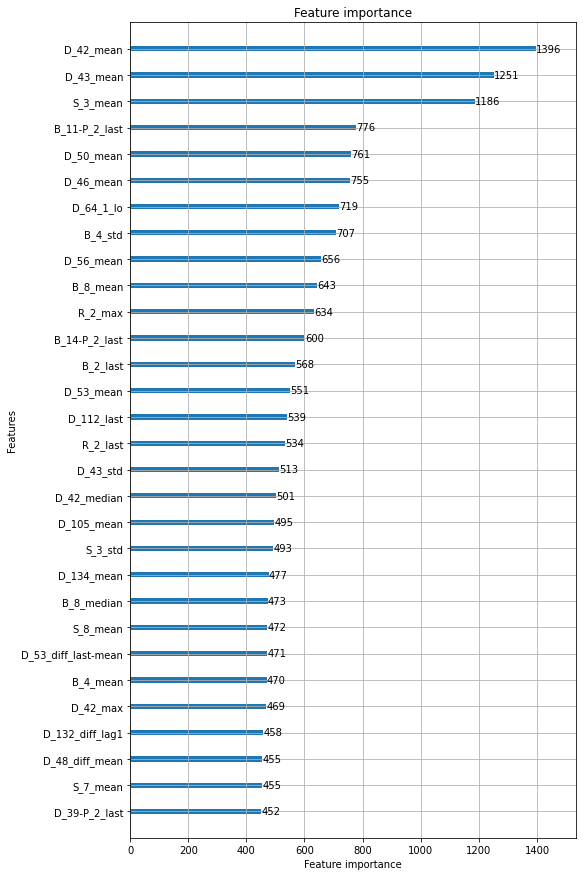

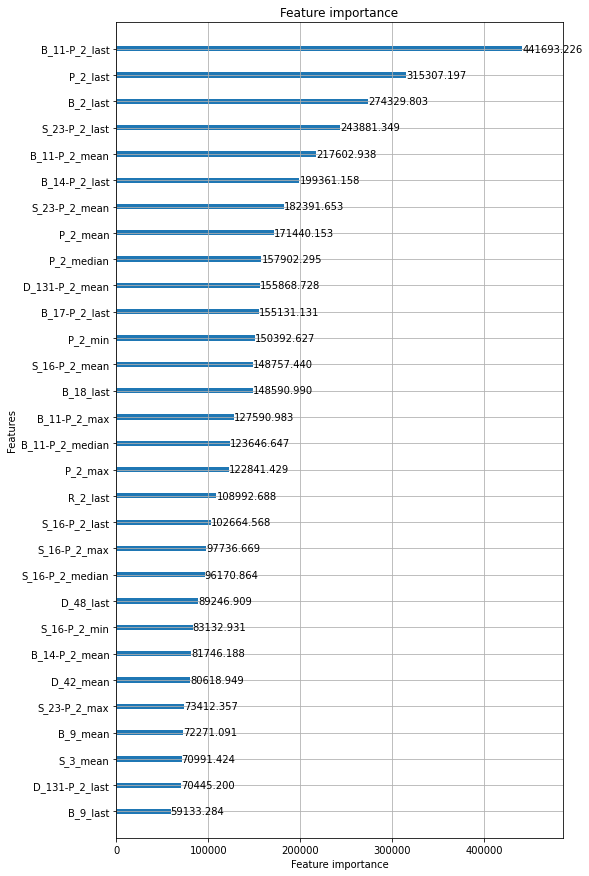

Training time: 73.3588026324908 min.
OOF recall_at4: 0.6678728919109974
OOF normalized_gini: 0.9251310562653262
OOF competition metric: 0.7965019740881618


CPU times: user 6d 18h 38min 57s, sys: 4min 24s, total: 6d 18h 43min 22s
Wall time: 6h 6min 9s


In [12]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
        
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [13]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

recall_at4      gini    metric
0    0.666350  0.925057  0.795703
1    0.667587  0.925066  0.796327
2    0.665946  0.925071  0.795508
3    0.666266  0.925072  0.795669
4    0.667873  0.925131  0.796502


mean:


recall_at4    0.666804
gini          0.925079
metric        0.795942
dtype: float64


std:


recall_at4    0.000864
gini          0.000030
metric        0.000442
dtype: float64

In [14]:
del train, all_oof_dfs
gc.collect()

21

***
## make predictions and submit

In [15]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)       

In [16]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [17]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 5h 20min 19s, sys: 1min 10s, total: 5h 21min 30s
Wall time: 13min 13s


In [18]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.51 s, sys: 657 ms, total: 4.16 s
Wall time: 4.16 s


***